# Home credit default risk

### 1.1 Import library

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.preprocessing import LabelBinarizer,PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.model_selection import KFold
import lightgbm as lgb
%matplotlib inline
plt.style.use('ggplot')
seed =420
pd.options.display.max_rows = 100

### 1.2 Load dataset

In [264]:
#nrows = 1000
nrows =None
#path = '../input/'
path = 'dataset/'
"""app_train = pd.read_csv(path+'application_train.csv', nrows= nrows)
app_test = pd.read_csv(path+'application_test.csv', nrows= None)
bureau_balance = pd.read_csv(path+'bureau_balance.csv', nrows=nrows)
bureau = pd.read_csv(path+'bureau.csv', nrows=nrows)
installments_payments = pd.read_csv(path+ 'installments_payments.csv', nrows= nrows)
POS_CASH_balance = pd.read_csv(path+ 'POS_CASH_balance.csv', nrows= nrows)
credit_card_balance = pd.read_csv(path+'credit_card_balance.csv',nrows=nrows)"""
previous_application = pd.read_csv(path+ 'previous_application.csv', nrows= nrows)
gc.collect()

test_index = app_test['SK_ID_CURR'] # Store test index

### 1.3 Reduce memory of dataset function

In [3]:
# Reduce memory of dataset
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe """
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')

### 1.4 Basic details function

In [4]:
def basic_details(df):
    """ Returns basic detials of features in dataset"""
    k = pd.DataFrame()
    k['missing_value'] = df.isnull().sum()
    k['%missing_value'] = round(df.isnull().sum()*100/df.shape[0],2)
    k['dtypes'] = df.dtypes
    k['N unique'] = df.nunique()
    #k['mean'] = df.mean()
    return k

### 1.5 Fill missing value function

In [5]:
# Fill missing value with mode
def missing_value_fill(df ,columns, mean_or_mode='mode'):
    """ Fill missing value with
        mode: for categorical variable
        mean: for numerical variable"""
    for i in columns:
        if (df[i].isnull().sum()>0) and (mean_or_mode =='mode'):
            df[i].fillna(df[i].mode()[0], inplace=True)
        elif (df[i].isnull().sum()>0) and (mean_or_mode =='mean'):
            df[i].fillna(df[i].mean(), inplace=True)

In [6]:
# Replace missing value np.nan
def replace_XNA_XAP(df):
    "Replace XNA,XAP"
    df.replace(to_replace = {'XNA':np.nan,'XAP':np.nan},inplace=True,value= None)
    return df

### 1.6 One hot encoding function

In [7]:
def one_hot_encoding(df,columns,nan_as_category = True):
    """ One hot encoding of categorical variable"""
    print('*'*5,'One hot encoding of categorical variable','*'*5)
    print('Original shape',df.shape)
    original_columns = df.columns
    # One hot encoding using get dummies function
    df = pd.get_dummies(df, columns= columns,drop_first=True,dummy_na=nan_as_category)
    new_columns = [i for i in df.columns if i not in original_columns]
    print('After OHE',df.shape)
    return df,new_columns

In [8]:
def descriptive_stat_feat(df,columns):
    """ Descriptive statistics feature
    genarating function: Mean,Median,Q1,Q3"""
    print('*'*5,'Descriptive statistics feature','*'*5)
    print('Before',df.shape)
    mean = df[columns].mean()
    median = df[columns].median()
    Q1 = np.percentile(df[columns], 25, axis=0)
    Q3 = np.percentile(df[columns], 75, axis=0)
    for i,j in enumerate(columns):
        df['mean_'+j] = (df[j] < mean[i]).astype('int8')
        df['median_'+j] = (df[j] > median[i]).astype('int8')
        df['Q1'+j] = (df[j] < Q1[i]).astype('int8')
        df['Q3'+j] = (df[j] > Q3[i]).astype('int8')
    print('After ',df.shape)

In [9]:
def binary_encoding(df,columns):
    """Binary encoding"""
    print('*'*5,'Binary encoding','*'*5)
    lb = LabelBinarizer()
    print('Original shape:',df.shape)
    original_col = df.columns
    #columns = [i for i in columns if df[columns].nunique()>2]
    for i in columns:
        if df[i].nunique() >2:
            result = lb.fit_transform(df[i].fillna(df[i].mode()[0],axis=0))
            col = ['BIN_'+ str(i)+'_'+str(c) for c in lb.classes_]
            result1 = pd.DataFrame(result, columns=col)
            df = df.join(result1)
    print('After:',df.shape)
    new_col = [c for c in df.columns if c not in original_col]
    return df, new_col

## 2 Application train/test dataset
### 2.0 Glimpse Application train / test dataset

In [10]:
print('Number of rows and columns in train dataset: ',app_train.shape)
app_train.head()

Number of rows and columns in train dataset:  (1000, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

              ...              FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                             0                0   
1             ...                             0                0   
2             ...                             0                0   
3             ...                             0                0   
4             ...                             0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        NaN   
4                0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       NaN                         NaN   
4                       0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  
3                         NaN  
4                         0.0  

[5 rows x 122 columns]

In [11]:
print('Number of rows and columns in test dataset: ',app_test.shape)
app_test.head()

Number of rows and columns in test dataset:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

              ...             FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                            0                0   
1             ...                            0                0   
2             ...                            0                0   
3             ...                            0                0   
4             ...                            0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        0.0   
4                0                0                        NaN   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        NaN                         NaN   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        1.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         0.0  
1                         3.0  
2                         4.0  
3                         3.0  
4                         NaN  

[5 rows x 121 columns]

In [12]:
pd.read_csv(path+'sample_submission.csv').head()

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

### 2.1 Columns

In [13]:
app_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
      

### 2.2 Current id

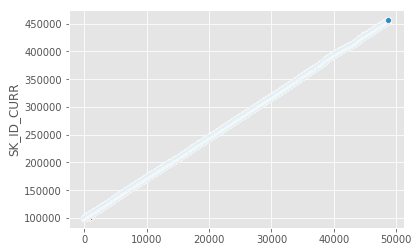

In [14]:
sns.scatterplot(range(app_train.shape[0]),app_train['SK_ID_CURR'].sort_values())
sns.scatterplot(range(app_test.shape[0]),app_test['SK_ID_CURR'].sort_values())

### 2.3 Target

In [15]:
test_index = app_test['SK_ID_CURR']
app_train_col_drop = [] # Drop the columns, which have least importance

In [16]:
print('Count\n',app_train['TARGET'].value_counts())
print('%\n',app_train['TARGET'].value_counts()*100/app_train.shape[0])

Count
 0    930
1     70
Name: TARGET, dtype: int64
%
 0    93.0
1     7.0
Name: TARGET, dtype: float64


The 0 stands for loan repayment on time, 1 stands for loan repayment not done on time, so only 8% of loan repayment happens late.

### 2.4 Binary feature
* NAME_CONTRACT_TYPE: Identification if loan is cash or revolving
* FLAG_OWN_REALTY: Flag if client owns a house or flat

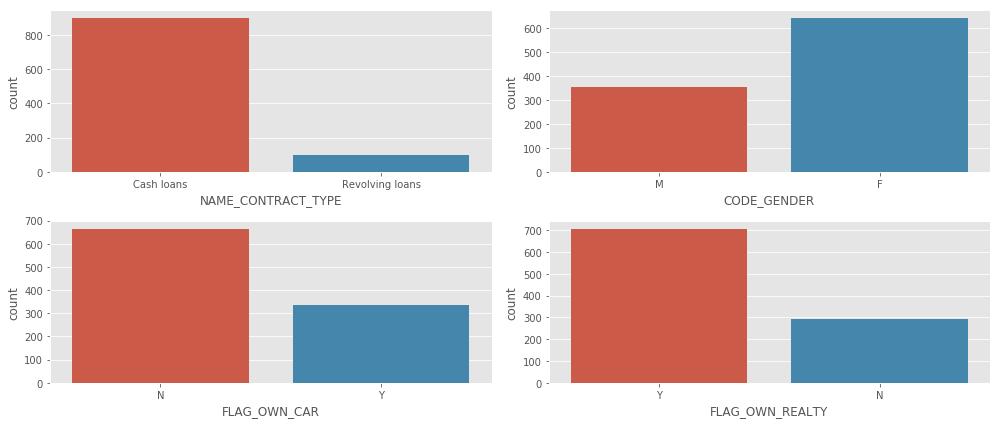

In [17]:
f =plt.figure(figsize=(14,6))
ax= f.add_subplot(221)
sns.countplot(app_train['NAME_CONTRACT_TYPE'])
ax=f.add_subplot(222)
sns.countplot(app_train['CODE_GENDER'])
ax=f.add_subplot(223)
sns.countplot(app_train['FLAG_OWN_CAR'])
ax=f.add_subplot(224)
sns.countplot(app_train['FLAG_OWN_REALTY'])
plt.tight_layout()

In [18]:
# convert to categorical type
app_train[['NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']] =   app_train[
    ['NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']].astype('object')
app_test[['NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']] =   app_test[
    ['NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']].astype('object')


### 2.5 Number of Children 
Number of children the client has

In [19]:
#plt.figure(figsize=(14,4))
#sns.countplot(app_train['CNT_CHILDREN'])
tmp = app_train['CNT_CHILDREN'].value_counts().to_frame()
tmp['%'] = (app_train['CNT_CHILDREN'].value_counts() *100 / app_train.shape[0])
tmp

CNT_CHILDREN     %
0           715  71.5
1           177  17.7
2            95   9.5
3            13   1.3

In [20]:
# convert to categorical type
app_train['CNT_CHILDREN'] = app_train['CNT_CHILDREN'].astype('object')
app_test['CNT_CHILDREN'] = app_test['CNT_CHILDREN'].astype('object')

### 2.6 Total income amount

In [21]:
app_train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',]].describe()

AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE
count       1000.000000  1.000000e+03    1000.000000     9.990000e+02
mean      167660.480655  5.953064e+05   27120.672000     5.361982e+05
std        90167.625149  3.884752e+05   14278.923334     3.596362e+05
min        31500.000000  4.797000e+04    4504.500000     4.500000e+04
25%       112500.000000  2.735842e+05   16603.875000     2.385000e+05
50%       144000.000000  5.165145e+05   25371.000000     4.500000e+05
75%       202500.000000  8.086500e+05   34103.250000     6.795000e+05
max       765000.000000  2.286212e+06  116266.500000     2.250000e+06

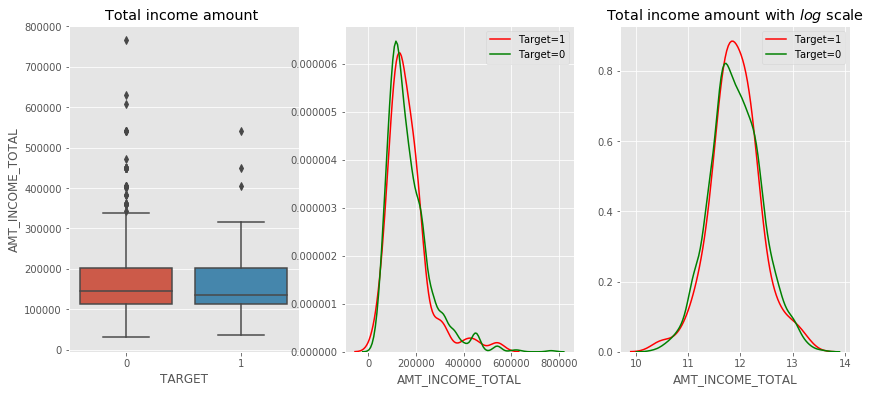

In [22]:
# Apply natural log on total income
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(131)
sns.boxplot(x ='TARGET', y='AMT_INCOME_TOTAL', data=app_train,ax=ax)
ax.set_title('Total income amount ')
ax = f.add_subplot(132)
sns.distplot((app_train[app_train['TARGET']==1]['AMT_INCOME_TOTAL'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot((app_train[app_train['TARGET']==0]['AMT_INCOME_TOTAL'])
             ,ax=ax,color='green',label='Target=0',hist=False)

ax = f.add_subplot(1,3,3)
sns.distplot(np.log(app_train[app_train['TARGET']==1]['AMT_INCOME_TOTAL'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot(np.log(app_train[app_train['TARGET']==0]['AMT_INCOME_TOTAL'])
             ,ax=ax,color='green',label='Target=0',hist=False)
ax.set_title('Total income amount with $log$ scale')
plt.legend()

In [23]:
print('Default',app_train[app_train['AMT_INCOME_TOTAL'] >0.2e8]['AMT_INCOME_TOTAL'])

# apply log on feature 
app_train['AMT_INCOME_TOTAL'] = np.log(app_train['AMT_INCOME_TOTAL'])
app_test['AMT_INCOME_TOTAL'] = np.log(app_test['AMT_INCOME_TOTAL'])

Default Series([], Name: AMT_INCOME_TOTAL, dtype: float64)


Their are many high income peolple's loans are not payed in time 

### 2.7 Credit amount

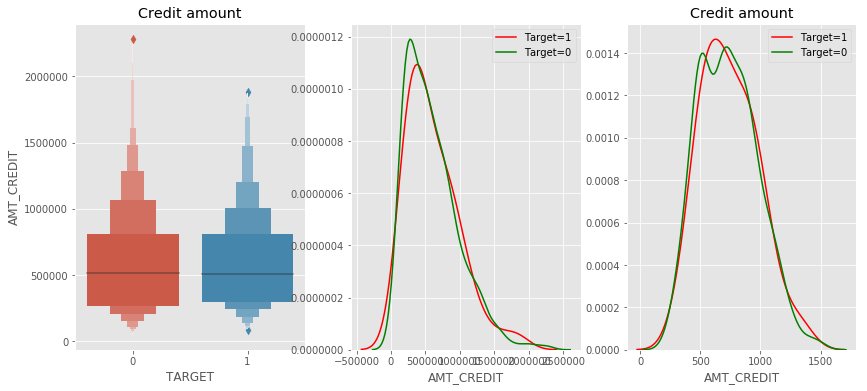

In [24]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(131)
sns.boxenplot(x ='TARGET', y='AMT_CREDIT', data=app_train,ax=ax)
ax.set_title('Credit amount')
ax = f.add_subplot(132)
sns.distplot((app_train[app_train['TARGET']==1]['AMT_CREDIT'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot((app_train[app_train['TARGET']==0]['AMT_CREDIT'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax = f.add_subplot(133)
sns.distplot(np.sqrt(app_train[app_train['TARGET']==1]['AMT_CREDIT'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot(np.sqrt(app_train[app_train['TARGET']==0]['AMT_CREDIT'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Credit amount')
plt.legend()

In [25]:
# apply square root on feature
app_train['AMT_CREDIT'] = np.sqrt(app_train['AMT_CREDIT'])
app_test['AMT_CREDIT'] = np.sqrt(app_test['AMT_CREDIT'])

### 2.8 Annuity amount
An annuity loan is paid back in instalments of the same size consisting of a loan repayment portion and an interest portion. The size of the instalment changes in line with changes in interest rates, but the loan period remains unchanged.

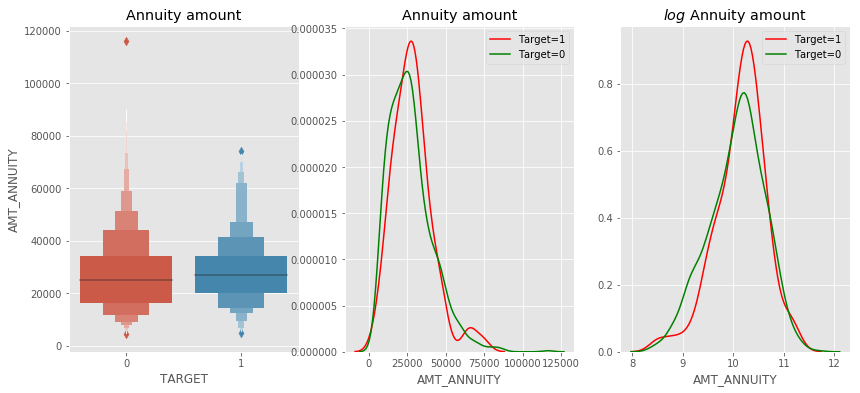

In [26]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(131)
sns.boxenplot(x ='TARGET', y='AMT_ANNUITY', data=app_train,ax=ax)
ax.set_title('Annuity amount')
ax = f.add_subplot(132)
sns.distplot((app_train[app_train['TARGET']==1]['AMT_ANNUITY'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot((app_train[app_train['TARGET']==0]['AMT_ANNUITY'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Annuity amount')
ax = f.add_subplot(133)
sns.distplot(np.log(app_train[app_train['TARGET']==1]['AMT_ANNUITY'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot(np.log(app_train[app_train['TARGET']==0]['AMT_ANNUITY'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('$log$ Annuity amount')
plt.legend()

In [27]:
# apply log on feature
app_train['AMT_ANNUITY'] = np.log(app_train['AMT_ANNUITY'])
app_test['AMT_ANNUITY'] = np.log(app_test['AMT_ANNUITY'])

### 2.9 Goods price amount
For consumer loans it is the price of the goods for which the loan is given

/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


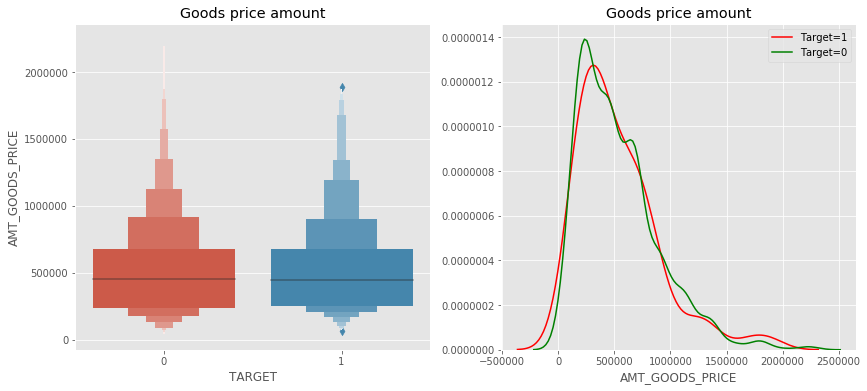

In [28]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.boxenplot(x ='TARGET', y='AMT_GOODS_PRICE', data=app_train,ax=ax)
ax.set_title('Goods price amount')
ax = f.add_subplot(122)
sns.distplot((app_train[app_train['TARGET']==1]['AMT_GOODS_PRICE'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot((app_train[app_train['TARGET']==0]['AMT_GOODS_PRICE'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Goods price amount')
plt.legend()

### 2.10 Personal information

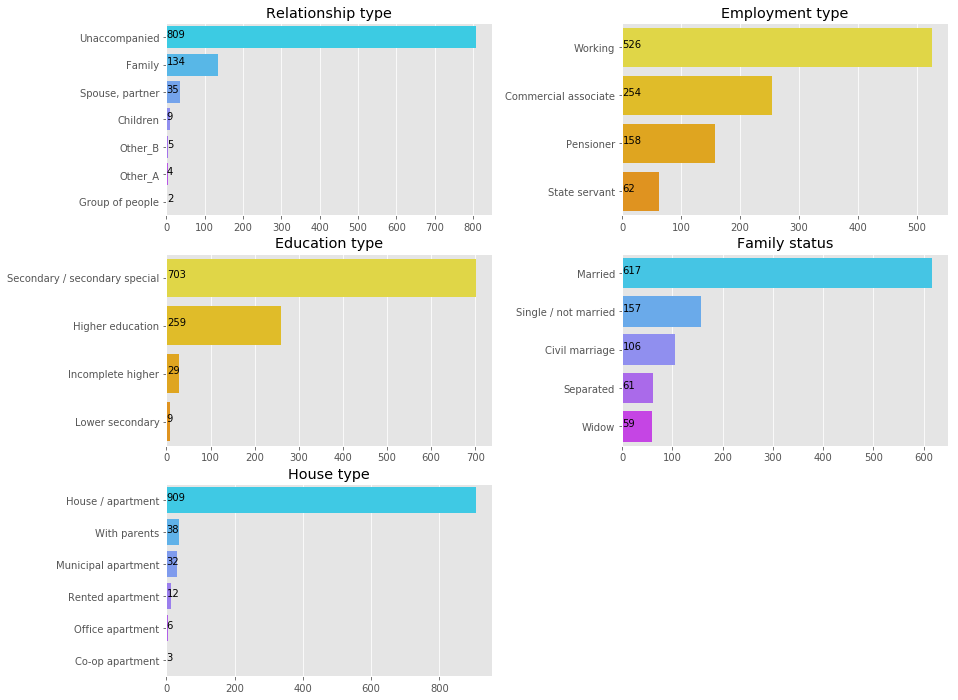

In [29]:
f = plt.figure(figsize= (14,12))
#plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))

ax= f.add_subplot(321)
tmp = app_train['NAME_TYPE_SUITE'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='cool')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('Relationship type')

ax = f.add_subplot(322)
tmp = app_train['NAME_INCOME_TYPE'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='Wistia')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('Employment type')

ax = f.add_subplot(323)
tmp = app_train['NAME_EDUCATION_TYPE'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='Wistia')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('Education type')

ax = f.add_subplot(324)
tmp = app_train['NAME_FAMILY_STATUS'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='cool')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('Family status')

ax = f.add_subplot(325)
tmp = app_train['NAME_HOUSING_TYPE'].value_counts()
sns.barplot(tmp.values,tmp.index,palette='cool')
for i, v in enumerate(tmp.values):
    ax.text(0.8,i,v,color='k',fontsize=10)
ax.set_title('House type')

plt.subplots_adjust(wspace=0.4)

In [30]:
# convert to categorical type
app_train[['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
           'NAME_HOUSING_TYPE']] = app_train[['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']].astype('object')

app_test[['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
           'NAME_HOUSING_TYPE']] = app_test[['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']].astype('object')

### 2.11 Region population

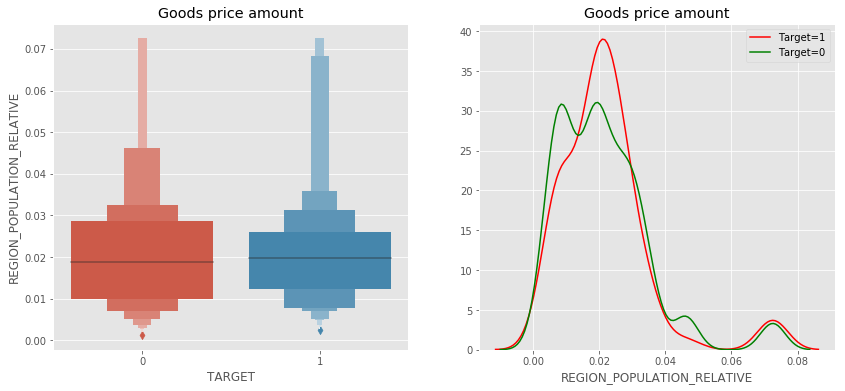

In [31]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.boxenplot(x ='TARGET', y='REGION_POPULATION_RELATIVE', data=app_train,ax=ax)
ax.set_title('Goods price amount')
ax = f.add_subplot(122)
sns.distplot((app_train[app_train['TARGET']==1]['REGION_POPULATION_RELATIVE'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot((app_train[app_train['TARGET']==0]['REGION_POPULATION_RELATIVE'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Goods price amount')
plt.legend();

### 2.12 Birth days

In [32]:
(app_train['DAYS_BIRTH']/-365).describe()

count    1000.000000
mean       43.486981
std        11.605080
min        21.109589
25%        33.771233
50%        43.131507
75%        52.682192
max        68.778082
Name: DAYS_BIRTH, dtype: float64

Text(0.5,1,'Age in years')

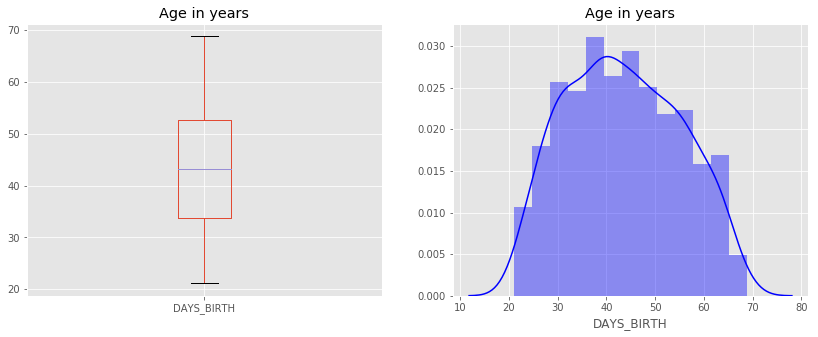

In [33]:
f = plt.figure(figsize= (14,5))
ax = f.add_subplot(121)
(app_train['DAYS_BIRTH']/-365).plot(kind='box',ax=ax)
ax.set_title('Age in years')
ax = f.add_subplot(122)
sns.distplot(app_train['DAYS_BIRTH']/-365,color='blue')
ax.set_title('Age in years')

### 2.13 Number of days employed
How many days before the application the person started current employment

In [34]:
print('missing value:',app_train['DAYS_EMPLOYED'].isnull().sum())
(app_train['DAYS_EMPLOYED']/-365).describe()

missing value: 0


count    1000.000000
mean     -152.695633
std       367.559201
min     -1000.665753
25%         0.832877
50%         3.471233
75%         7.463014
max        42.827397
Name: DAYS_EMPLOYED, dtype: float64

In [35]:
((app_train['DAYS_EMPLOYED']/-365)[(app_train['DAYS_EMPLOYED']/-365)<0][:5],
app_train['DAYS_EMPLOYED'][app_train['DAYS_EMPLOYED']>0][:5],
app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED']>0][:5])

(8    -1000.665753
 11   -1000.665753
 23   -1000.665753
 38   -1000.665753
 43   -1000.665753
 Name: DAYS_EMPLOYED, dtype: float64, 8     365243
 11    365243
 23    365243
 38    365243
 43    365243
 Name: DAYS_EMPLOYED, dtype: int64, 10    365243
 17    365243
 22    365243
 26    365243
 36    365243
 Name: DAYS_EMPLOYED, dtype: int64)

In [36]:
# fill missing value
app_train['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)
app_test['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

Text(0.5,1,'Employed in years')

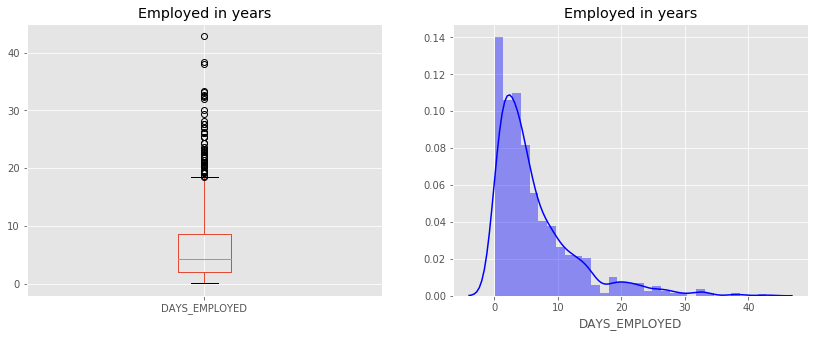

In [37]:
f = plt.figure(figsize= (14,5))
ax = f.add_subplot(121)
(app_train['DAYS_EMPLOYED']/-365).plot(kind='box',ax=ax)
ax.set_title('Employed in years')
ax = f.add_subplot(122)
sns.distplot((app_train['DAYS_EMPLOYED'].dropna()/-365),color='blue')
ax.set_title('Employed in years')

### 2.14 Redistration days
How many days before the application did client change his registration

In [38]:
(app_train['DAYS_REGISTRATION']/-365).describe()

count    1000.000000
mean       13.389099
std         9.662337
min         0.008219
25%         5.113699
50%        12.335616
75%        19.790411
max        47.391781
Name: DAYS_REGISTRATION, dtype: float64

Text(0.5,1,'Registration in years')

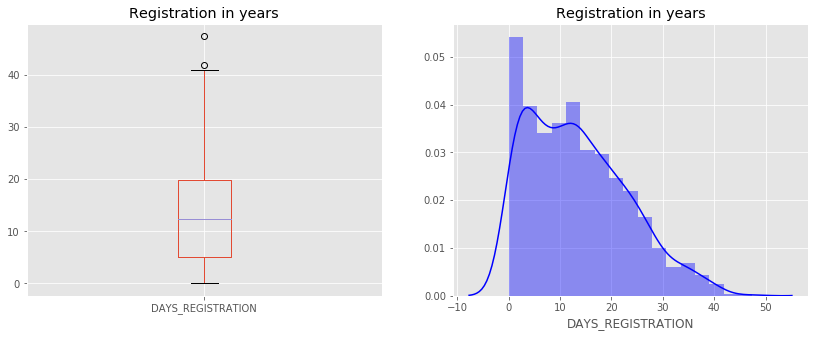

In [39]:
f = plt.figure(figsize= (14,5))
ax = f.add_subplot(121)
(app_train['DAYS_REGISTRATION']/-365).plot(kind='box',ax=ax)
ax.set_title('Registration in years')
ax = f.add_subplot(122)
sns.distplot((app_train['DAYS_REGISTRATION'].dropna()/-365),color='blue')
ax.set_title('Registration in years')

### 2.15 Publish id days
How many days before the application did client change the identity document with which he applied for the loan

In [40]:
(app_train['DAYS_ID_PUBLISH']/-365).describe()

count    1000.000000
mean        8.041375
std         4.149993
min         0.002740
25%         4.388356
50%         8.668493
75%        11.663699
max        17.049315
Name: DAYS_ID_PUBLISH, dtype: float64

Text(0.5,1,'Publish id in years')

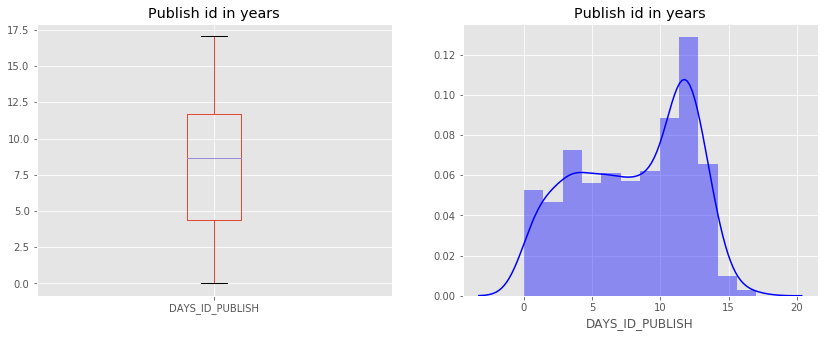

In [41]:
f = plt.figure(figsize= (14,5))
ax = f.add_subplot(121)
(app_train['DAYS_ID_PUBLISH']/-365).plot(kind='box',ax=ax)
ax.set_title('Publish id in years')
ax = f.add_subplot(122)
sns.distplot((app_train['DAYS_ID_PUBLISH'].dropna()/-365),color='blue')
ax.set_title('Publish id in years')

### 2.16 Own car age
Age of client's car

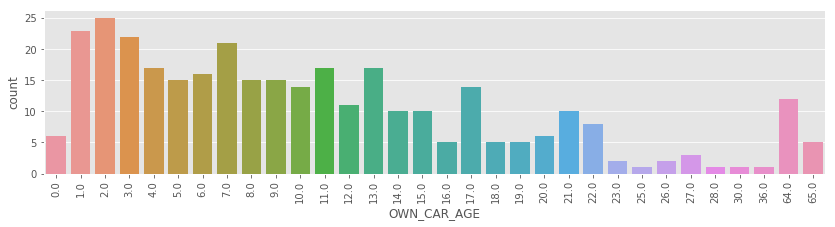

In [42]:
plt.figure(figsize= (14,3))
sns.countplot(app_train['OWN_CAR_AGE'])
#plt.title('Count plot of Own car age')
plt.xticks(rotation=90);

In [43]:
app_train['OWN_CAR_AGE'] = app_train['OWN_CAR_AGE'].astype('object')
app_test['OWN_CAR_AGE'] = app_test['OWN_CAR_AGE'].astype('object')

### 2.17 Communication availablity

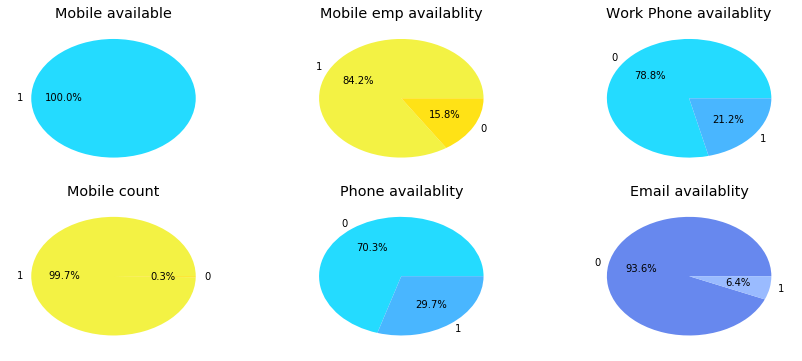

In [44]:
f = plt.figure(figsize= (14,6))

ax= f.add_subplot(231)
tmp = app_train['FLAG_MOBIL'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('Mobile available')

ax = f.add_subplot(232)
tmp = app_train['FLAG_EMP_PHONE'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('Wistia'))
ax.set_title('Mobile emp availablity')

ax = f.add_subplot(233)
tmp = app_train['FLAG_WORK_PHONE'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('Work Phone availablity')

ax = f.add_subplot(234)
tmp = app_train['FLAG_CONT_MOBILE'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('Wistia'))
ax.set_title('Mobile count')

ax = f.add_subplot(235)
tmp = app_train['FLAG_PHONE'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('Phone availablity')

ax = f.add_subplot(236)
tmp = app_train['FLAG_EMAIL'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('coolwarm'))
ax.set_title('Email availablity')

plt.subplots_adjust(wspace=0.4)

In [45]:
# drop few columns
app_train_col_drop.append('FLAG_MOBIL')
app_train_col_drop.append('FLAG_CONT_MOBILE')
app_train_col_drop.append('FLAG_EMAIL')

# convert to category
app_train[['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']] = app_train[[
    'FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']].astype('object')
app_test[['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']] = app_test[[
    'FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']].astype('object')

### 2.18 Family members count
How many family members does client have

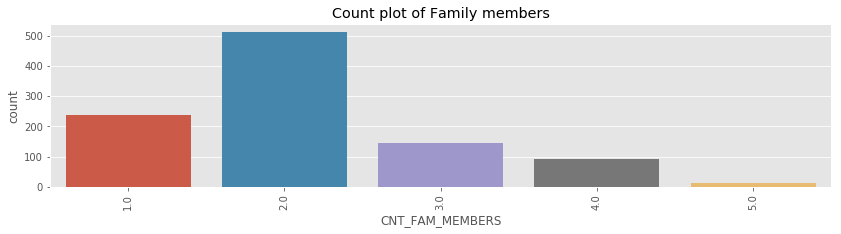

In [46]:
plt.figure(figsize= (14,3))
sns.countplot(app_train['CNT_FAM_MEMBERS'])
plt.title('Count plot of Family members')
plt.xticks(rotation=90);

In [47]:
# convert to category
app_train['CNT_FAM_MEMBERS'] = app_train['CNT_FAM_MEMBERS'].astype('object')
app_test['CNT_FAM_MEMBERS'] = app_test['CNT_FAM_MEMBERS'].astype('object')

### 2.19 Region rating client
Our rating of the region where client lives (1,2,3)

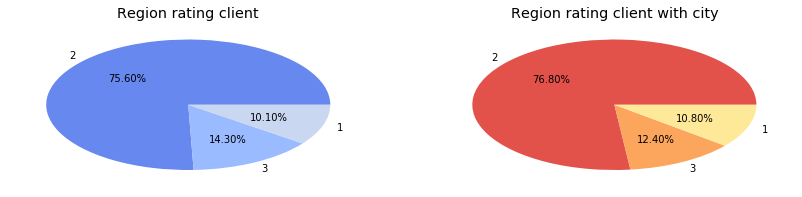

In [48]:
f = plt.figure(figsize= (14,3))

ax = f.add_subplot(121)
tmp = app_train['REGION_RATING_CLIENT'].value_counts()
ax.pie(tmp.values, labels= tmp.index, autopct= '%1.2f%%',colors=sns.color_palette('coolwarm'))
ax.set_title('Region rating client')

ax = f.add_subplot(122)
tmp = app_train['REGION_RATING_CLIENT_W_CITY'].value_counts()
ax.pie(tmp.values, labels= tmp.index, autopct= '%1.2f%%',colors=sns.color_palette('Spectral'))
ax.set_title('Region rating client with city');

In [49]:
# convert to category
app_train[['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']] = app_train[[
    'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']].astype('object')

app_test[['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']] = app_test[[
    'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']].astype('object')

### 2.20 Weekday apply for loan
On which day of the week did the client apply for the loan

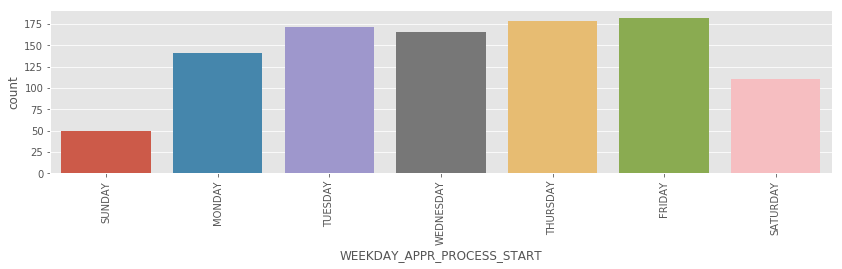

In [50]:
plt.figure(figsize= (14,3))
sns.countplot(app_train['WEEKDAY_APPR_PROCESS_START'],
              order=['SUNDAY','MONDAY','TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY','SATURDAY', ])
#plt.title('Count plot of Own car age')
plt.xticks(rotation=90);

In [51]:
# convert to category
app_train['WEEKDAY_APPR_PROCESS_START'] = app_train['WEEKDAY_APPR_PROCESS_START'].astype('object')
app_test['WEEKDAY_APPR_PROCESS_START'] = app_test['WEEKDAY_APPR_PROCESS_START'].astype('object')

### 2.21 Hour at loan apply start
Approximately at what hour did the client apply for the loan

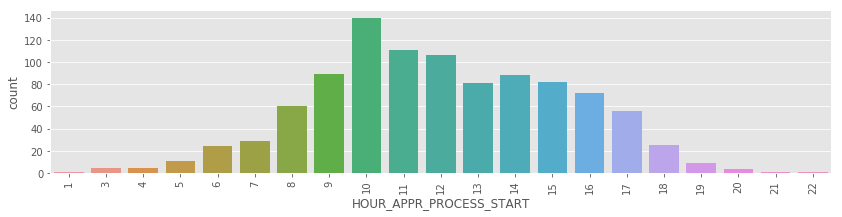

In [52]:
plt.figure(figsize= (14,3))
sns.countplot(app_train['HOUR_APPR_PROCESS_START'])
#plt.title('Count plot of Own car age')
plt.xticks(rotation=90);

In [53]:
# convert to category
app_train['HOUR_APPR_PROCESS_START'] = app_train['HOUR_APPR_PROCESS_START'].astype('object')
app_test['HOUR_APPR_PROCESS_START'] = app_test['HOUR_APPR_PROCESS_START'].astype('object')

### 2.22 Region type
Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)

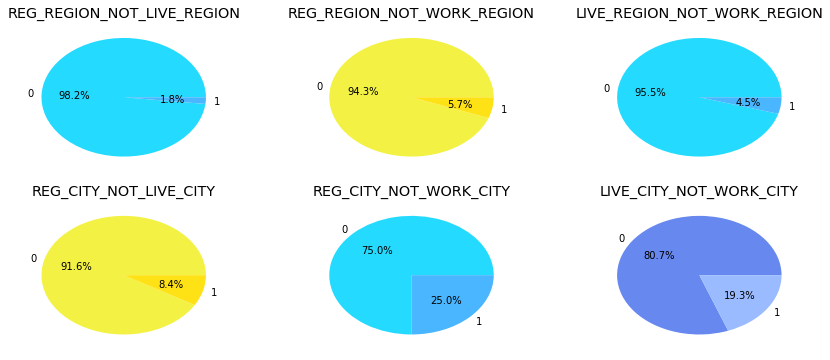

In [54]:
f = plt.figure(figsize= (14,6))

ax= f.add_subplot(231)
tmp = app_train['REG_REGION_NOT_LIVE_REGION'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('REG_REGION_NOT_LIVE_REGION')

ax = f.add_subplot(232)
tmp = app_train['REG_REGION_NOT_WORK_REGION'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('Wistia'))
ax.set_title('REG_REGION_NOT_WORK_REGION')

ax = f.add_subplot(233)
tmp = app_train['LIVE_REGION_NOT_WORK_REGION'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('LIVE_REGION_NOT_WORK_REGION')

ax = f.add_subplot(234)
tmp = app_train['REG_CITY_NOT_LIVE_CITY'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('Wistia'))
ax.set_title('REG_CITY_NOT_LIVE_CITY')

ax = f.add_subplot(235)
tmp = app_train['REG_CITY_NOT_WORK_CITY'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('cool'))
ax.set_title('REG_CITY_NOT_WORK_CITY')

ax = f.add_subplot(236)
tmp = app_train['LIVE_CITY_NOT_WORK_CITY'].value_counts()
plt.pie(tmp.values,labels=tmp.index,autopct='%1.1f%%',colors=sns.color_palette('coolwarm'))
ax.set_title('LIVE_CITY_NOT_WORK_CITY')

plt.subplots_adjust(wspace=0.4)

In [55]:
# drop a feature
app_train_col_drop.append('REG_REGION_NOT_LIVE_REGION')

# convert to category
app_train[['REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']] = app_train[['REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']].astype('object')

app_test[['REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']] = app_test[['REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']].astype('object')

### 2.23 Organization type

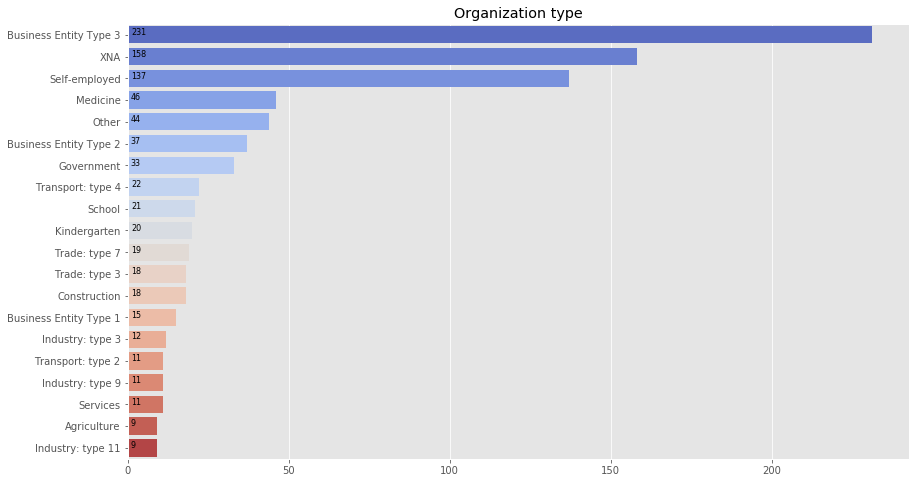

In [56]:
plt.figure(figsize=(14,8))
tmp = app_train['ORGANIZATION_TYPE'].value_counts()[:20]
sns.barplot(tmp.values, tmp.index, palette='coolwarm')
plt.title('Organization type')
for i,v in enumerate(tmp.values):
    plt.text(1,i,v,fontsize=8,color='k')

In [57]:
# XNA is missing value in dataset
app_train['ORGANIZATION_TYPE'].replace('XNA',np.nan,inplace=True)
app_test['ORGANIZATION_TYPE'].replace('XNA',np.nan,inplace=True)

# convert to category
app_train['ORGANIZATION_TYPE'] = app_train['ORGANIZATION_TYPE'].astype('object')
app_test['ORGANIZATION_TYPE'] = app_test['ORGANIZATION_TYPE'].astype('object')

### 2.24 External data source
Normalized score from external data source

In [58]:
basic_details(app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']])

missing_value  %missing_value   dtypes  N unique
EXT_SOURCE_1            576            57.6  float64       424
EXT_SOURCE_2              3             0.3  float64       983
EXT_SOURCE_3            209            20.9  float64       368

/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


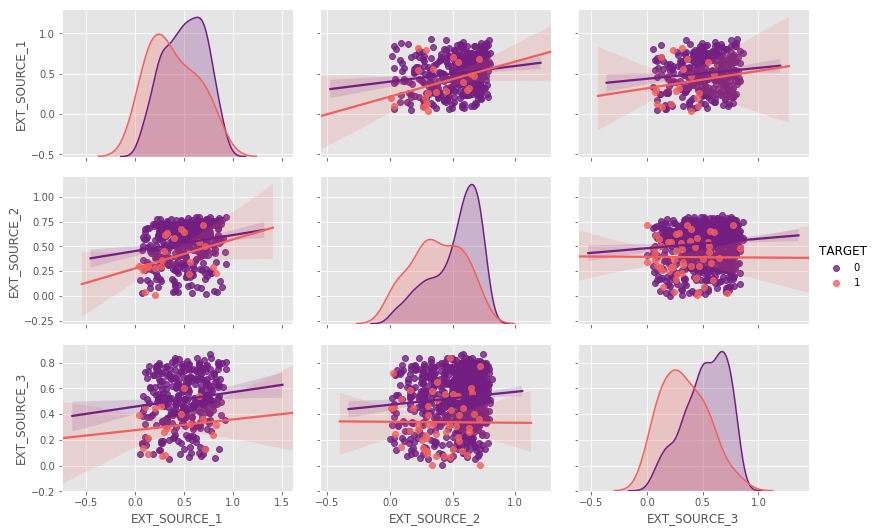

In [59]:
g = sns.pairplot(app_train,vars =['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],
                palette='magma',hue='TARGET',kind='reg',aspect=1.5)


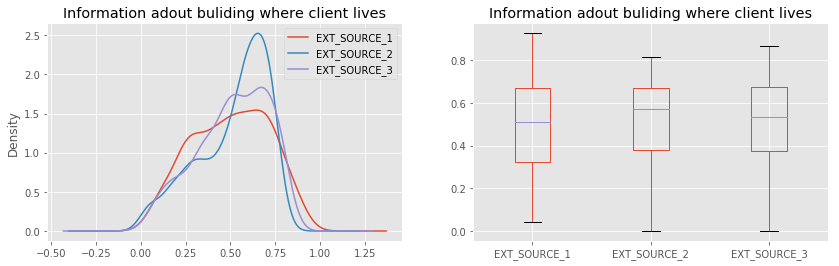

In [60]:
F = plt.figure(figsize=(14,4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].plot(kind='box',ax=ax)

### 2.25 Information adout buliding in client lives
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

In [61]:
basic_details(app_test[['APARTMENTS_AVG','BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG', 
           'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']]
)

missing_value  %missing_value   dtypes  N unique
APARTMENTS_AVG                       23887           49.01  float64      1543
BASEMENTAREA_AVG                     27641           56.71  float64      2816
YEARS_BEGINEXPLUATATION_AVG          22856           46.89  float64       175
YEARS_BUILD_AVG                      31818           65.28  float64       130
COMMONAREA_AVG                       33495           68.72  float64      2042
ELEVATORS_AVG                        25189           51.68  float64       181
ENTRANCES_AVG                        23579           48.37  float64       200
FLOORSMAX_AVG                        23321           47.84  float64       252
FLOORSMIN_AVG                        32466           66.61  float64       198
LANDAREA_AVG                         28254           57.96  float64      2540
LIVINGAPARTMENTS_AVG                 32780           67.25  float64      1211
LIVINGAREA_AVG                       23552           48.32  float64      3848
NONLIVINGAPARTMENTS_AVG              33347           68.41  float64       241
NONLIVINGAREA_AVG                    26084           53.51  float64      2026

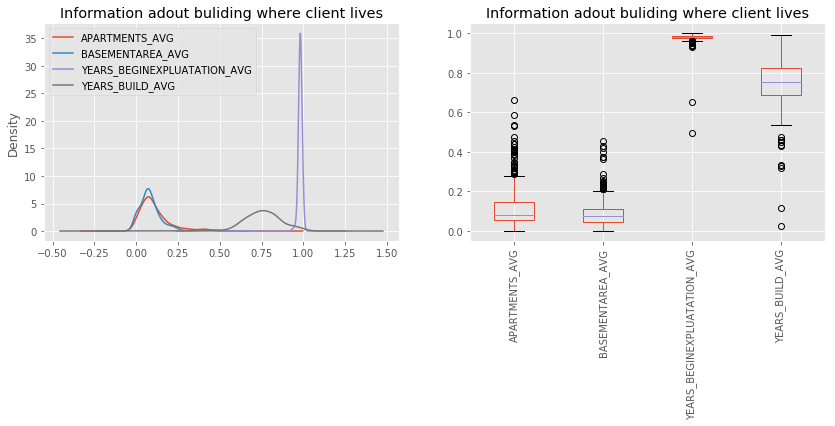

In [62]:
F = plt.figure(figsize=(14,4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['APARTMENTS_AVG','BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG']].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['APARTMENTS_AVG','BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG']].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

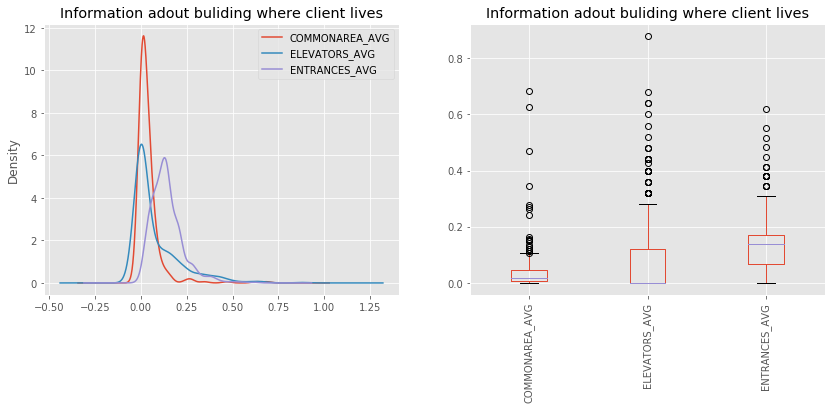

In [63]:
F = plt.figure(figsize=(14,5))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG',]].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG',]].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

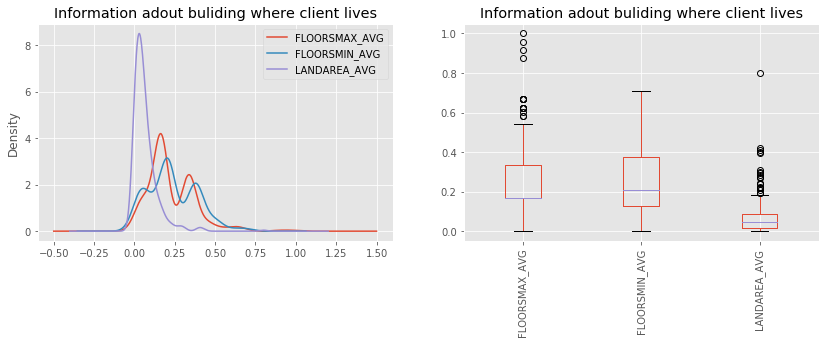

In [64]:
F = plt.figure(figsize=(14,4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG']].plot(kind='kde',ax=ax)
ax = F.add_subplot(122)

plt.title('Information adout buliding where client lives')
app_train[['FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG']].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

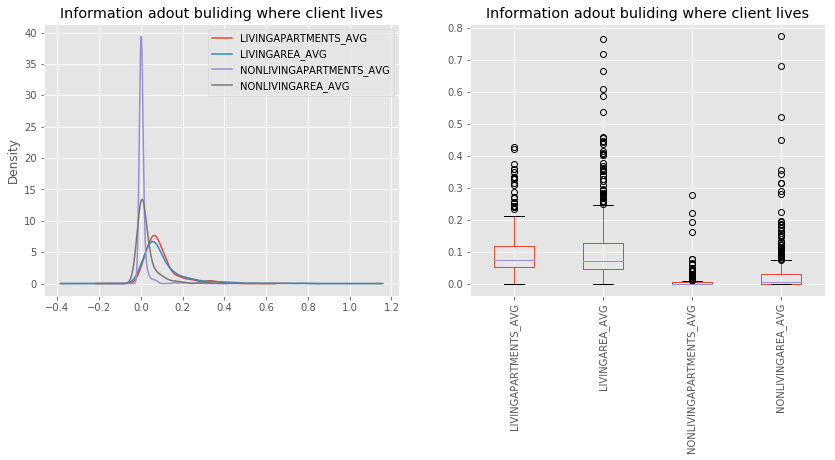

In [65]:
F = plt.figure(figsize=(14,5))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

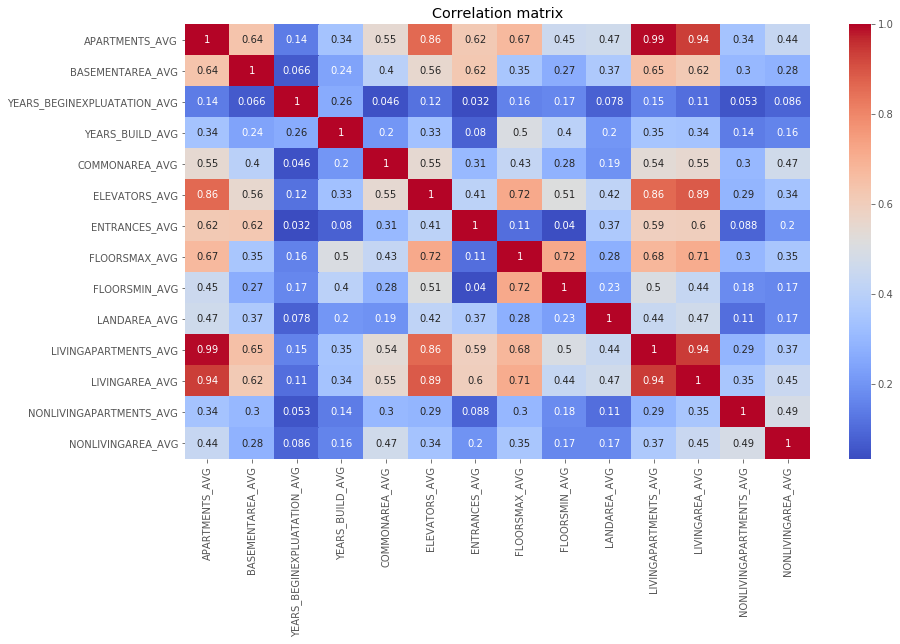

In [66]:
plt.figure(figsize= (14,8))
plt.title('Correlation matrix')
sns.heatmap(app_train[['APARTMENTS_AVG','BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG', 
           'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']].corr(),
           annot=True, cmap = 'coolwarm');

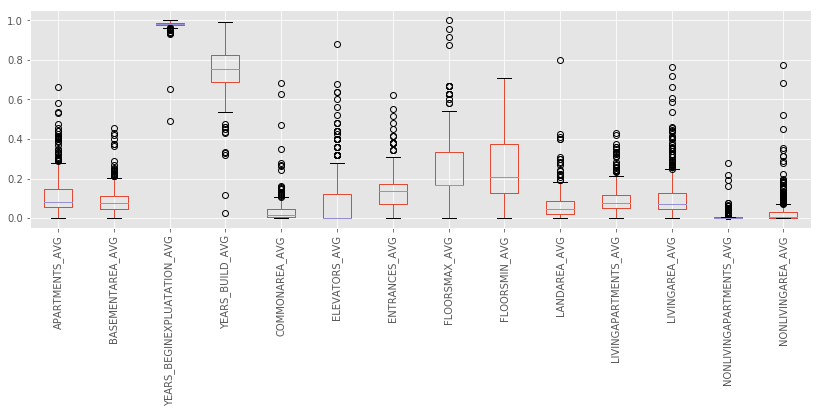

In [67]:
(app_train[['APARTMENTS_AVG','BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG', 
           'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']]
.plot(kind='box',figsize=(14,4)))
plt.xticks(rotation=90);

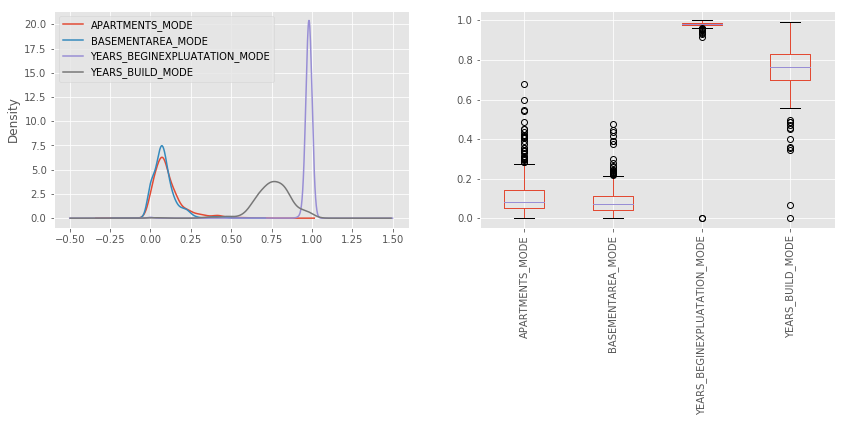

In [68]:
F = plt.figure(figsize=(14,4))
ax = F.add_subplot(121)
app_train[['APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE']].plot(kind='kde',ax=ax)
ax = F.add_subplot(122)
app_train[['APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE']].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

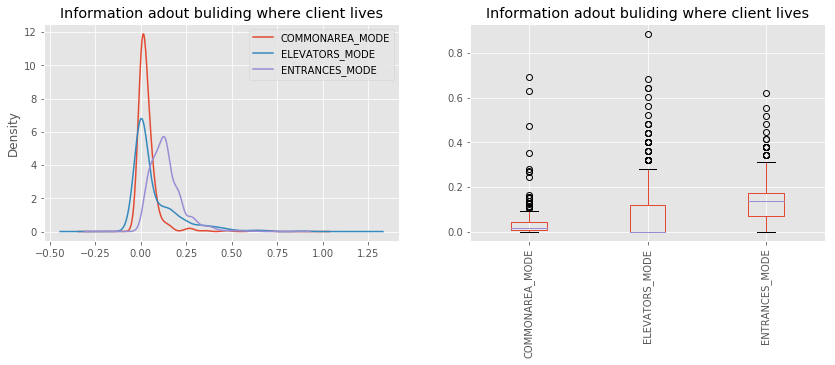

In [69]:
F = plt.figure(figsize=(14, 4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',]].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',]].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

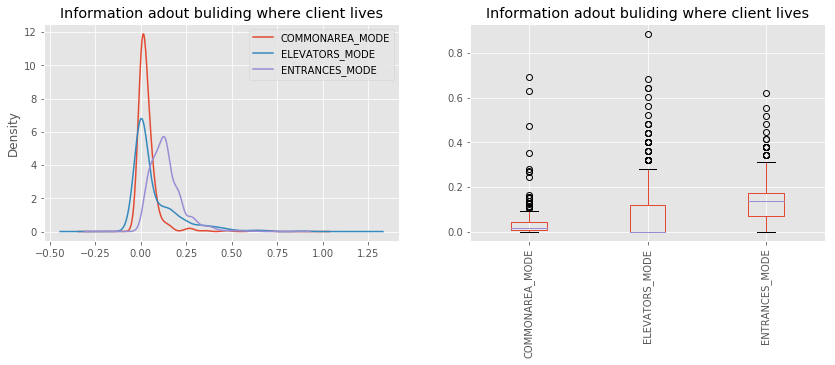

In [70]:
F = plt.figure(figsize=(14, 4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',]].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',]].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

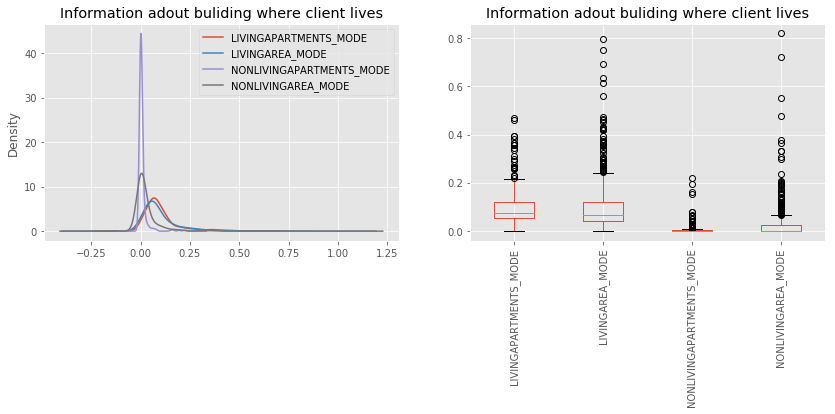

In [71]:
F = plt.figure(figsize=(14, 4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE']].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE']].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

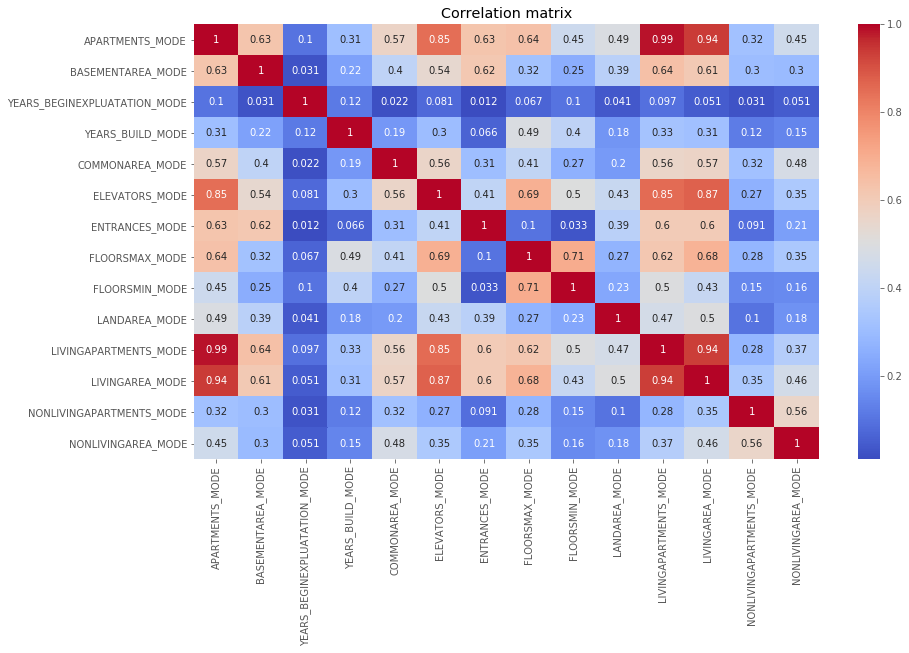

In [72]:
plt.figure(figsize= (14,8))
plt.title('Correlation matrix')
sns.heatmap(app_train[['APARTMENTS_MODE', 'BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE','FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE']].corr(),
           annot=True, cmap = 'coolwarm');

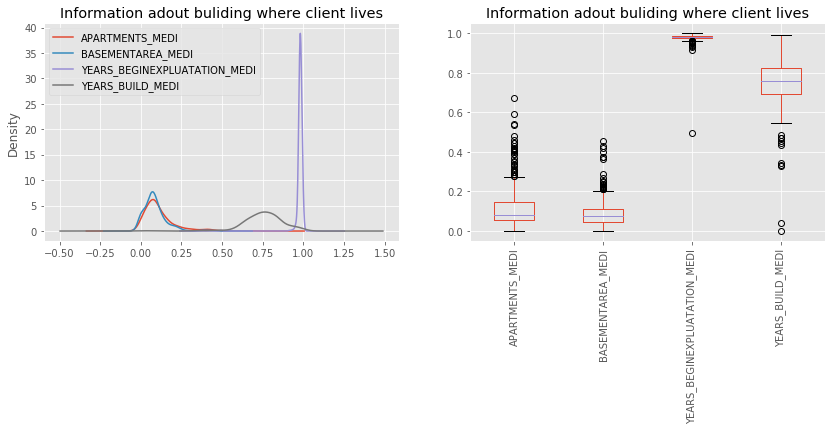

In [73]:
F = plt.figure(figsize=(14, 4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['APARTMENTS_MEDI','BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI',]].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['APARTMENTS_MEDI','BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI']].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

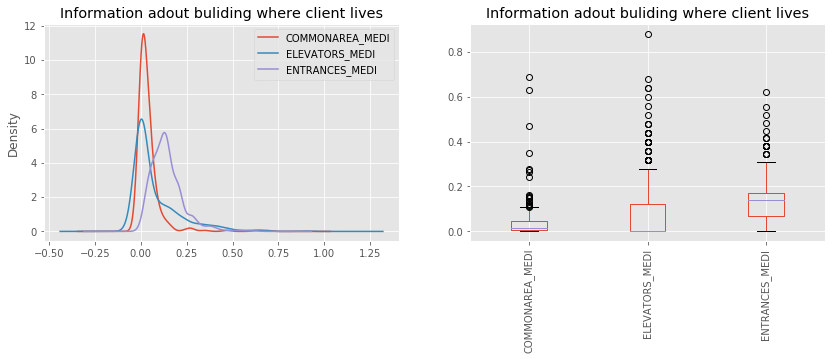

In [74]:
F = plt.figure(figsize=(14, 4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',]].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI']].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

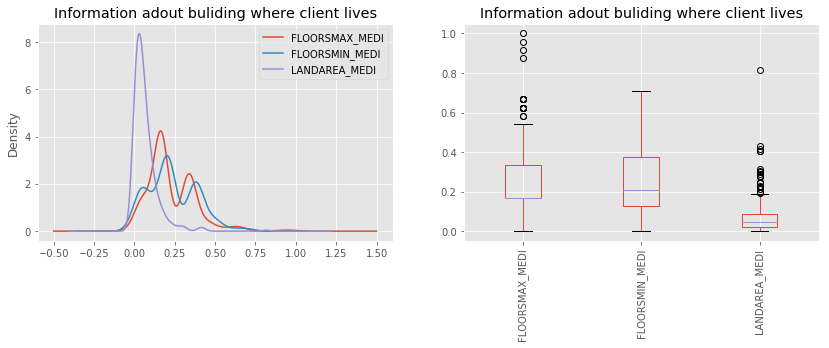

In [75]:
F = plt.figure(figsize=(14, 4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['FLOORSMAX_MEDI', 'FLOORSMIN_MEDI','LANDAREA_MEDI',]].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['FLOORSMAX_MEDI', 'FLOORSMIN_MEDI','LANDAREA_MEDI',]].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

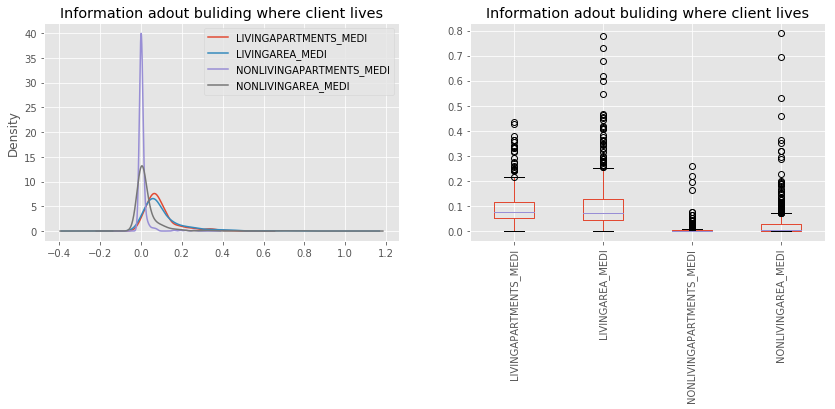

In [76]:
F = plt.figure(figsize=(14, 4))
ax = F.add_subplot(121)
plt.title('Information adout buliding where client lives')
app_train[['LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']].plot(kind='kde',ax=ax)

ax = F.add_subplot(122)
plt.title('Information adout buliding where client lives')
app_train[['LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']].plot(kind='box',ax=ax)
plt.xticks(rotation=90);

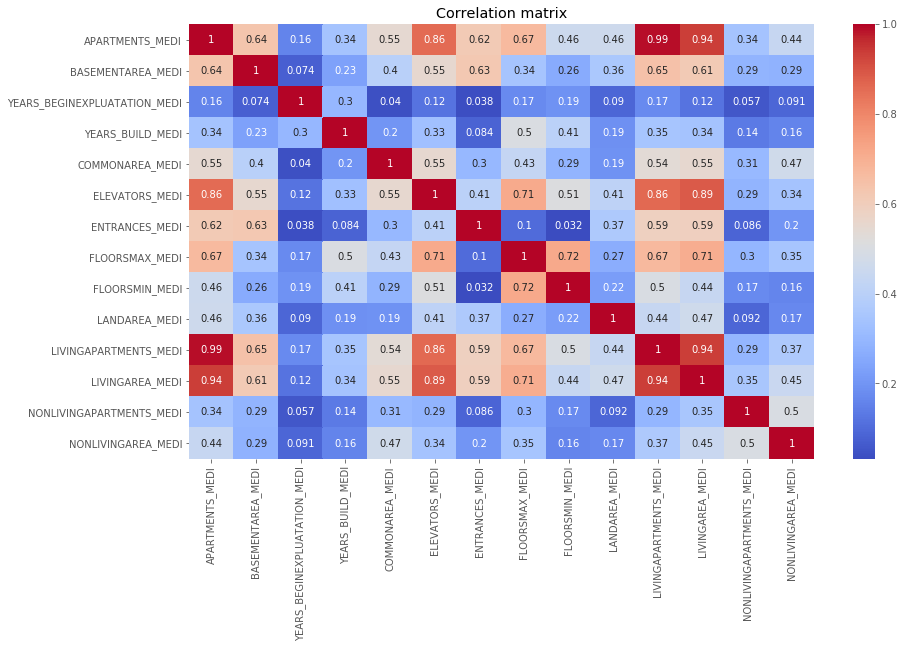

In [77]:
plt.figure(figsize= (14,8))
plt.title('Correlation matrix')
sns.heatmap(app_train[['APARTMENTS_MEDI','BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI','ENTRANCES_MEDI', 
        'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI','LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 
        'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',]].corr(),
           annot=True, cmap = 'coolwarm');

### 2.26 Total area
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor.

/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/sudhir/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


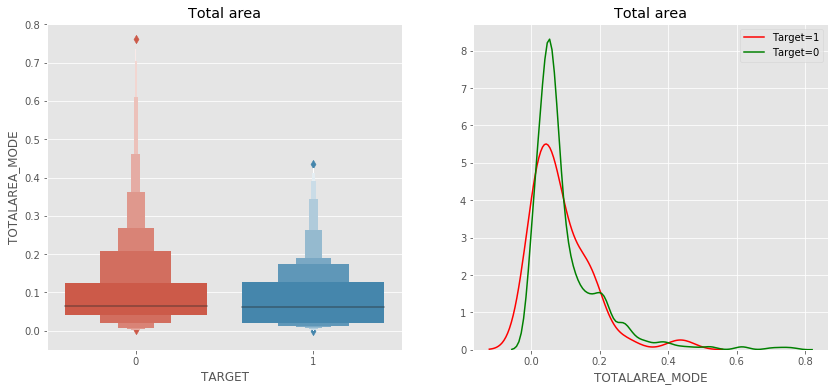

In [78]:
f= plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.boxenplot(x ='TARGET', y='TOTALAREA_MODE', data=app_train,ax=ax)
ax.set_title('Total area')
ax = f.add_subplot(122)
sns.distplot((app_train[app_train['TARGET']==1]['TOTALAREA_MODE'])
             ,ax=ax,color='red',label='Target=1',hist=False)
sns.distplot((app_train[app_train['TARGET']==0]['TOTALAREA_MODE'])
             ,ax=ax,color='green',label='Target=0', hist=False)
ax.set_title('Total area')
plt.legend();

In [79]:
basic_details(app_train[['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']])

missing_value  %missing_value  dtypes  N unique
FONDKAPREMONT_MODE             680            68.0  object         4
HOUSETYPE_MODE                 486            48.6  object         3
WALLSMATERIAL_MODE             494            49.4  object         7
EMERGENCYSTATE_MODE            462            46.2  object         2

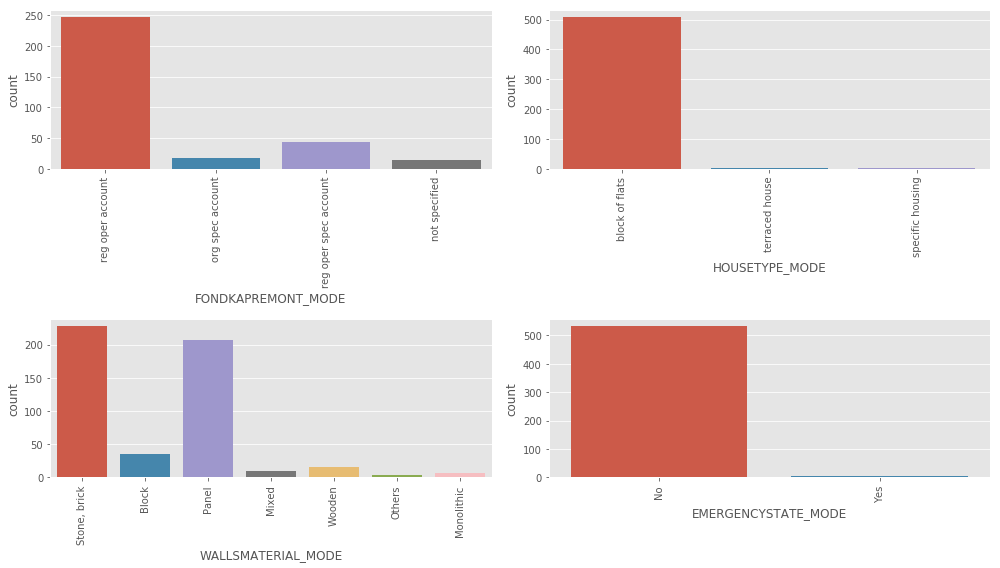

In [80]:
f = plt.figure(figsize= (14,8))
ax = f.add_subplot(221)
sns.countplot(app_train['FONDKAPREMONT_MODE'],ax=ax)
plt.xticks(rotation=90)
#plt.title('FONDKAPREMONT_MODE')

ax = f.add_subplot(222)
sns.countplot(app_train['HOUSETYPE_MODE'],ax=ax)
plt.xticks(rotation=90)
#plt.title('HOUSETYPE_MODE')

ax = f.add_subplot(223)
sns.countplot(app_train['WALLSMATERIAL_MODE'],ax=ax)
plt.xticks(rotation=90)
#plt.title('WALLSMATERIAL_MODE')

ax = f.add_subplot(224)
sns.countplot(app_train['EMERGENCYSTATE_MODE'],ax=ax)
plt.xticks(rotation=90)
#plt.title('EMERGENCYSTATE_MODE')

plt.tight_layout()

In [81]:
app_train[['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']] = app_train[['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']].astype('object')

app_test[['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']] = app_test[['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']].astype('object')

### 2.27 Observation of client social surrroundings

In [82]:
basic_details(app_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE',]])

missing_value  %missing_value   dtypes  N unique
OBS_30_CNT_SOCIAL_CIRCLE              4             0.4  float64        15
DEF_30_CNT_SOCIAL_CIRCLE              4             0.4  float64         5
OBS_60_CNT_SOCIAL_CIRCLE              4             0.4  float64        15
DEF_60_CNT_SOCIAL_CIRCLE              4             0.4  float64         4
DAYS_LAST_PHONE_CHANGE                0             0.0  float64       737

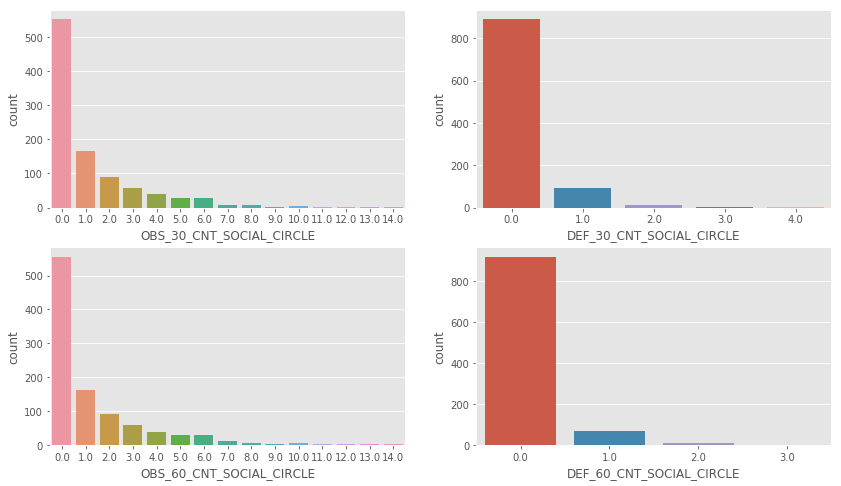

In [83]:
f = plt.figure(figsize= (14,8))
ax = f.add_subplot(221)
sns.countplot(app_train['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax)

ax = f.add_subplot(222)
sns.countplot(app_train['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax)

ax = f.add_subplot(223)
sns.countplot(app_train['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax)

ax = f.add_subplot(224)
sns.countplot(app_train['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax)

In [84]:
# convert to category
app_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',]] = app_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',]].astype('object')

app_test[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',]] = app_test[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',]].astype('object')

### 2.28 Days last phone change
How many days before application did client change phone

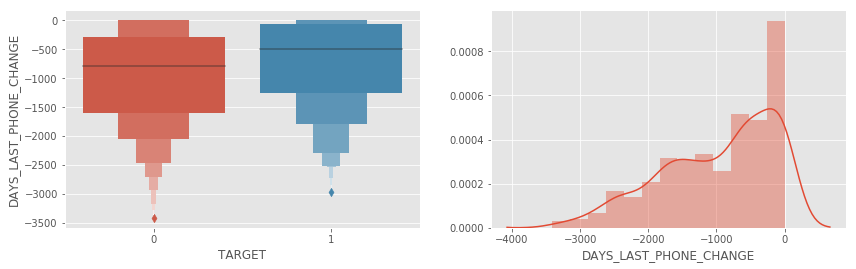

In [85]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.boxenplot(x = 'TARGET',y ='DAYS_LAST_PHONE_CHANGE', data=app_train)

ax = f.add_subplot(122)
sns.distplot(app_train['DAYS_LAST_PHONE_CHANGE'].dropna())

### 2.29 Flag document

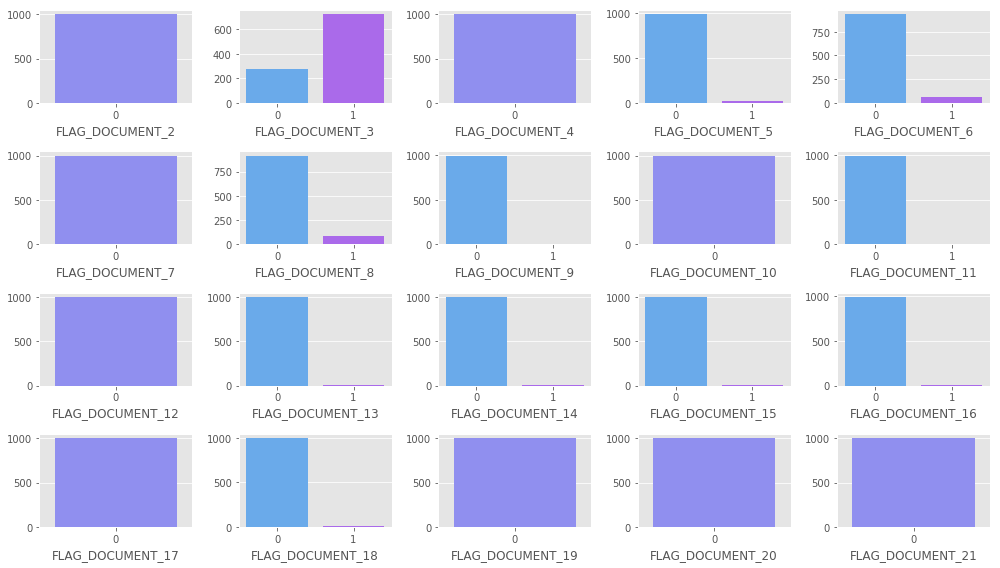

In [86]:
flag_col = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
        'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 
        'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',]

fig, ax = plt.subplots(4,5, figsize=(14,8),sharey=False)
axs = ax.ravel()
for i,c in enumerate(flag_col):
    sns.countplot(app_train[c],ax = axs[i],palette='cool')
    #axs[i].set_title(c)
    axs[i].set_ylabel('')
plt.tight_layout()

In [87]:
# we will keep FLAG_DOCUMENT_3,FLAG_DOCUMENT_6, FLAG_DOCUMENT_8
app_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
        'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 
        'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',]]  = app_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
        'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 
        'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',]].astype('object')

app_test[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
        'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 
        'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',]]  = app_test[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
        'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 
        'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',]].astype('object')


app_train_col_drop.extend(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7',  'FLAG_DOCUMENT_9',
        'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
        'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'])

### 2.30 Number of enquiries to Credit Bureau about the client

In [88]:
basic_details(app_train[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']])

missing_value  %missing_value   dtypes  N unique
AMT_REQ_CREDIT_BUREAU_HOUR            144            14.4  float64         2
AMT_REQ_CREDIT_BUREAU_DAY             144            14.4  float64         3
AMT_REQ_CREDIT_BUREAU_WEEK            144            14.4  float64         3
AMT_REQ_CREDIT_BUREAU_MON             144            14.4  float64         9
AMT_REQ_CREDIT_BUREAU_QRT             144            14.4  float64         5
AMT_REQ_CREDIT_BUREAU_YEAR            144            14.4  float64        10

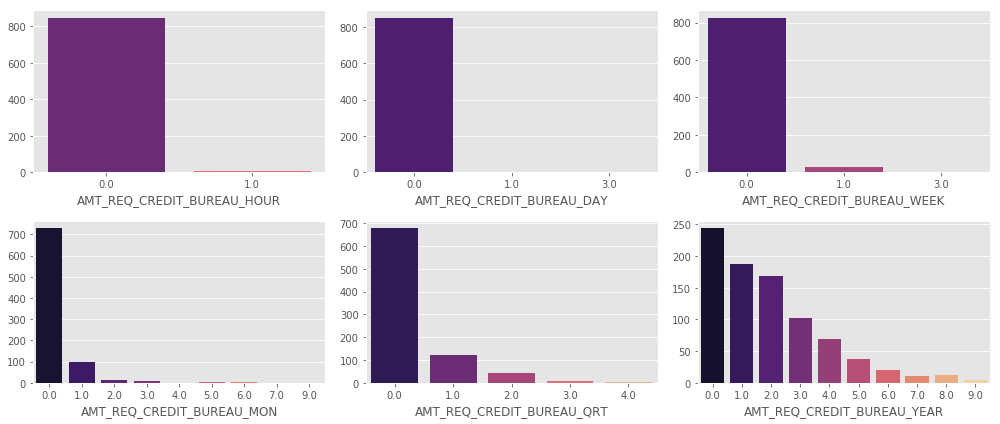

In [89]:
flag_col = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',]

fig, ax = plt.subplots(2,3, figsize=(14,6),sharey=False)
axs = ax.ravel()
for i,c in enumerate(flag_col):
    sns.countplot(app_train[c],ax = axs[i],palette='magma')
    #axs[i].set_title(c)
    axs[i].set_ylabel('')
plt.tight_layout()

In [90]:
app_train[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',]] = app_train[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',]].astype('object')

app_test[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',]] = app_test[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',]].astype('object')


In [91]:
gc.collect()

29630

***
***
***
## 3.0 Application train & application test data preprocessing
### 3.1 Merge application train and application test

In [92]:
#app_train['is_train'] = 'Yes'
#app_test['is_train'] = 'No'
train_test = pd.concat([app_train,app_test],axis=0,sort=False)
print('Number of rows and columns in train dataset: ',app_train.shape)
print('Number of rows and columns in test dataset: ',app_test.shape)
print('Number of rows and columns in train + test dataset: ',train_test.shape)
gc.collect()

Number of rows and columns in train dataset:  (1000, 122)
Number of rows and columns in test dataset:  (48744, 121)
Number of rows and columns in train + test dataset:  (49744, 122)


0

### 3.2 Column type segregation

In [93]:
# drop columns least significant
train_test = train_test.drop(list(set(app_train_col_drop)), axis=1)

categorical_col = train_test.select_dtypes('object').columns
numeric_col = train_test.select_dtypes('number').columns

# Int type
numeric_col = numeric_col.drop('TARGET') # Our dependent variable
gc.collect()

14


### 3.3 Basic details

In [94]:
# Check basic details
basic_details(train_test[categorical_col])

missing_value  %missing_value  dtypes  N unique
NAME_CONTRACT_TYPE                       0            0.00  object         2
CODE_GENDER                              0            0.00  object         2
FLAG_OWN_CAR                             0            0.00  object         2
FLAG_OWN_REALTY                          0            0.00  object         2
CNT_CHILDREN                             0            0.00  object        11
NAME_TYPE_SUITE                        913            1.84  object         7
NAME_INCOME_TYPE                         0            0.00  object         7
NAME_EDUCATION_TYPE                      0            0.00  object         5
NAME_FAMILY_STATUS                       0            0.00  object         5
NAME_HOUSING_TYPE                        0            0.00  object         6
OWN_CAR_AGE                          32977           66.29  object        53
FLAG_EMP_PHONE                           0            0.00  object         2
FLAG_WORK_PHONE                          0            0.00  object         2
FLAG_PHONE                               0            0.00  object         2
OCCUPATION_TYPE                      15891           31.95  object        18
CNT_FAM_MEMBERS                          0            0.00  object        12
REGION_RATING_CLIENT                     0            0.00  object         3
REGION_RATING_CLIENT_W_CITY              0            0.00  object         4
WEEKDAY_APPR_PROCESS_START               0            0.00  object         7
HOUR_APPR_PROCESS_START                  0            0.00  object        24
REG_REGION_NOT_WORK_REGION               0            0.00  object         2
LIVE_REGION_NOT_WORK_REGION              0            0.00  object         2
REG_CITY_NOT_LIVE_CITY                   0            0.00  object         2
REG_CITY_NOT_WORK_CITY                   0            0.00  object         2
LIVE_CITY_NOT_WORK_CITY                  0            0.00  object         2
ORGANIZATION_TYPE                     9432           18.96  object        57
FONDKAPREMONT_MODE                   33477           67.30  object         4
HOUSETYPE_MODE                       24105           48.46  object         3
WALLSMATERIAL_MODE                   24387           49.03  object         7
EMERGENCYSTATE_MODE                  22671           45.58  object         2
OBS_30_CNT_SOCIAL_CIRCLE                33            0.07  object        28
DEF_30_CNT_SOCIAL_CIRCLE                33            0.07  object         8
OBS_60_CNT_SOCIAL_CIRCLE                33            0.07  object        27
DEF_60_CNT_SOCIAL_CIRCLE                33            0.07  object         7
FLAG_DOCUMENT_3                          0            0.00  object         2
FLAG_DOCUMENT_6                          0            0.00  object         2
FLAG_DOCUMENT_8                          0            0.00  object         2
AMT_REQ_CREDIT_BUREAU_HOUR            6193           12.45  object         3
AMT_REQ_CREDIT_BUREAU_DAY             6193           12.45  object         4
AMT_REQ_CREDIT_BUREAU_WEEK            6193           12.45  object         4
AMT_REQ_CREDIT_BUREAU_MON             6193           12.45  object         9
AMT_REQ_CREDIT_BUREAU_QRT             6193           12.45  object         8
AMT_REQ_CREDIT_BUREAU_YEAR            6193           12.45  object        16

In [95]:
# Check missing value
basic_details(train_test[numeric_col])

missing_value  %missing_value   dtypes  N unique
SK_ID_CURR                                0            0.00    int64     49744
AMT_INCOME_TOTAL                          0            0.00  float64       613
AMT_CREDIT                                0            0.00  float64      3162
AMT_ANNUITY                              24            0.05  float64      7722
AMT_GOODS_PRICE                           1            0.00  float64       682
REGION_POPULATION_RELATIVE                0            0.00  float64        81
DAYS_BIRTH                                0            0.00    int64     15547
DAYS_EMPLOYED                          9432           18.96  float64      7917
DAYS_REGISTRATION                         0            0.00  float64     12666
DAYS_ID_PUBLISH                           0            0.00    int64      5886
EXT_SOURCE_1                          21108           42.43  float64     27602
EXT_SOURCE_2                             11            0.02  float64     39534
EXT_SOURCE_3                           8877           17.85  float64       703
APARTMENTS_AVG                        24382           49.01  float64      1553
BASEMENTAREA_AVG                      28215           56.72  float64      2831
YEARS_BEGINEXPLUATATION_AVG           23335           46.91  float64       177
YEARS_BUILD_AVG                       32476           65.29  float64       132
COMMONAREA_AVG                        34192           68.74  float64      2053
ELEVATORS_AVG                         25710           51.68  float64       182
ENTRANCES_AVG                         24067           48.38  float64       200
FLOORSMAX_AVG                         23800           47.84  float64       253
FLOORSMIN_AVG                         33143           66.63  float64       200
LANDAREA_AVG                          28852           58.00  float64      2554
LIVINGAPARTMENTS_AVG                  33462           67.27  float64      1216
LIVINGAREA_AVG                        24041           48.33  float64      3867
NONLIVINGAPARTMENTS_AVG               34036           68.42  float64       243
NONLIVINGAREA_AVG                     26619           53.51  float64      2046
APARTMENTS_MODE                       24382           49.01  float64       637
BASEMENTAREA_MODE                     28215           56.72  float64      2849
YEARS_BEGINEXPLUATATION_MODE          23335           46.91  float64       163
YEARS_BUILD_MODE                      32476           65.29  float64       134
COMMONAREA_MODE                       34192           68.74  float64      2014
ELEVATORS_MODE                        25710           51.68  float64        26
ENTRANCES_MODE                        24067           48.38  float64        30
FLOORSMAX_MODE                        23800           47.84  float64        25
FLOORSMIN_MODE                        33143           66.63  float64        25
LANDAREA_MODE                         28852           58.00  float64      2571
LIVINGAPARTMENTS_MODE                 33462           67.27  float64       602
LIVINGAREA_MODE                       24041           48.33  float64      3866
NONLIVINGAPARTMENTS_MODE              34036           68.42  float64       107
NONLIVINGAREA_MODE                    26619           53.51  float64      2047
APARTMENTS_MEDI                       24382           49.01  float64       921
BASEMENTAREA_MEDI                     28215           56.72  float64      2821
YEARS_BEGINEXPLUATATION_MEDI          23335           46.91  float64       172
YEARS_BUILD_MEDI                      32476           65.29  float64       131
COMMONAREA_MEDI                       34192           68.74  float64      2043
ELEVATORS_MEDI                        25710           51.68  float64        43
ENTRANCES_MEDI                        24067           48.38  float64        43
FLOORSMAX_MEDI                        23800           47.84  float64        47
FLOORSMIN_MEDI                        33143           66.63  float64        44
L

### 3.4 Data preprocessing

In [96]:
# Replace XNA, XPA as np.nan
train_test = replace_XNA_XAP(train_test)
# Replace 365243 with missing value
#train_test['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

# Fill missing value 
#missing_value_fill(train_test, categorical_col, mean_or_mode='mode')
#missing_value_fill(train_test, numeric_col, mean_or_mode='mode') 

# Binary encoding
#train_test = binary_encoding(train_test, categorical_col)

# One hot encoding
train_test,_ = one_hot_encoding(train_test,categorical_col,nan_as_category=True)
#train_test,cat_cols = one_hot_encoder(train_test,nan_as_category=True)

descriptive_stat_feat(train_test,numeric_col)
del app_train,app_test

# Reduce memory usage train_test dataset
reduce_memory_usage(train_test)
gc.collect()

***** One hot encoding of categorical variable *****
Original shape (49744, 101)
After OHE (49744, 437)
***** Descriptive statistics feature *****
Before (49744, 437)


/home/sudhir/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


After  (49744, 665)
Intial memory usage: 51.1873016357 MB
Memory usage after complition:  39.9915618896 MB


7

***
***
***
## 4.0 Bureau Balance and Bureau dataset
### 4.1 Glimpse Bureau balance dataset

In [97]:
print('Number of rows and columns in bureau dataset: ',bureau_balance.shape)
bureau_balance.head()

Number of rows and columns in bureau dataset:  (1000, 3)


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [98]:
basic_details(bureau_balance)

missing_value  %missing_value  dtypes  N unique
SK_ID_BUREAU                0             0.0   int64        43
MONTHS_BALANCE              0             0.0   int64        92
STATUS                      0             0.0  object         5

### 4.2 Months balance
Month of balance relative to application date (-1 means the freshest balance date)

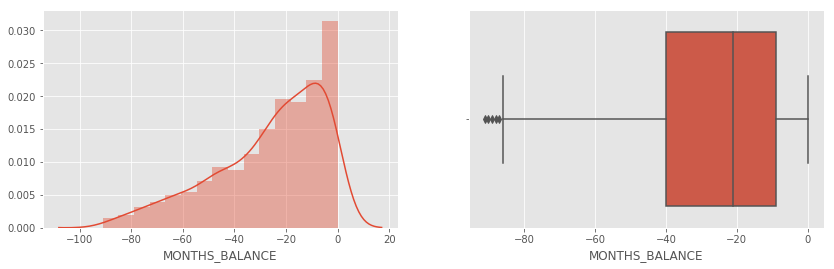

In [99]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(bureau_balance['MONTHS_BALANCE'][:100000],ax = ax)

ax = f.add_subplot(122)
sns.boxplot(bureau_balance['MONTHS_BALANCE'][:100000], ax =ax)

### 4.3 Status
Status of Credit Bureau loan during the month (active, closed, DPD0-30,� [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,� 5 means DPD 120+ or sold or written off ] )

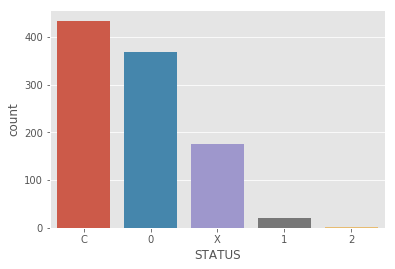

In [100]:
sns.countplot(bureau_balance['STATUS'])

### 4.4 Data preprosessing

In [101]:
bureau_balance.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

In [102]:
# Replace XNA, XAP as np.nan
bureau_balance = replace_XNA_XAP(bureau_balance)

# binary encoding
bureau_balance,bb_bin = binary_encoding(bureau_balance,['STATUS'])

# one hot encoding
bureau_balance, bb_cat = one_hot_encoding(bureau_balance,['STATUS'],nan_as_category=False)

# aggregate
bb_aggregations = {'MONTHS_BALANCE':['min','max','mean']}

for col in bb_cat+bb_bin:
    bb_aggregations[col] =['sum','mean']

bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = [e[0]+ "_" +e[1].upper() for e in bb_agg.columns.tolist()]
bb_agg.head(2)

***** Binary encoding *****
Original shape: (1000, 3)
After: (1000, 8)
***** One hot encoding of categorical variable *****
Original shape (1000, 8)
After OHE (1000, 11)


MONTHS_BALANCE_MIN  MONTHS_BALANCE_MAX  MONTHS_BALANCE_MEAN  \
SK_ID_BUREAU                                                                
5715448                      -26                   0                -13.0   
5715449                      -11                   0                 -5.5   

              STATUS_1_SUM  STATUS_1_MEAN  STATUS_2_SUM  STATUS_2_MEAN  \
SK_ID_BUREAU                                                             
5715448                  0            0.0             0            0.0   
5715449                  0            0.0             0            0.0   

              STATUS_C_SUM  STATUS_C_MEAN  STATUS_X_SUM        ...          \
SK_ID_BUREAU                                                   ...           
5715448                  9       0.333333            10        ...           
5715449                  6       0.500000             1        ...           

              BIN_STATUS_0_SUM  BIN_STATUS_0_MEAN  BIN_STATUS_1_SUM  \
SK_ID_BUREAU                                                          
5715448                      8           0.296296                 0   
5715449                      5           0.416667                 0   

              BIN_STATUS_1_MEAN  BIN_STATUS_2_SUM  BIN_STATUS_2_MEAN  \
SK_ID_BUREAU                                                           
5715448                     0.0                 0                0.0   
5715449                     0.0                 0                0.0   

              BIN_STATUS_C_SUM  BIN_STATUS_C_MEAN  BIN_STATUS_X_SUM  \
SK_ID_BUREAU                                                          
5715448                      9           0.333333                10   
5715449                      6           0.500000                 1   

              BIN_STATUS_X_MEAN  
SK_ID_BUREAU                     
5715448                0.370370  
5715449                0.083333  

[2 rows x 21 columns]

***
***
***
## 5.0 Bureau dataset
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [103]:
print('Number of rows and columns in bureau dataset: ',bureau.shape)
bureau.head()

Number of rows and columns in bureau dataset:  (1000, 17)


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [104]:
basic_details(bureau)

missing_value  %missing_value   dtypes  N unique
SK_ID_CURR                          0             0.0    int64       205
SK_ID_BUREAU                        0             0.0    int64      1000
CREDIT_ACTIVE                       0             0.0   object         3
CREDIT_CURRENCY                     0             0.0   object         1
DAYS_CREDIT                         0             0.0    int64       818
CREDIT_DAY_OVERDUE                  0             0.0    int64         4
DAYS_CREDIT_ENDDATE                66             6.6  float64       796
DAYS_ENDDATE_FACT                 356            35.6  float64       538
AMT_CREDIT_MAX_OVERDUE            593            59.3  float64       100
CNT_CREDIT_PROLONG                  0             0.0    int64         3
AMT_CREDIT_SUM                      0             0.0  float64       629
AMT_CREDIT_SUM_DEBT               150            15.0  float64       243
AMT_CREDIT_SUM_LIMIT              299            29.9  float64        67
AMT_CREDIT_SUM_OVERDUE              0             0.0  float64         4
CREDIT_TYPE                         0             0.0   object         5
DAYS_CREDIT_UPDATE                  0             0.0    int64       564
AMT_ANNUITY                       931            93.1  float64        23

In [105]:
bureau_drop_col = [] # drop columns list
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

* **What is a 'Credit Bureau'?**

A credit bureau is an agency that collects and researches individual credit information and sells it for a fee to creditors so they can make a decision on granting loans.

### 5.1 Credit status
* Credict active: Status of the Credit Bureau (CB) reported credits
* Credit currency: Recoded currency of the Credit Bureau credit

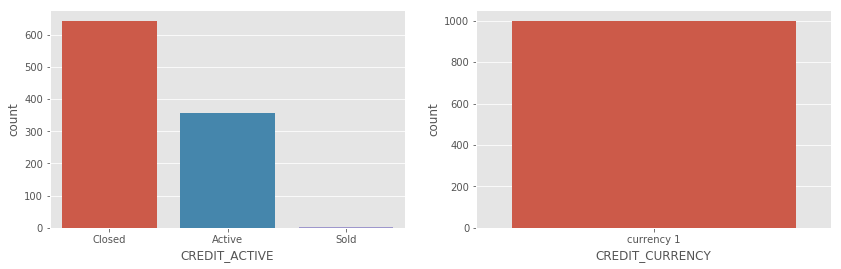

In [106]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.countplot(bureau['CREDIT_ACTIVE'], ax =ax)

ax = f.add_subplot(122)
sns.countplot(bureau['CREDIT_CURRENCY'], ax =ax)

### 5.2 Days credit
The number days before current application did client apply for Credit Bureau credit

In [107]:
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [108]:
bureau[['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT']].describe()

DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT
count  1000.000000         1000.000000           934.000000         644.000000
mean  -1158.419000            2.639000           334.905782       -1023.223602
std     804.710472           82.318631          4612.938747         722.467557
min   -2918.000000            0.000000         -2723.000000       -2723.000000
25%   -1667.000000            0.000000         -1216.500000       -1499.250000
50%   -1042.000000            0.000000          -424.500000        -880.000000
75%    -496.750000            0.000000           408.500000        -436.500000
max      -5.000000         2603.000000         31132.000000          -4.000000

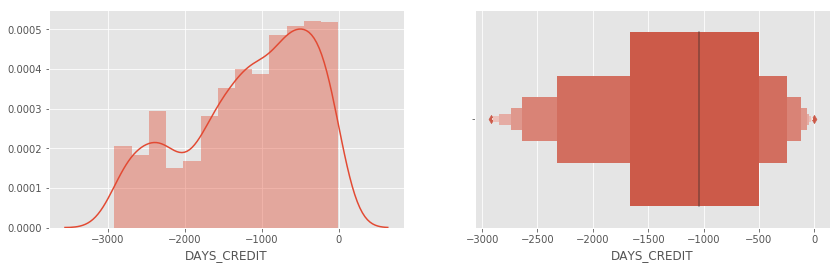

In [109]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(bureau['DAYS_CREDIT'],ax=ax)

ax = f.add_subplot(122)
sns.boxenplot(bureau['DAYS_CREDIT'],ax=ax)

### 5.3 Credit day overdue

Text(0.5,1,'CREDIT_DAY_OVERDUE')

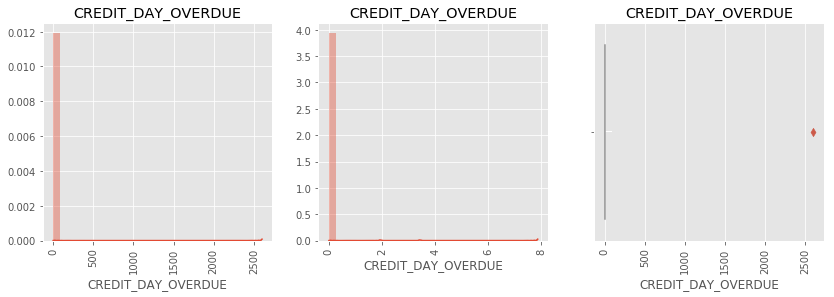

In [110]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(bureau['CREDIT_DAY_OVERDUE'].dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('CREDIT_DAY_OVERDUE')

ax = f.add_subplot(132)
sns.distplot(np.log(bureau['CREDIT_DAY_OVERDUE']+1).dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('CREDIT_DAY_OVERDUE')

ax = f.add_subplot(133)
sns.boxenplot((bureau['CREDIT_DAY_OVERDUE']),ax=ax)
plt.xticks(rotation = 90)
plt.title('CREDIT_DAY_OVERDUE')

In [111]:
# Drop credit day overdue
#bureau_drop_col.append('CREDIT_DAY_OVERDUE')

### 5.4 Day credit end date
Remaining duration of CB credit (in days) at the time of application in Home Credit

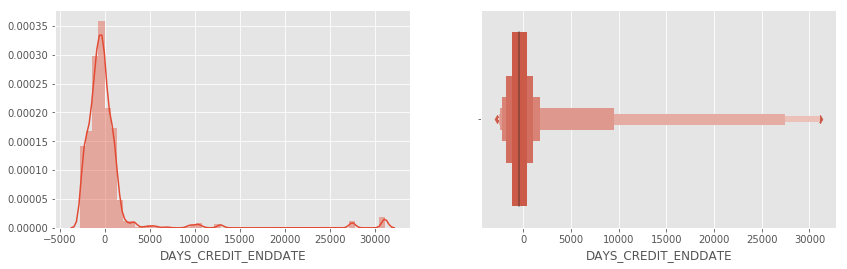

In [112]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(bureau['DAYS_CREDIT_ENDDATE'].dropna(),ax=ax)

ax = f.add_subplot(122)
sns.boxenplot(bureau['DAYS_CREDIT_ENDDATE'],ax=ax)

### 5.5 Days endate fact
Days since CB credit ended at the time of application in Home Credit (only for closed credit)

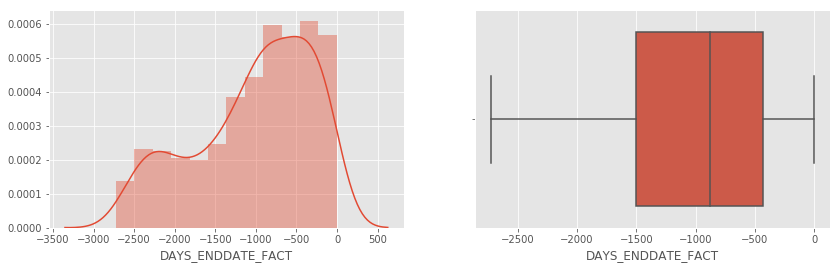

In [113]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(bureau['DAYS_ENDDATE_FACT'].dropna(),ax=ax)

ax = f.add_subplot(122)
sns.boxplot(bureau['DAYS_ENDDATE_FACT'],ax=ax)

### 5.6 Days credit update
How many days before loan application did last information about the Credit Bureau credit come

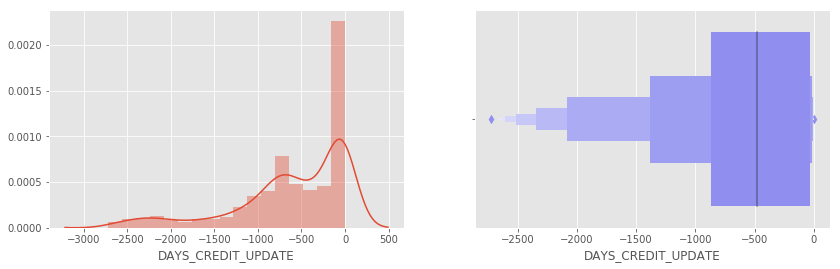

In [114]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(bureau['DAYS_CREDIT_UPDATE'].dropna(),ax=ax)

ax = f.add_subplot(122)
sns.boxenplot(bureau['DAYS_CREDIT_UPDATE'],ax=ax,palette='cool')

### 5.7 Credit type, Count credit prolong

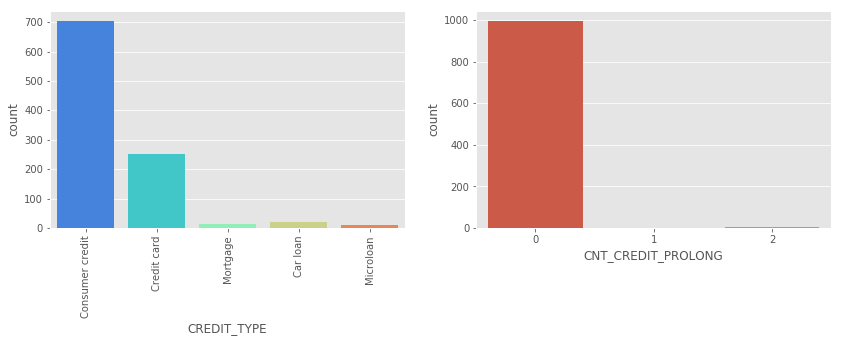

In [115]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.countplot(bureau['CREDIT_TYPE'],palette='rainbow', ax = ax)
plt.xticks(rotation=90)

ax = f.add_subplot(122)
sns.countplot(bureau['CNT_CREDIT_PROLONG'])

In [116]:
bureau[['CREDIT_TYPE','CNT_CREDIT_PROLONG']] = bureau[['CREDIT_TYPE','CNT_CREDIT_PROLONG']].astype('object')

# Drop credit day overdue
#bureau_drop_col.append('CNT_CREDIT_PROLONG')

### 5.8 Amount credit max overdue

In [117]:
bureau[['AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 
        'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']].describe()

AMT_CREDIT_MAX_OVERDUE  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
count              407.000000    1.000000e+03         8.500000e+02   
mean              2985.488182    3.280675e+05         1.116980e+05   
std              12001.409743    7.467505e+05         4.375428e+05   
min                  0.000000    0.000000e+00        -2.692170e+03   
25%                  0.000000    4.764294e+04         0.000000e+00   
50%                  0.000000    1.085468e+05         0.000000e+00   
75%                  0.000000    2.488639e+05         1.105200e+04   
max             140631.840000    7.794000e+06         5.685700e+06   

       AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE   AMT_ANNUITY  
count            701.000000             1000.000000     69.000000  
mean            8723.971027                0.578025  10146.841304  
std            40760.279667               11.822679  15449.843501  
min                0.000000                0.000000      0.000000  
25%                0.000000                0.000000      0.000000  
50%                0.000000                0.000000   5895.000000  
75%                0.000000                0.000000  13131.000000  
max           495000.000000              288.000000  67995.000000

Text(0.5,1,'Amount credit max overdue')

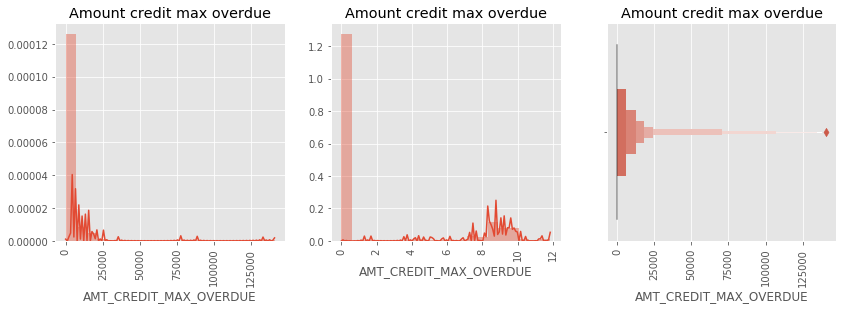

In [118]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(bureau['AMT_CREDIT_MAX_OVERDUE'].dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit max overdue')

ax = f.add_subplot(132)
sns.distplot(np.log1p(bureau['AMT_CREDIT_MAX_OVERDUE']).dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit max overdue')

ax = f.add_subplot(133)
sns.boxenplot(bureau['AMT_CREDIT_MAX_OVERDUE'],ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit max overdue')

### 5.9 Amount credit sum

Text(0.5,1,'Amount credit sum')

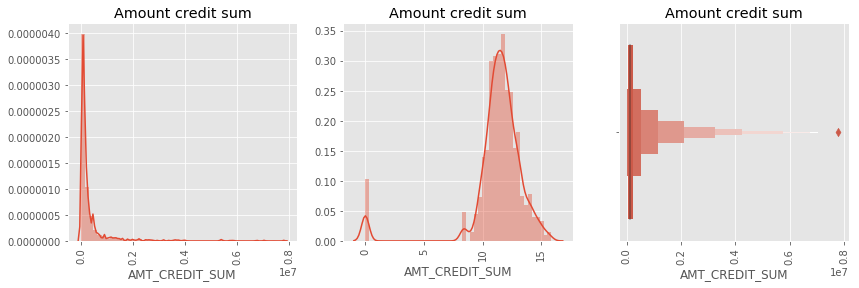

In [119]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(bureau['AMT_CREDIT_SUM'].dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum')

ax = f.add_subplot(132)
sns.distplot(np.log1p(bureau['AMT_CREDIT_SUM']).dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum')

ax = f.add_subplot(133)
sns.boxenplot(bureau['AMT_CREDIT_SUM'],ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum')

In [120]:
# apply lo(x+1) Amount credit sum
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].apply(np.log1p)

### 5.9 Amount credit sum debit

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


Text(0.5,1,'Amount credit sum debit')

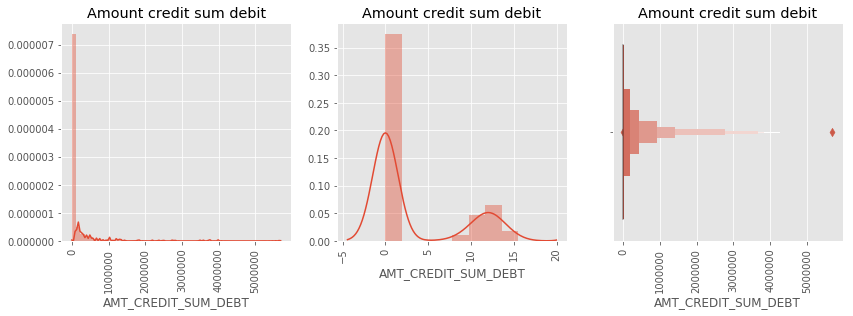

In [121]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(bureau['AMT_CREDIT_SUM_DEBT'].dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum debit')

ax = f.add_subplot(132)
sns.distplot(np.log1p(bureau['AMT_CREDIT_SUM_DEBT']).dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum debit')

ax = f.add_subplot(133)
sns.boxenplot(bureau['AMT_CREDIT_SUM_DEBT'],ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum debit')

In [122]:
# apply
bureau['AMT_CREDIT_SUM_DEBT'] = np.log1p(bureau['AMT_CREDIT_SUM_DEBT'])

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


### 5.10 Amount credit sum limit

Text(0.5,1,'Amount credit sum limit')

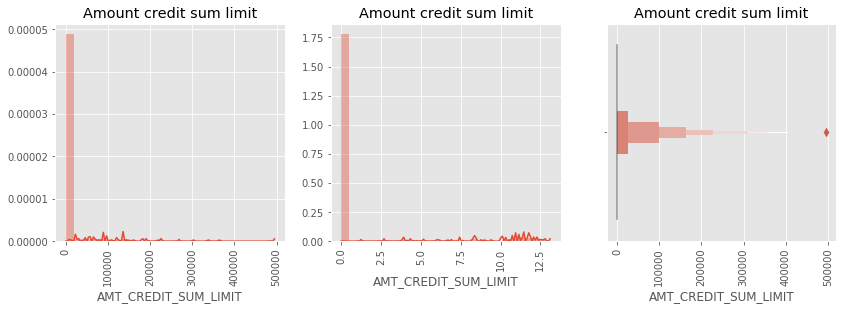

In [123]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(bureau['AMT_CREDIT_SUM_LIMIT'].dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum limit')

ax = f.add_subplot(132)
sns.distplot(np.log1p(bureau['AMT_CREDIT_SUM_LIMIT']).dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum limit')

ax = f.add_subplot(133)
sns.boxenplot(bureau['AMT_CREDIT_SUM_LIMIT'],ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum limit')

### 5.10 Amount credit  sum overdue

Text(0.5,1,'Amount credit sum debit')

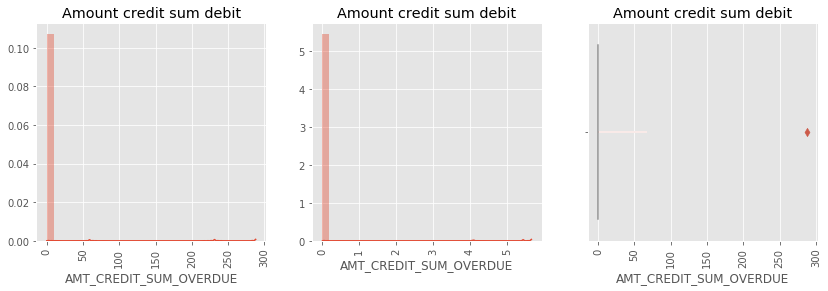

In [124]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(bureau['AMT_CREDIT_SUM_OVERDUE'].dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum debit')

ax = f.add_subplot(132)
sns.distplot(np.log1p(bureau['AMT_CREDIT_SUM_OVERDUE']).dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum debit')

ax = f.add_subplot(133)
sns.boxenplot(bureau['AMT_CREDIT_SUM_OVERDUE'], ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount credit sum debit')

### 5.11 Annuity of the Credit Bureau credit

Text(0.5,1,'Amount annuity')

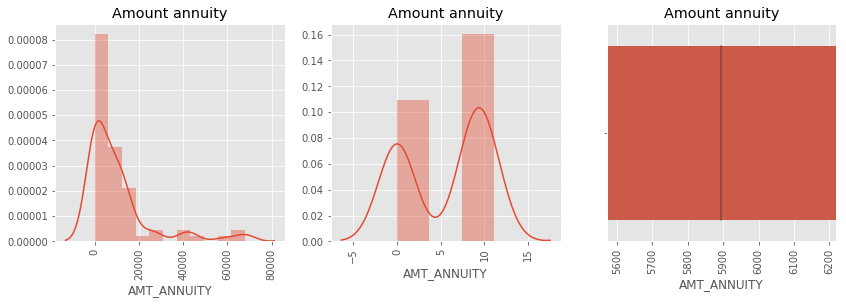

In [125]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(bureau['AMT_ANNUITY'].dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount annuity')

ax = f.add_subplot(132)
sns.distplot(np.log1p(bureau['AMT_ANNUITY']).dropna(),ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount annuity')

ax = f.add_subplot(133)
sns.boxenplot(bureau['AMT_ANNUITY'], ax=ax)
plt.xticks(rotation = 90)
plt.title('Amount annuity')

In [126]:
# apply log
bureau['AMT_ANNUITY'] = np.log1p(bureau['AMT_ANNUITY'])

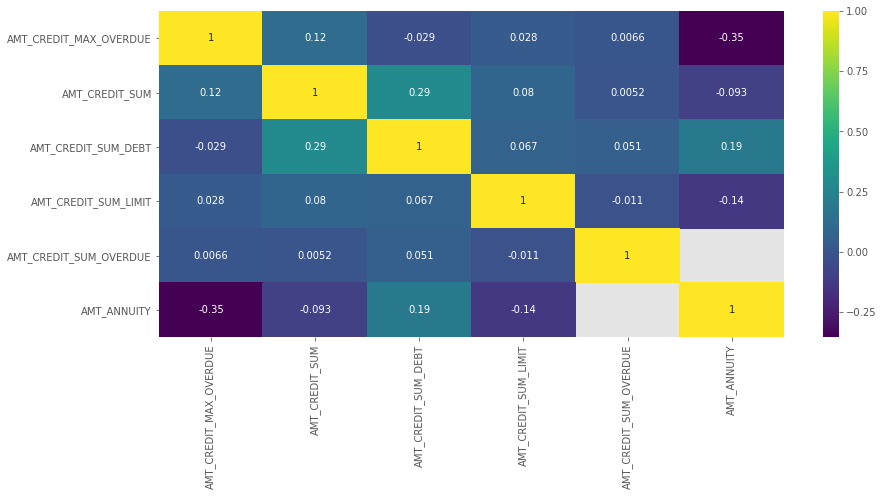

In [127]:
plt.figure(figsize= (14,6))
sns.heatmap(bureau[['AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG','AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 
        'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']].corr(), 
            cmap='viridis', annot=True)

### 5.12 Data preprocessing

In [128]:
# drop features
bureau = bureau.drop(bureau_drop_col, axis=1)

# Replace XNA XAP
bureau = replace_XNA_XAP(bureau)

# columns segrigation
bureau_cat_col = bureau.select_dtypes('object').columns
bureau_numeric_col = bureau.select_dtypes('number').columns
bureau_numeric_col = bureau_numeric_col.drop(['SK_ID_CURR', 'SK_ID_BUREAU'])

## binary encoding
bureau, bureau_bin = binary_encoding(bureau, bureau_cat_col)

### one hot encoding
bureau,bureau_cat = one_hot_encoding(bureau,bureau_cat_col,nan_as_category=False)

# join bb_agg
bureau = bureau.join(bb_agg,how='left',on ='SK_ID_BUREAU')
bureau.drop('SK_ID_BUREAU',axis = 1,inplace=True)

# bureau and bureau_balance numeric feature
num_aggregators = {
    'DAYS_CREDIT': ['min','max','var'],
    'DAYS_CREDIT_ENDDATE': ['min','max','mean'],
    'DAYS_ENDDATE_FACT': ['mean'],
    'CREDIT_DAY_OVERDUE':['max','mean'],
    'AMT_CREDIT_SUM':['mean','sum'],
    'AMT_CREDIT_SUM_DEBT':['sum','max','mean'],
    'AMT_CREDIT_SUM_LIMIT':['sum','mean'],
    'AMT_CREDIT_SUM_OVERDUE':['mean'],
    'AMT_ANNUITY':['mean','max'],
    'MONTHS_BALANCE_MIN':['min'],
    'MONTHS_BALANCE_MAX':['max'],
    'MONTHS_BALANCE_MEAN':['mean']
}

#bureau and bueau_balance categorical feature
cat_aggregates = {}
for col in bureau_cat+bureau_bin:
    cat_aggregates[col] = ['sum','mean']
for col in bb_cat:
    cat_aggregates[col+'_MEAN'] = ['mean']
    cat_aggregates[col+'_SUM'] = ['sum']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregators, **cat_aggregates})
bureau_agg.columns = pd.Index(['BUREAU_'+e[0]+'_'+e[1].upper() for e in bureau_agg.columns.tolist()])

# Bureau active credict using numerical columns
#active = bureau['CREDIT_ACTIVE_Closed']
del bureau,bureau_balance,bb_agg
gc.collect()
bureau_agg.head()

***** Binary encoding *****
Original shape: (1000, 17)
After: (1000, 25)
***** One hot encoding of categorical variable *****
Original shape (1000, 25)
After OHE (1000, 28)


BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
101060                       -2632                    -709   
104261                        -587                    -587   
115001                       -2784                    -174   
118247                       -2022                    -484   
119306                       -1040                    -243   

            BUREAU_DAYS_CREDIT_VAR  BUREAU_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                           
101060               779007.000000                         -2478.0   
104261                         NaN                           872.0   
115001               745005.410714                         -2387.0   
118247               333125.904762                         -1838.0   
119306               158816.333333                          -917.0   

            BUREAU_DAYS_CREDIT_ENDDATE_MAX  BUREAU_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                    
101060                               783.0                           -522.5   
104261                               872.0                            872.0   
115001                              3198.0                            -57.0   
118247                              -182.0                          -1092.0   
119306                              1090.0                            207.0   

            BUREAU_DAYS_ENDDATE_FACT_MEAN  BUREAU_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                                 
101060                       -1721.500000                              0   
104261                                NaN                              0   
115001                        -766.666667                              0   
118247                       -1081.600000                              0   
119306                        -629.000000                              0   

            BUREAU_CREDIT_DAY_OVERDUE_MEAN  BUREAU_AMT_CREDIT_SUM_MEAN  \
SK_ID_CURR                                                               
101060                                 0.0                   11.963490   
104261                                 0.0                   13.017005   
115001                                 0.0                   12.047110   
118247                                 0.0                   11.133799   
119306                                 0.0                   11.282224   

                     ...             BUREAU_BIN_CREDIT_TYPE_Mortgage_SUM  \
SK_ID_CURR           ...                                                   
101060               ...                                               0   
104261               ...                                               0   
115001               ...                                               0   
118247               ...                                               0   
119306               ...                                               0   

            BUREAU_BIN_CREDIT_TYPE_Mortgage_MEAN  BUREAU_STATUS_1_MEAN_MEAN  \
SK_ID_CURR                                                                    
101060                                       0.0                        NaN   
104261                                       0.0                        NaN   
115001                                       0.0                        NaN   
118247                                       0.0                        NaN   
119306                                       0.0                        NaN   

            BUREAU_STATUS_1_SUM_SUM  BUREAU_STATUS_2_MEAN_MEAN  \
SK_ID_CURR                                                       
101060                          0.0                        NaN   
104261                          0.0                        NaN   
115001                          0.0                        NaN   
118247                          0.0                        NaN 

In [129]:
reduce_memory_usage(bureau_agg)

Intial memory usage: 0.0840663909912 MB
Memory usage after complition:  0.0375366210938 MB


## 6.0 POS CASH balance

In [130]:
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [131]:
basic_details(POS_CASH_balance)

missing_value  %missing_value   dtypes  N unique
SK_ID_PREV                         0             0.0    int64       989
SK_ID_CURR                         0             0.0    int64       989
MONTHS_BALANCE                     0             0.0    int64        41
CNT_INSTALMENT                     2             0.2  float64        27
CNT_INSTALMENT_FUTURE              2             0.2  float64        46
NAME_CONTRACT_STATUS               0             0.0   object         3
SK_DPD                             0             0.0    int64        11
SK_DPD_DEF                         0             0.0    int64        10

### 6.1 Months balance
Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )

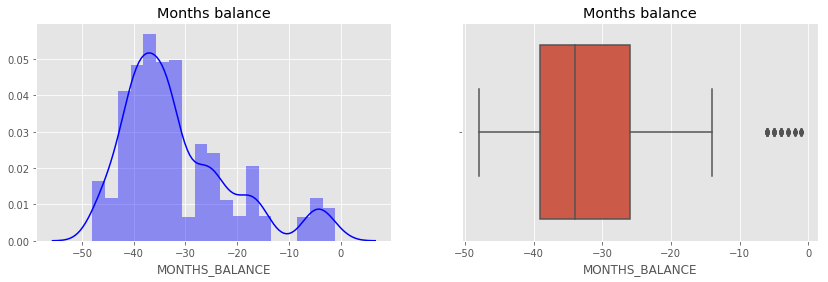

In [132]:
f= plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(POS_CASH_balance['MONTHS_BALANCE'].dropna(),ax=ax,color='blue')
ax.set_title('Months balance')

ax = f.add_subplot(122)
sns.boxplot(POS_CASH_balance['MONTHS_BALANCE'],ax=ax)
ax.set_title('Months balance');

### 6.2 Count instalment
Term of previous credit (can change over time)

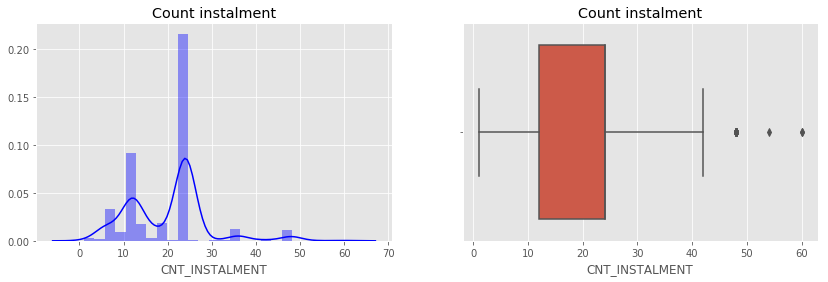

In [133]:
f= plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(POS_CASH_balance['CNT_INSTALMENT'].dropna(),ax=ax,color='blue')
ax.set_title('Count instalment')

ax = f.add_subplot(122)
sns.boxplot(POS_CASH_balance['CNT_INSTALMENT'],ax=ax)
ax.set_title('Count instalment');

### 6.3 Count instalment future
Installments left to pay on the previous credit

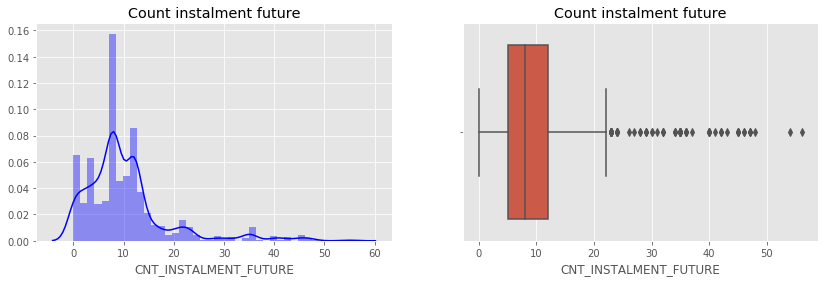

In [134]:
f= plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(POS_CASH_balance['CNT_INSTALMENT_FUTURE'].dropna(),ax=ax,color='blue')
ax.set_title('Count instalment future')

ax = f.add_subplot(122)
sns.boxplot(POS_CASH_balance['CNT_INSTALMENT_FUTURE'],ax=ax)
ax.set_title('Count instalment future');

### 6.4 Name contract status
Contract status during the month

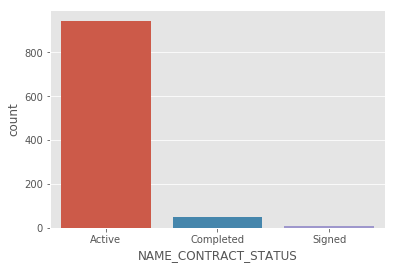

In [135]:
sns.countplot(POS_CASH_balance['NAME_CONTRACT_STATUS'])

### 6.5 SK DPD
DPD (Days past due) during the month on the previous credit

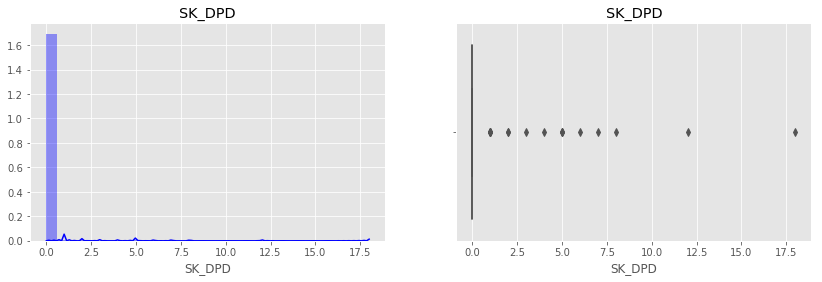

In [136]:
f= plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(POS_CASH_balance['SK_DPD'].dropna(),ax=ax,color='blue')
ax.set_title('SK_DPD')

ax = f.add_subplot(122)
sns.boxplot(POS_CASH_balance['SK_DPD'],ax=ax)
ax.set_title('SK_DPD');

### 6.6 SK DPD DEF
DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

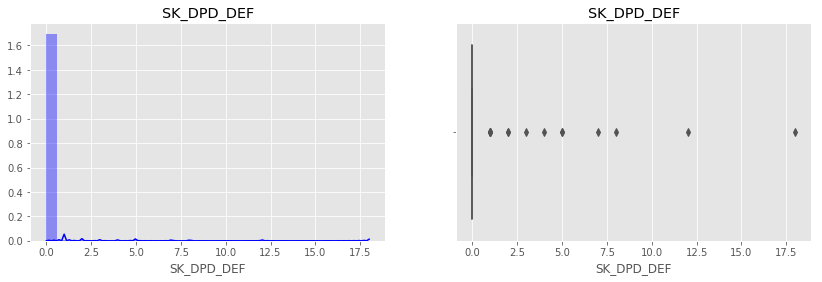

In [137]:
f= plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(POS_CASH_balance['SK_DPD_DEF'].dropna(),ax=ax,color='blue')
ax.set_title('SK_DPD_DEF')

ax = f.add_subplot(122)
sns.boxplot(POS_CASH_balance['SK_DPD_DEF'],ax=ax)
ax.set_title('SK_DPD_DEF');

### 6.6 Data Preprocessing

In [138]:
# Replace XNA, XAP with np.nan
POS_CASH_balance = replace_XNA_XAP(POS_CASH_balance)
# Binary encoding
POS_CASH_balance,pos_bin = binary_encoding(POS_CASH_balance,columns=['NAME_CONTRACT_STATUS'])

# One hot encoding
POS_CASH_balance,pos_cat = one_hot_encoding(POS_CASH_balance,columns=['NAME_CONTRACT_STATUS'], nan_as_category=True)

# Aggregate
pos_aggregate ={
    'MONTHS_BALANCE':['mean','max'],
    'CNT_INSTALMENT':['mean','sum'],
    'CNT_INSTALMENT_FUTURE':['mean','sum'],
    'SK_DPD':['max','mean'],
    'SK_DPD_DEF':['max','mean']
}
for col in pos_cat+pos_bin:
    pos_aggregate[col] =['sum','mean']
pos_agg = POS_CASH_balance.groupby('SK_ID_CURR').agg(pos_aggregate)
pos_agg.columns = pd.Index(['POS_'+ e[0]+ '_'+ e[1].upper() for e in pos_agg.columns.tolist()])
del POS_CASH_balance
pos_agg.head(2)

***** Binary encoding *****
Original shape: (1000, 8)
After: (1000, 11)
***** One hot encoding of categorical variable *****
Original shape (1000, 11)
After OHE (1000, 13)


POS_MONTHS_BALANCE_MEAN  POS_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                    
100187                        -43.0                     -43   
100457                        -16.0                     -16   

            POS_CNT_INSTALMENT_MEAN  POS_CNT_INSTALMENT_SUM  \
SK_ID_CURR                                                    
100187                         24.0                    24.0   
100457                         24.0                    24.0   

            POS_CNT_INSTALMENT_FUTURE_MEAN  POS_CNT_INSTALMENT_FUTURE_SUM  \
SK_ID_CURR                                                                  
100187                                 8.0                            8.0   
100457                                23.0                           23.0   

            POS_SK_DPD_MAX  POS_SK_DPD_MEAN  POS_SK_DPD_DEF_MAX  \
SK_ID_CURR                                                        
100187                   0                0                   0   
100457                   0                0                   0   

            POS_SK_DPD_DEF_MEAN                    ...                     \
SK_ID_CURR                                         ...                      
100187                        0                    ...                      
100457                        0                    ...                      

            POS_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                        
100187                                        0   
100457                                        0   

            POS_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                         
100187                                         0   
100457                                         0   

            POS_NAME_CONTRACT_STATUS_nan_SUM  \
SK_ID_CURR                                     
100187                                     0   
100457                                     0   

            POS_NAME_CONTRACT_STATUS_nan_MEAN  \
SK_ID_CURR                                      
100187                                      0   
100457                                      0   

            POS_BIN_NAME_CONTRACT_STATUS_Active_SUM  \
SK_ID_CURR                                            
100187                                            1   
100457                                            1   

            POS_BIN_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                             
100187                                           1.0   
100457                                           1.0   

            POS_BIN_NAME_CONTRACT_STATUS_Completed_SUM  \
SK_ID_CURR                                               
100187                                               0   
100457                                               0   

            POS_BIN_NAME_CONTRACT_STATUS_Completed_MEAN  \
SK_ID_CURR                                                
100187                                              0.0   
100457                                              0.0   

            POS_BIN_NAME_CONTRACT_STATUS_Signed_SUM  \
SK_ID_CURR                                            
100187                                            0   
100457                                            0   

            POS_BIN_NAME_CONTRACT_STATUS_Signed_MEAN  
SK_ID_CURR                                            
100187                                             0  
100457                                             0  

[2 rows x 22 columns]

In [139]:
gc.collect()
reduce_memory_usage(pos_agg)

Intial memory usage: 0.14053440094 MB
Memory usage after complition:  0.050931930542 MB


## 7.0 Credit card balance
Glimpse data set

In [140]:
print('Number of rows and columns in dataset:',credit_card_balance.shape)
credit_card_balance.head()

Number of rows and columns in dataset: (1000, 23)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY     ...      AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325     ...              0.000                 0.000   
1                 2250.000     ...          64875.555             64875.555   
2                 2250.000     ...          31460.085             31460.085   
3                11795.760     ...         233048.970            233048.970   
4                22924.890     ...         453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [141]:
basic_details(credit_card_balance)

missing_value  %missing_value   dtypes  N unique
SK_ID_PREV                              0             0.0    int64      1000
SK_ID_CURR                              0             0.0    int64      1000
MONTHS_BALANCE                          0             0.0    int64         7
AMT_BALANCE                             0             0.0  float64       622
AMT_CREDIT_LIMIT_ACTUAL                 0             0.0    int64        35
AMT_DRAWINGS_ATM_CURRENT              137            13.7  float64        54
AMT_DRAWINGS_CURRENT                    0             0.0  float64       343
AMT_DRAWINGS_OTHER_CURRENT            137            13.7  float64         4
AMT_DRAWINGS_POS_CURRENT              137            13.7  float64       307
AMT_INST_MIN_REGULARITY                 0             0.0  float64       506
AMT_PAYMENT_CURRENT                   139            13.9  float64       411
AMT_PAYMENT_TOTAL_CURRENT               0             0.0  float64       340
AMT_RECEIVABLE_PRINCIPAL                0             0.0  float64       607
AMT_RECIVABLE                           0             0.0  float64       612
AMT_TOTAL_RECEIVABLE                    0             0.0  float64       612
CNT_DRAWINGS_ATM_CURRENT              137            13.7  float64        10
CNT_DRAWINGS_CURRENT                    0             0.0    int64        39
CNT_DRAWINGS_OTHER_CURRENT            137            13.7  float64         2
CNT_DRAWINGS_POS_CURRENT              137            13.7  float64        40
CNT_INSTALMENT_MATURE_CUM               0             0.0  float64        96
NAME_CONTRACT_STATUS                    0             0.0   object         2
SK_DPD                                  0             0.0    int64         7
SK_DPD_DEF                              0             0.0    int64         2

In [142]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

### 7.1 Months balance

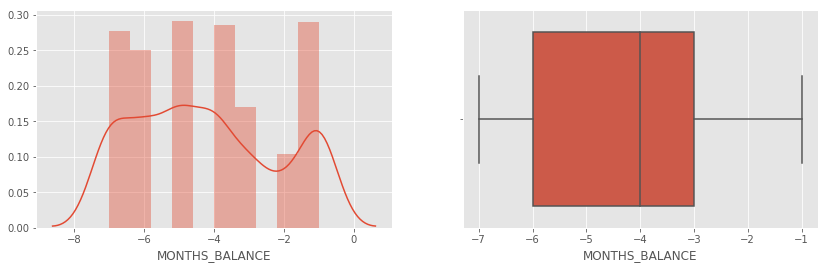

In [143]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot((credit_card_balance['MONTHS_BALANCE']), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['MONTHS_BALANCE'], ax=ax)

### 7.2 Amount balance

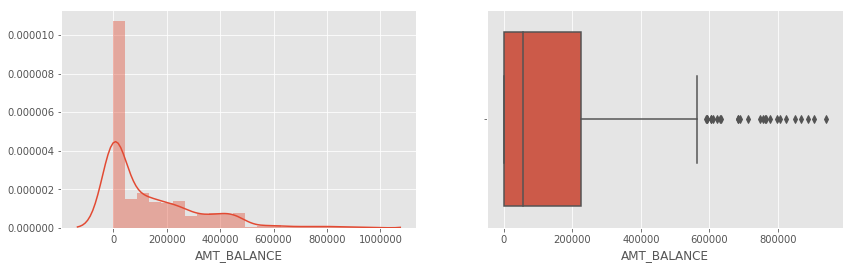

In [144]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot((credit_card_balance['AMT_BALANCE']), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_BALANCE'], ax=ax)

### 7.3 Amount drawing current

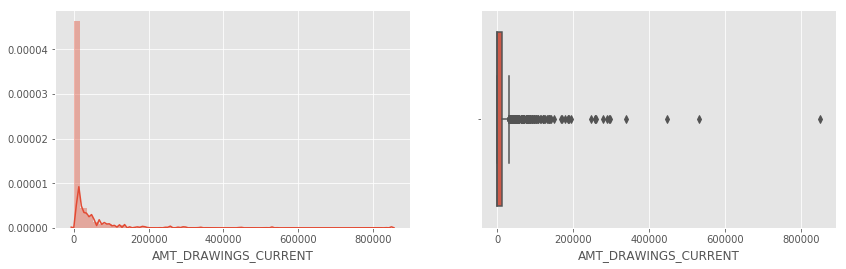

In [145]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['AMT_DRAWINGS_CURRENT'].dropna(), ax=ax)

ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_DRAWINGS_CURRENT'], ax=ax)

### 7.4 Amount credit limit actual

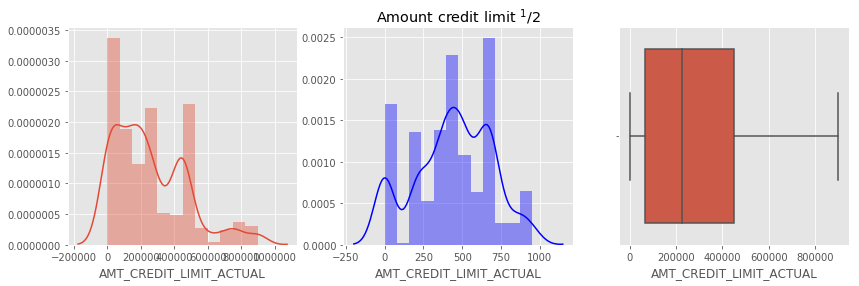

In [146]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].dropna(), ax=ax)

ax = f.add_subplot(132)
sns.distplot(np.sqrt(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].dropna()), ax=ax,color='blue')
plt.title('Amount credit limit $^1/2$')
ax = f.add_subplot(133)
sns.boxplot(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'], ax=ax)

In [147]:
# apply sqrt
credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] = np.sqrt(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'])

### 7.5 Amount drawing other current

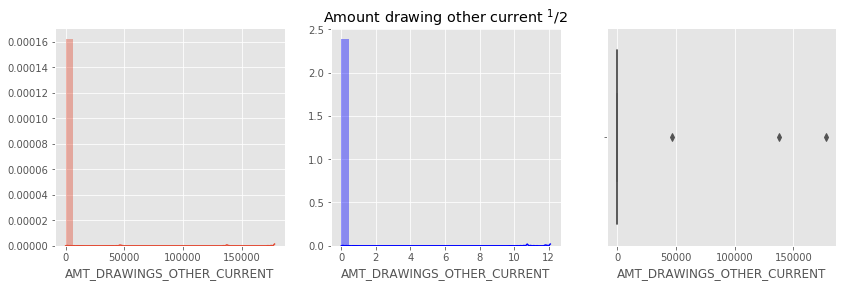

In [148]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(credit_card_balance['AMT_DRAWINGS_OTHER_CURRENT'].dropna(), ax=ax)

ax = f.add_subplot(132)
sns.distplot(np.log1p(credit_card_balance['AMT_DRAWINGS_OTHER_CURRENT'].dropna()), ax=ax,color='blue')
plt.title('Amount drawing other current $^1/2$')
ax = f.add_subplot(133)
sns.boxplot(credit_card_balance['AMT_DRAWINGS_OTHER_CURRENT'], ax=ax)

### 7.6 Amount drawing atm current

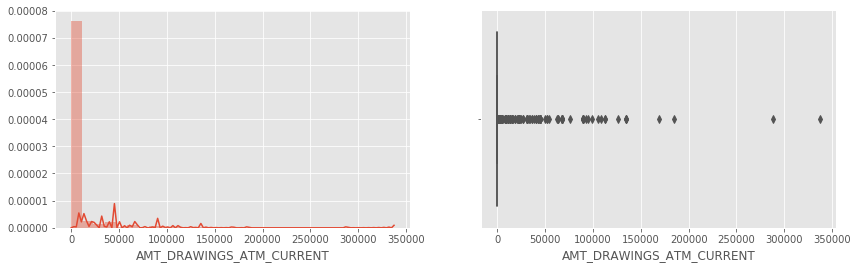

In [149]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot((credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].dropna()), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].dropna(), ax=ax)

### 7.6 Amount drawing pos current

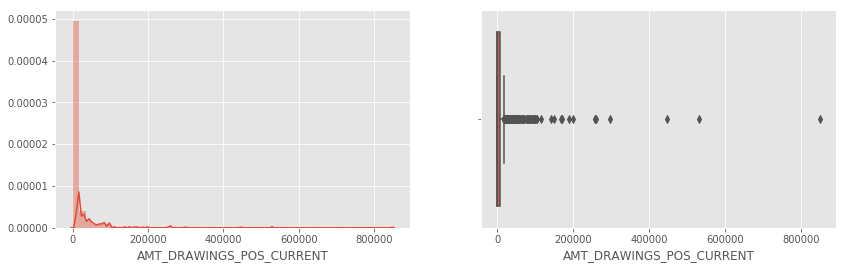

In [150]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['AMT_DRAWINGS_POS_CURRENT'].dropna(), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_DRAWINGS_POS_CURRENT'], ax=ax)

### 7.7 Amount instalment min regularity

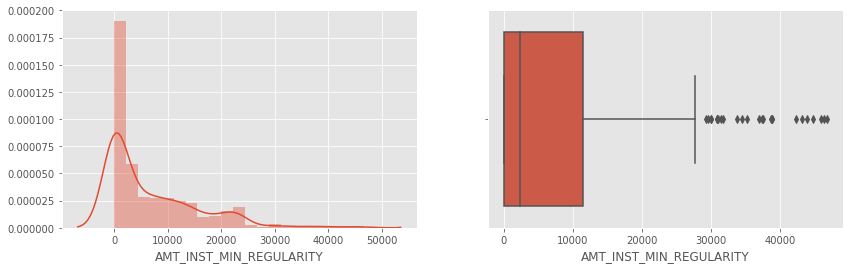

In [151]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['AMT_INST_MIN_REGULARITY'].dropna(), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_INST_MIN_REGULARITY'], ax=ax)

### 7.8 Amount payment current

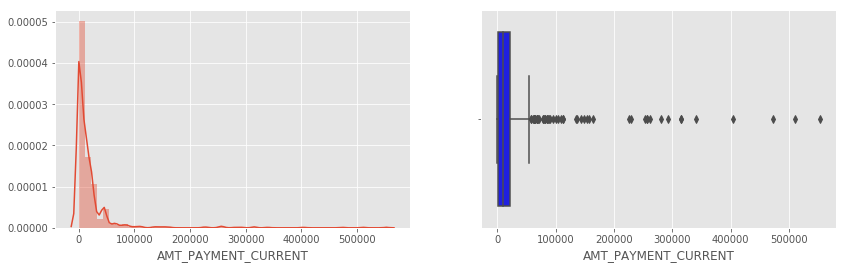

In [152]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['AMT_PAYMENT_CURRENT'].dropna(), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_PAYMENT_CURRENT'], ax=ax,color='blue')

### 7.9 Amount Receivable principle

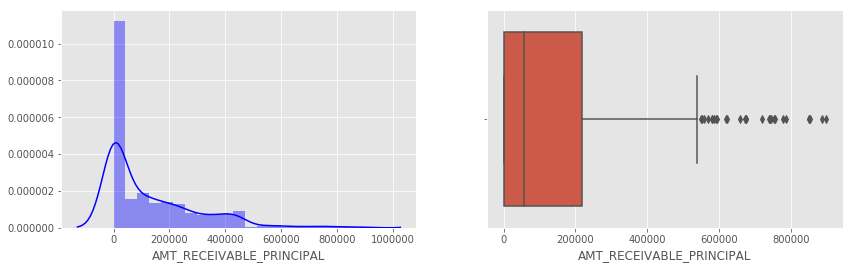

In [153]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['AMT_RECEIVABLE_PRINCIPAL'].dropna(), ax=ax,color='blue')
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_RECEIVABLE_PRINCIPAL'], ax=ax)

### 7.10 Amount recivable

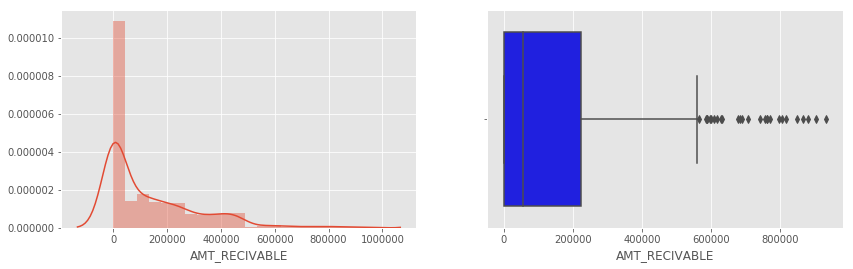

In [154]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['AMT_RECIVABLE'].dropna(), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_RECIVABLE'], ax=ax,color='blue')

### 7.11 Amount total receivable

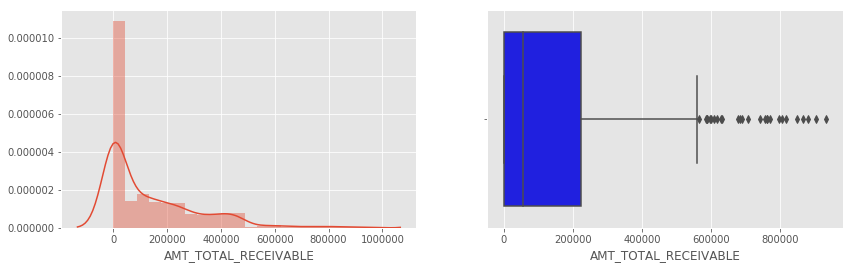

In [155]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['AMT_TOTAL_RECEIVABLE'].dropna(), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['AMT_TOTAL_RECEIVABLE'], ax=ax,color='blue')

### 7.12 Count drawing

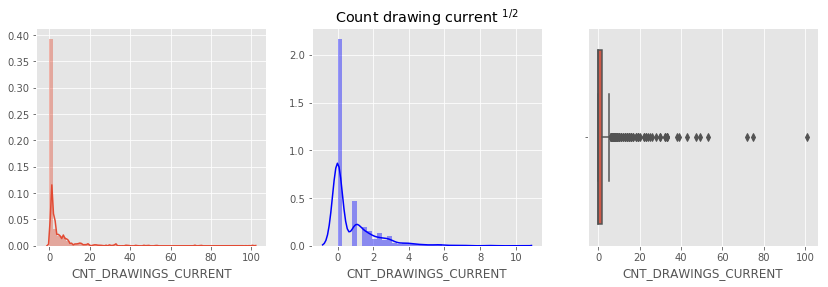

In [156]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(credit_card_balance['CNT_DRAWINGS_CURRENT'].dropna(), ax=ax)

ax = f.add_subplot(132)
sns.distplot(np.sqrt(credit_card_balance['CNT_DRAWINGS_CURRENT'].dropna()), ax=ax,color='blue')
plt.title('Count drawing current $^{1/2}$')
ax = f.add_subplot(133)
sns.boxplot(credit_card_balance['CNT_DRAWINGS_CURRENT'], ax=ax)

In [157]:
credit_card_balance['CNT_DRAWINGS_CURRENT'] = np.sqrt(credit_card_balance['CNT_DRAWINGS_CURRENT'])

### 7.13 Count drawing atm current

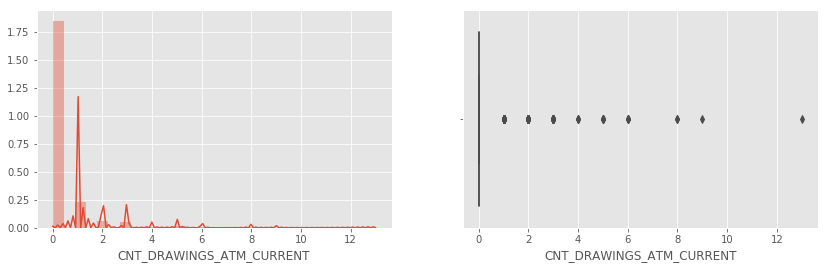

In [158]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['CNT_DRAWINGS_ATM_CURRENT'].dropna(), ax=ax)
ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['CNT_DRAWINGS_ATM_CURRENT'], ax=ax,color='blue')

### 7.14 Count drawing other current

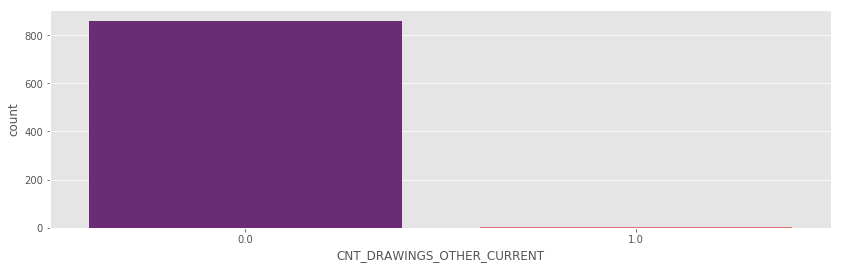

In [159]:
plt.figure(figsize=(14,4))
sns.countplot(credit_card_balance['CNT_DRAWINGS_OTHER_CURRENT'],palette='magma')

In [160]:
# convert ot category
credit_card_balance['CNT_DRAWINGS_OTHER_CURRENT'] = credit_card_balance['CNT_DRAWINGS_OTHER_CURRENT'].astype('object')

### 7.15 Count drawing POS current

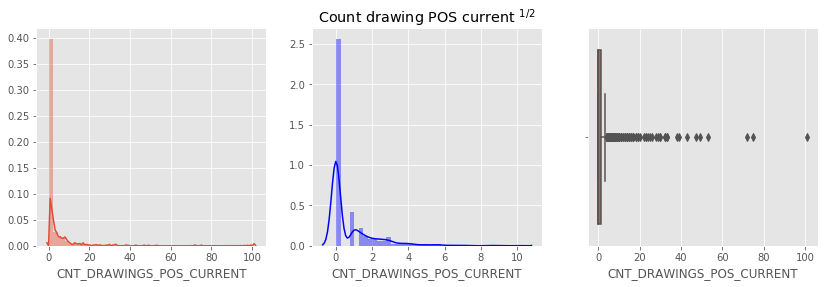

In [161]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(credit_card_balance['CNT_DRAWINGS_POS_CURRENT'].dropna(), ax=ax)

ax = f.add_subplot(132)
sns.distplot(np.sqrt(credit_card_balance['CNT_DRAWINGS_POS_CURRENT'].dropna()), ax=ax,color='blue')
plt.title('Count drawing POS current $^{1/2}$')
ax = f.add_subplot(133)
sns.boxplot(credit_card_balance['CNT_DRAWINGS_POS_CURRENT'], ax=ax)

In [162]:
# Apply square root
credit_card_balance['CNT_DRAWINGS_POS_CURRENT'] = np.sqrt(credit_card_balance['CNT_DRAWINGS_POS_CURRENT'])

### 7.16 Count instalment mature come

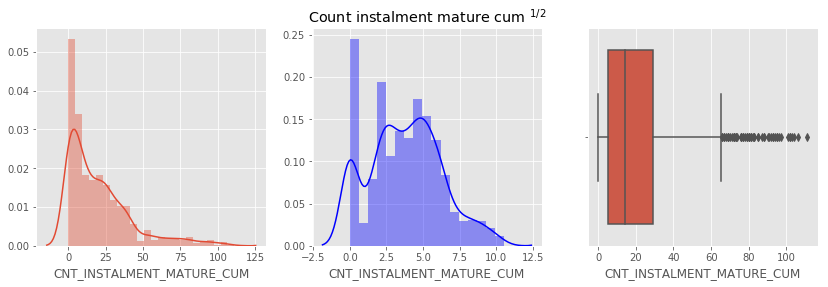

In [163]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(131)
sns.distplot(credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].dropna(), ax=ax)

ax = f.add_subplot(132)
sns.distplot(np.sqrt(credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].dropna()), ax=ax,color='blue')
plt.title('Count instalment mature cum $^{1/2}$')
ax = f.add_subplot(133)
sns.boxplot(credit_card_balance['CNT_INSTALMENT_MATURE_CUM'], ax=ax)

In [164]:
# Apply square root
credit_card_balance['CNT_INS'] = np.sqrt(credit_card_balance['CNT_INSTALMENT_MATURE_CUM'])

### 7.17 SK DPD
DPD (Days past due) during the month on the previous credit

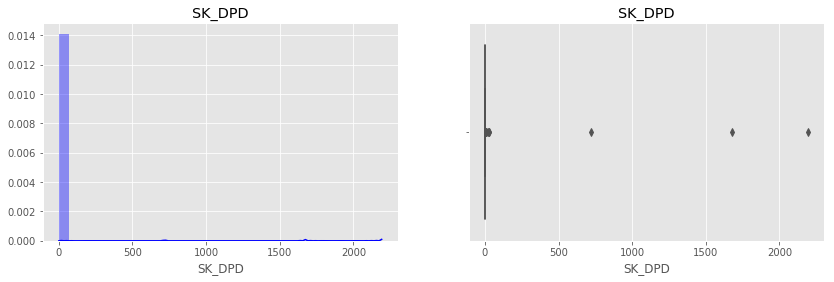

In [165]:
f= plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['SK_DPD'].dropna(),ax=ax,color='blue')
ax.set_title('SK_DPD')

ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['SK_DPD'],ax=ax)
ax.set_title('SK_DPD');

### 7.18 SK DPD DEF
DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

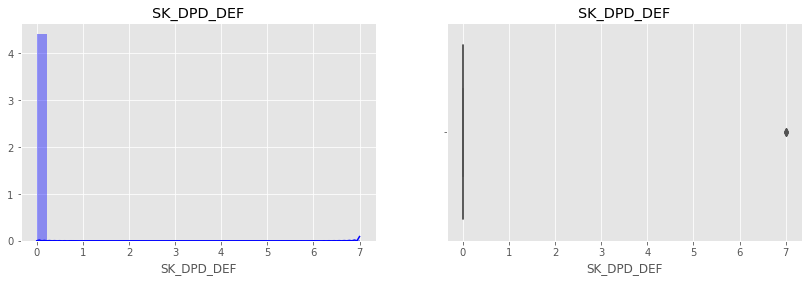

In [166]:
f= plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(credit_card_balance['SK_DPD_DEF'].dropna(),ax=ax,color='blue')
ax.set_title('SK_DPD_DEF')

ax = f.add_subplot(122)
sns.boxplot(credit_card_balance['SK_DPD_DEF'],ax=ax)
ax.set_title('SK_DPD_DEF');

### 7.19 Name contract status

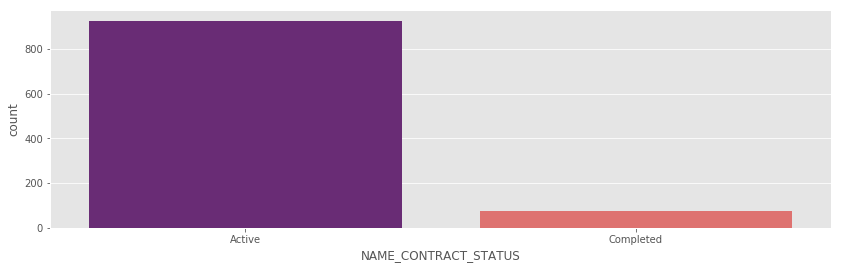

In [167]:
plt.figure(figsize=(14,4))
sns.countplot(credit_card_balance['NAME_CONTRACT_STATUS'],palette='magma')

In [168]:
credit_card_balance['NAME_CONTRACT_STATUS'] = credit_card_balance['NAME_CONTRACT_STATUS'].astype('object')

### 7.20 Data preprocessing

In [170]:
# Replace XNA, XAP
#credit_card_balance = replace_XNA_XAP(credit_card_balance)

# Column segrigation
credit_object_col = credit_card_balance.select_dtypes('object').columns

# Binary encoding 
credit_card_balance,credit_bin = binary_encoding(credit_card_balance,credit_object_col)

## One hot encoding
credit_card_balance,credit_cat = one_hot_encoding(credit_card_balance,credit_object_col, nan_as_category=False)

# General aggregation
credit_aggregation = {
    'MONTHS_BALANCE':['mean','min','max'],
    'AMT_BALANCE':['mean','min'],
    'AMT_CREDIT_LIMIT_ACTUAL':['mean','min'], 
    'AMT_DRAWINGS_ATM_CURRENT':['mean','min','max'],
    'AMT_DRAWINGS_CURRENT':['mean','min','max'], 
    'AMT_DRAWINGS_OTHER_CURRENT':['mean','min','max'],
    'AMT_DRAWINGS_POS_CURRENT':['mean','min','max'], 
    'AMT_INST_MIN_REGULARITY':['mean','min','max'],
    'AMT_PAYMENT_CURRENT':['mean','min','max'], 
    'AMT_PAYMENT_TOTAL_CURRENT':['mean','min','max'],
    'AMT_RECEIVABLE_PRINCIPAL':['mean','min','max'], 
    'AMT_RECIVABLE':['mean','min','max'], 
    'AMT_TOTAL_RECEIVABLE':['mean','min','max'],
    'CNT_DRAWINGS_ATM_CURRENT':['mean','min','max'], 
    'CNT_DRAWINGS_CURRENT':['mean','min','max'],
    'CNT_DRAWINGS_POS_CURRENT':['mean','min','max'],
    'CNT_INSTALMENT_MATURE_CUM':['mean','min','max'], 
    'SK_DPD':['mean','sum'],
    'SK_DPD_DEF':['mean','sum'],
    }

for col in credit_cat+credit_bin:
    credit_aggregation[col] = ['mean']
    credit_aggregation[col] = ['sum']

#credit_card_balance.drop('SK_ID_PREV',axis=1,inplace=True)
credit_agg = credit_card_balance.groupby('SK_ID_CURR').agg(credit_aggregation)
credit_agg.columns = pd.Index(['CREDIT_'+e[0]+'_'+ e[1].upper() for e in credit_agg.columns.tolist()])
del credit_card_balance
credit_agg.head(2)

***** Binary encoding *****
Original shape: (1000, 24)
After: (1000, 24)
***** One hot encoding of categorical variable *****
Original shape (1000, 24)
After OHE (1000, 24)


CREDIT_MONTHS_BALANCE_MEAN  CREDIT_MONTHS_BALANCE_MIN  \
SK_ID_CURR                                                          
100218                              -4                         -4   
100662                              -5                         -5   

            CREDIT_MONTHS_BALANCE_MAX  CREDIT_AMT_BALANCE_MEAN  \
SK_ID_CURR                                                       
100218                             -4               748180.935   
100662                             -5                    0.000   

            CREDIT_AMT_BALANCE_MIN  CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MEAN  \
SK_ID_CURR                                                                
100218                  748180.935                           848.528137   
100662                       0.000                             0.000000   

            CREDIT_AMT_CREDIT_LIMIT_ACTUAL_MIN  \
SK_ID_CURR                                       
100218                              848.528137   
100662                                0.000000   

            CREDIT_AMT_DRAWINGS_ATM_CURRENT_MEAN  \
SK_ID_CURR                                         
100218                                       0.0   
100662                                       NaN   

            CREDIT_AMT_DRAWINGS_ATM_CURRENT_MIN  \
SK_ID_CURR                                        
100218                                      0.0   
100662                                      NaN   

            CREDIT_AMT_DRAWINGS_ATM_CURRENT_MAX          ...            \
SK_ID_CURR                                               ...             
100218                                      0.0          ...             
100662                                      NaN          ...             

            CREDIT_CNT_DRAWINGS_POS_CURRENT_MEAN  \
SK_ID_CURR                                         
100218                                  2.828427   
100662                                       NaN   

            CREDIT_CNT_DRAWINGS_POS_CURRENT_MIN  \
SK_ID_CURR                                        
100218                                 2.828427   
100662                                      NaN   

            CREDIT_CNT_DRAWINGS_POS_CURRENT_MAX  \
SK_ID_CURR                                        
100218                                 2.828427   
100662                                      NaN   

            CREDIT_CNT_INSTALMENT_MATURE_CUM_MEAN  \
SK_ID_CURR                                          
100218                                        8.0   
100662                                        0.0   

            CREDIT_CNT_INSTALMENT_MATURE_CUM_MIN  \
SK_ID_CURR                                         
100218                                       8.0   
100662                                       0.0   

            CREDIT_CNT_INSTALMENT_MATURE_CUM_MAX  CREDIT_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100218                                       8.0                   0   
100662                                       0.0                   0   

            CREDIT_SK_DPD_SUM  CREDIT_SK_DPD_DEF_MEAN  CREDIT_SK_DPD_DEF_SUM  
SK_ID_CURR                                                                    
100218                      0                       0                      0  
100662                      0                       0                      0  

[2 rows x 53 columns]

## 8.0 previous_application

In [172]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START            ...            NAME_SELLER_INDUSTRY  \
0                       15            ...                    Connectivity   
1                       11            ...                             XNA   
2                       11            ...                             XNA   
3                        7            ...                             XNA   
4                        9            ...                             XNA   

   CNT_PAYMENT  NAME_YIELD_GROUP       PRODUCT_COMBINATION  \
0         12.0            middle  POS mobile with interest   
1         36.0        low_action          Cash X-Sell: low   
2         12.0              high         Cash X-Sell: high   
3         12.0            middle       Cash X-Sell: middle   
4         24.0              high         Cash Street: high   

   DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0            365243.0          -42.0                     300.0          -42.0   
1            365243.0         -134.0                     916.0       365243.0   
2            365243.0         -271.0                      59.0       365243.0   
3            365243.0         -482.0                    -152.0         -182.0   
4                 NaN            NaN                       NaN            NaN   

  DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
0            -37.0                       0.0  
1         365243.0                       1.0  
2         365243.0                       1.0  
3           -177.0                       1.0  
4              NaN                       NaN  

[5 rows x 37 columns]

In [173]:
prev_cat_col = previous_application.select_dtypes(include='object').columns
int_col = [i for i in previous_application.columns.values if i not in prev_cat_col]

In [174]:
basic_details(previous_application[prev_cat_col])

missing_value  %missing_value  dtypes  N unique
NAME_CONTRACT_TYPE                       0             0.0  object         3
WEEKDAY_APPR_PROCESS_START               0             0.0  object         7
FLAG_LAST_APPL_PER_CONTRACT              0             0.0  object         2
NAME_CASH_LOAN_PURPOSE                   0             0.0  object        12
NAME_CONTRACT_STATUS                     0             0.0  object         4
NAME_PAYMENT_TYPE                        0             0.0  object         4
CODE_REJECT_REASON                       0             0.0  object         7
NAME_TYPE_SUITE                        497            49.7  object         7
NAME_CLIENT_TYPE                         0             0.0  object         4
NAME_GOODS_CATEGORY                      0             0.0  object        20
NAME_PORTFOLIO                           0             0.0  object         4
NAME_PRODUCT_TYPE                        0             0.0  object         3
CHANNEL_TYPE                             0             0.0  object         7
NAME_SELLER_INDUSTRY                     0             0.0  object        10
NAME_YIELD_GROUP                         0             0.0  object         5
PRODUCT_COMBINATION                      0             0.0  object        16

In [175]:
basic_details(previous_application[int_col])

missing_value  %missing_value   dtypes  N unique
SK_ID_PREV                             0             0.0    int64      1000
SK_ID_CURR                             0             0.0    int64       985
AMT_ANNUITY                          198            19.8  float64       738
AMT_APPLICATION                        0             0.0  float64       577
AMT_CREDIT                             0             0.0  float64       698
AMT_DOWN_PAYMENT                     438            43.8  float64       228
AMT_GOODS_PRICE                      193            19.3  float64       577
HOUR_APPR_PROCESS_START                0             0.0    int64        20
NFLAG_LAST_APPL_IN_DAY                 0             0.0    int64         2
RATE_DOWN_PAYMENT                    438            43.8  float64       252
RATE_INTEREST_PRIMARY                994            99.4  float64         6
RATE_INTEREST_PRIVILEGED             994            99.4  float64         4
DAYS_DECISION                          0             0.0    int64       772
SELLERPLACE_AREA                       0             0.0    int64       182
CNT_PAYMENT                          198            19.8  float64        21
DAYS_FIRST_DRAWING                   370            37.0  float64        30
DAYS_FIRST_DUE                       370            37.0  float64       546
DAYS_LAST_DUE_1ST_VERSION            370            37.0  float64       532
DAYS_LAST_DUE                        370            37.0  float64       442
DAYS_TERMINATION                     370            37.0  float64       447
NFLAG_INSURED_ON_APPROVAL            370            37.0  float64         2

In [242]:
previous_application.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

### 8.1 Name contract type

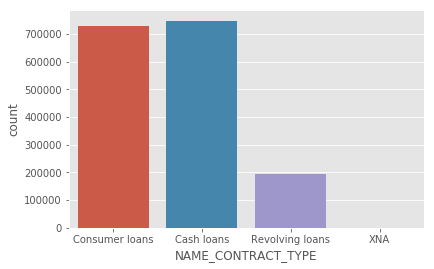

In [265]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.countplot(previous_application['NAME_CONTRACT_TYPE'], ax= ax)

### 8.2 Amount annuity

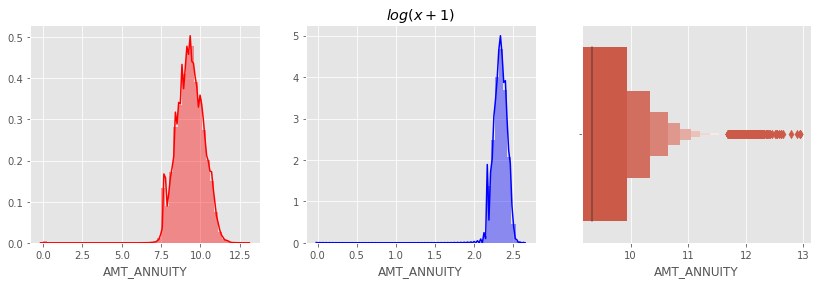

In [268]:
f = plt.figure(figsize =(14,4))
ax = f.add_subplot(131)
sns.distplot((previous_application['AMT_ANNUITY'].dropna()),ax= ax,color='red')
ax = f.add_subplot(132)
sns.distplot(np.log1p(previous_application['AMT_ANNUITY'].dropna()),ax= ax,color='blue')
plt.title('$log(x+1)$')
ax = f.add_subplot(133)
sns.boxenplot(previous_application['AMT_ANNUITY'], ax =ax)

In [267]:
# apply log on both side
previous_application['AMT_ANNUITY'] = np.log1p(previous_application['AMT_ANNUITY'])

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


### 8.3 Amount application

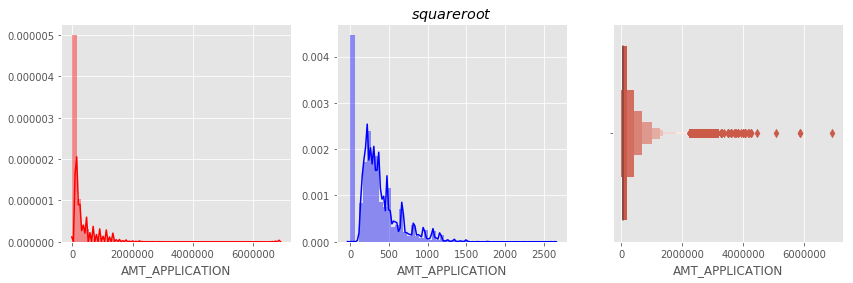

In [271]:
f = plt.figure(figsize =(14,4))
ax = f.add_subplot(131)
sns.distplot((previous_application['AMT_APPLICATION'].dropna()),ax= ax,color='red')
ax = f.add_subplot(132)
sns.distplot(np.sqrt(previous_application['AMT_APPLICATION'].dropna()),ax= ax,color='blue')
plt.title('$square root$')
ax = f.add_subplot(133)
sns.boxenplot(previous_application['AMT_APPLICATION'], ax =ax)

In [272]:
# apply sqrt
previous_application['AMT_APPLICATION'] = np.sqrt(previous_application['AMT_APPLICATION'])

### 8.4 Amount credit

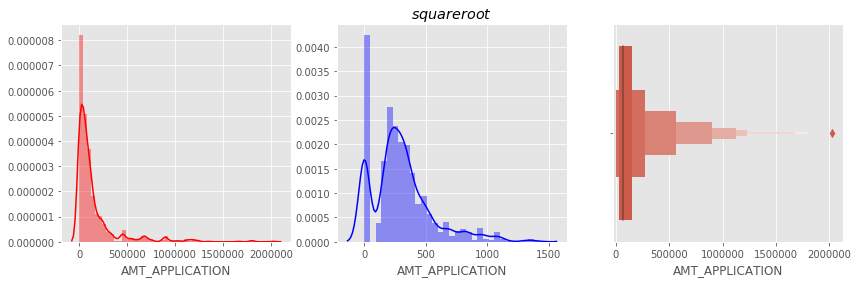

In [254]:
f = plt.figure(figsize =(14,4))
ax = f.add_subplot(131)
sns.distplot((previous_application['AMT_CREDIT'].dropna()),ax= ax,color='red')
ax = f.add_subplot(132)
sns.distplot(np.sqrt(previous_application['AMT_CREDIT'].dropna()),ax= ax,color='blue')
plt.title('$square root$')
ax = f.add_subplot(133)
sns.boxenplot(previous_application['AMT_CREDIT'], ax =ax)

In [261]:
# apply sqrt
previous_application['AMT_CREDIT'] = np.sqrt(previous_application['AMT_CREDIT'])

### 8.5 Amount down payment

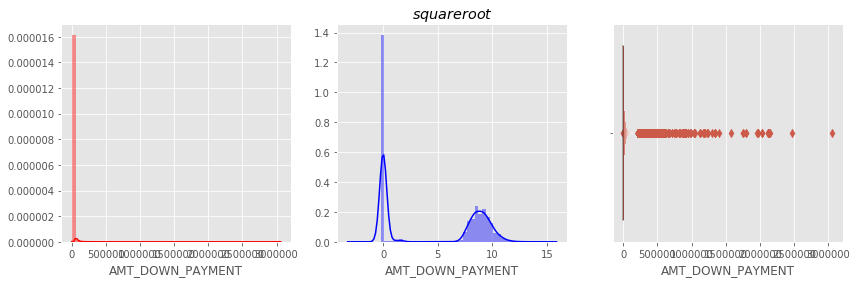

In [274]:
f = plt.figure(figsize =(14,4))
ax = f.add_subplot(131)
sns.distplot((previous_application['AMT_DOWN_PAYMENT'].dropna()),ax= ax,color='red')
ax = f.add_subplot(132)
sns.distplot(np.log1p(previous_application['AMT_DOWN_PAYMENT'].dropna()),ax= ax,color='blue')
plt.title('$log(x+1)$')
ax = f.add_subplot(133)
sns.boxenplot(previous_application['AMT_DOWN_PAYMENT'], ax =ax)

In [275]:
# apply sqrt
previous_application['AMT_DOWN_PAYMENT'] = np.log1p(previous_application['AMT_DOWN_PAYMENT'])

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


### 8.6 Amount good price

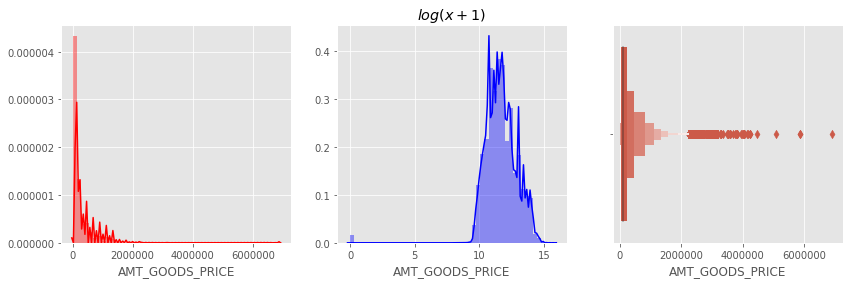

In [276]:
f = plt.figure(figsize =(14,4))
ax = f.add_subplot(131)
sns.distplot((previous_application['AMT_GOODS_PRICE'].dropna()),ax= ax,color='red')
ax = f.add_subplot(132)
sns.distplot(np.log1p(previous_application['AMT_GOODS_PRICE'].dropna()),ax= ax,color='blue')
plt.title('$log(x+1)$')
ax = f.add_subplot(133)
sns.boxenplot(previous_application['AMT_GOODS_PRICE'], ax =ax)

In [277]:
# apply sqrt
previous_application['AMT_GOODS_PRICE'] = np.log1p(previous_application['AMT_GOODS_PRICE'])

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


### 8.7 Time of application process starts

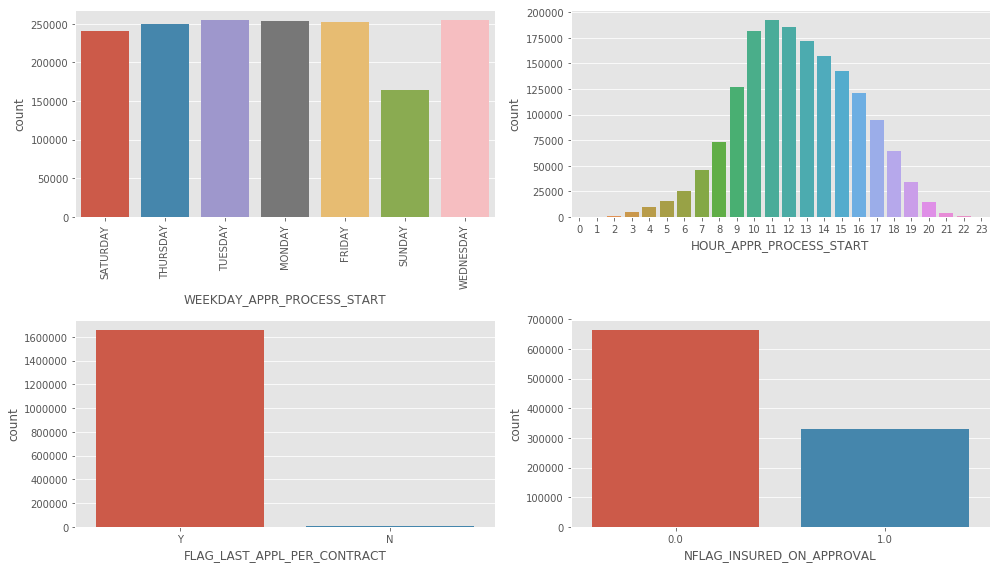

In [278]:
f = plt.figure(figsize=(14,8))
ax = f.add_subplot(221)
sns.countplot(previous_application['WEEKDAY_APPR_PROCESS_START'], ax =ax)
plt.xticks(rotation=90)

ax = f.add_subplot(222)
sns.countplot(previous_application['HOUR_APPR_PROCESS_START'], ax =ax)

ax = f.add_subplot(223)
sns.countplot(previous_application['FLAG_LAST_APPL_PER_CONTRACT'], ax =ax)

ax = f.add_subplot(224)
sns.countplot(previous_application['NFLAG_INSURED_ON_APPROVAL'], ax =ax)

plt.tight_layout()

In [279]:
# convert to object
previous_application[['HOUR_APPR_PROCESS_START','NFLAG_INSURED_ON_APPROVAL']] = previous_application[['HOUR_APPR_PROCESS_START','NFLAG_INSURED_ON_APPROVAL']].astype('object')

### 8.8 Rate down payment

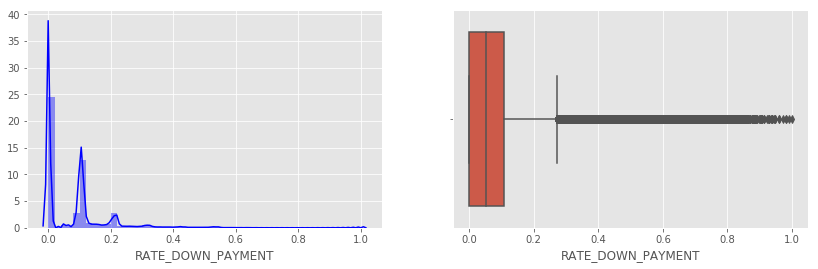

In [283]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot((previous_application['RATE_DOWN_PAYMENT'].dropna()), ax=ax,color='blue')
ax = f.add_subplot(122)
sns.boxplot(previous_application['RATE_DOWN_PAYMENT'], ax=ax, )

### 8.9 Rate interest primary

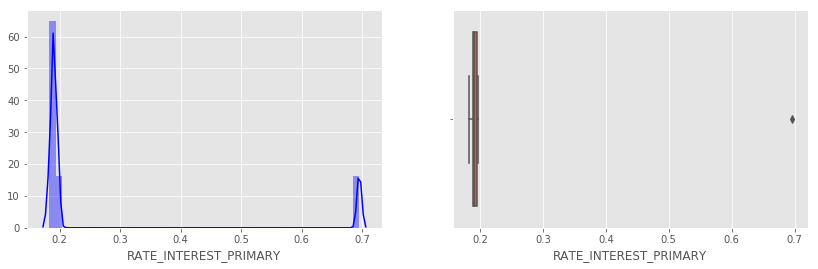

In [184]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(previous_application['RATE_INTEREST_PRIMARY'].dropna(), ax=ax,color='blue')
ax = f.add_subplot(122)
sns.boxplot(previous_application['RATE_INTEREST_PRIMARY'], ax=ax, )

### 8.10 Rate interest privileged

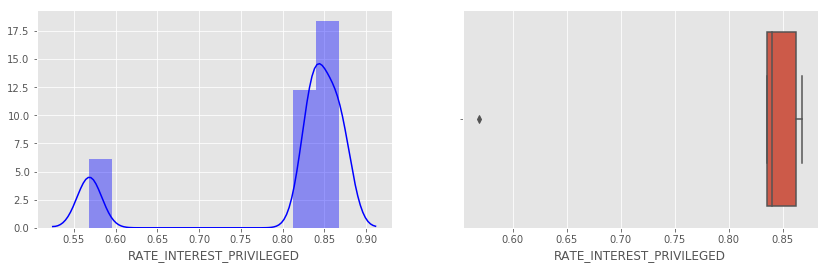

In [185]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(previous_application['RATE_INTEREST_PRIVILEGED'].dropna(), ax=ax,color='blue')
ax = f.add_subplot(122)
sns.boxplot(previous_application['RATE_INTEREST_PRIVILEGED'], ax=ax, )

### 8.11 Day decision

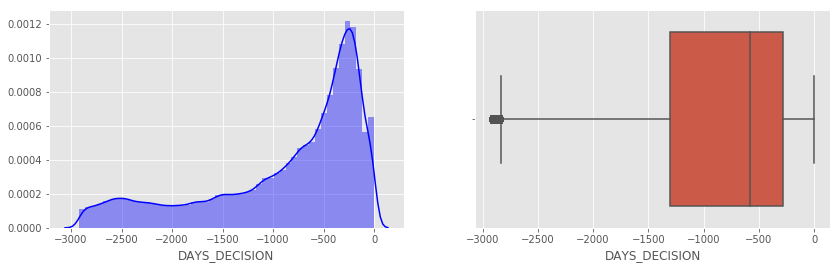

In [284]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(previous_application['DAYS_DECISION'].dropna(), ax=ax,color='blue')
ax = f.add_subplot(122)
sns.boxplot(previous_application['DAYS_DECISION'], ax=ax, )

### 8.12 Code regect reason

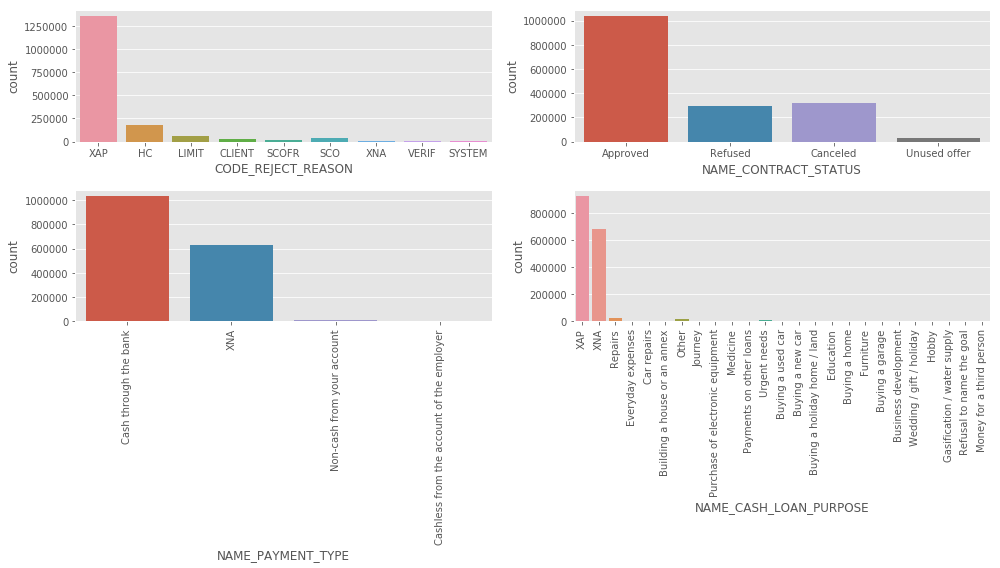

In [285]:
f = plt.figure(figsize=(14,8))
ax = f.add_subplot(221)
sns.countplot(previous_application['CODE_REJECT_REASON'], ax =ax)

ax = f.add_subplot(222)
sns.countplot(previous_application['NAME_CONTRACT_STATUS'], ax =ax)

ax = f.add_subplot(223)
sns.countplot(previous_application['NAME_PAYMENT_TYPE'], ax =ax)
plt.xticks(rotation=90)

ax = f.add_subplot(224)
sns.countplot(previous_application['NAME_CASH_LOAN_PURPOSE'], ax =ax)
plt.xticks(rotation=90)

plt.tight_layout()

### 8.13 Name Portfolio

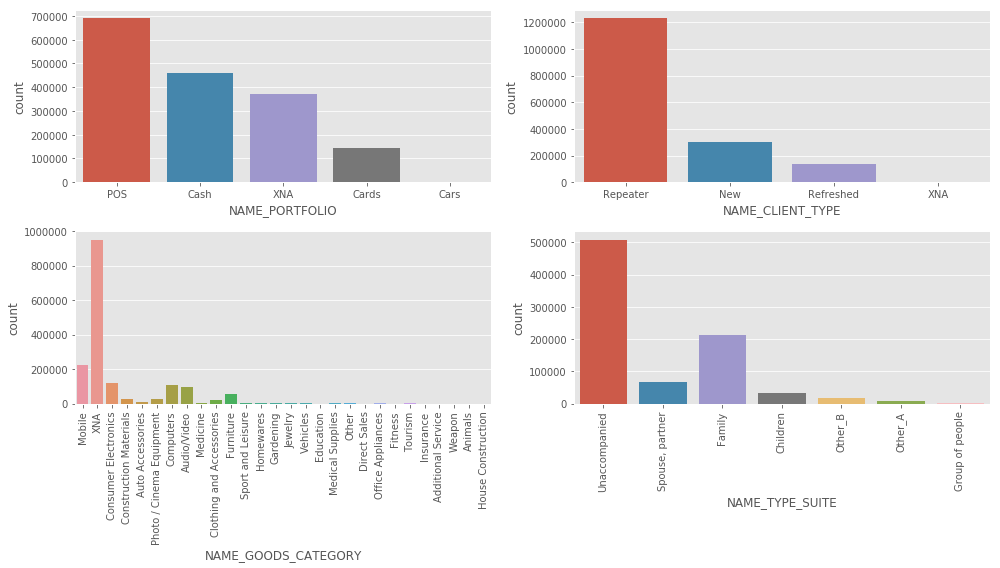

In [286]:
f = plt.figure(figsize=(14,8))
ax = f.add_subplot(221)
sns.countplot(previous_application['NAME_PORTFOLIO'], ax =ax)

ax = f.add_subplot(222)
sns.countplot(previous_application['NAME_CLIENT_TYPE'], ax =ax)

ax = f.add_subplot(223)
sns.countplot(previous_application['NAME_GOODS_CATEGORY'], ax =ax)
plt.xticks(rotation=90)

ax = f.add_subplot(224)
sns.countplot(previous_application['NAME_TYPE_SUITE'], ax =ax)
plt.xticks(rotation=90)

plt.tight_layout()

### 8.14 Name product type

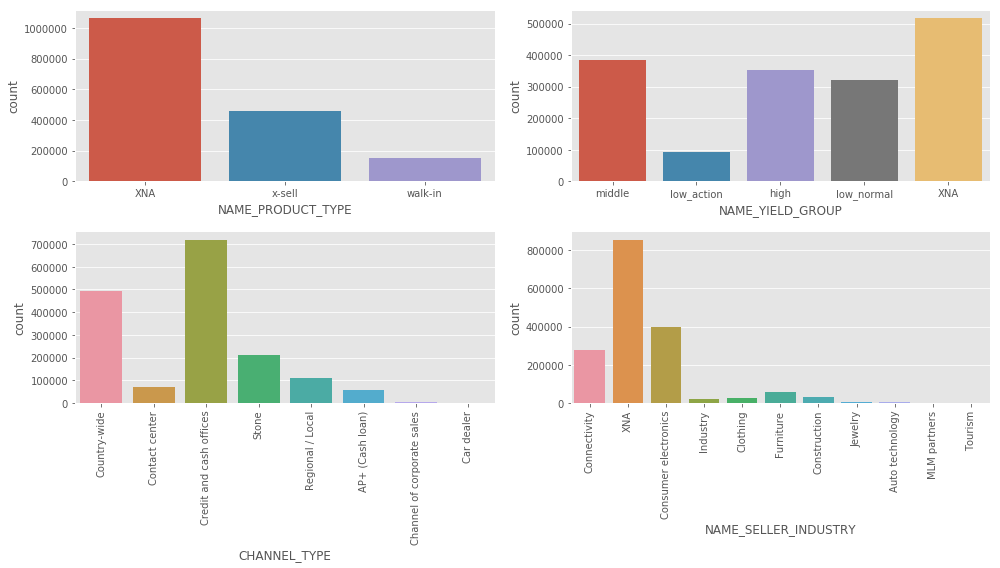

In [287]:
f = plt.figure(figsize=(14,8))
ax = f.add_subplot(221)
sns.countplot(previous_application['NAME_PRODUCT_TYPE'], ax =ax)

ax = f.add_subplot(222)
sns.countplot(previous_application['NAME_YIELD_GROUP'], ax =ax)

ax = f.add_subplot(223)
sns.countplot(previous_application['CHANNEL_TYPE'], ax =ax)
plt.xticks(rotation=90)

ax = f.add_subplot(224)
sns.countplot(previous_application['NAME_SELLER_INDUSTRY'], ax =ax)
plt.xticks(rotation=90)

plt.tight_layout()

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: cannot convert float NaN to integer

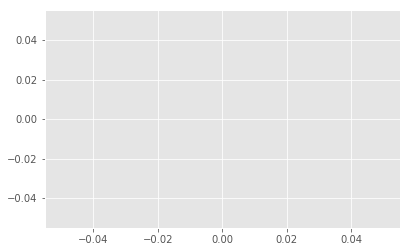

In [297]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
sns.distplot(np.sqrt(previous_application['SELLERPLACE_AREA'].dropna(),ax=ax)
plt.xticks(rotation=90)

ax = f.add_subplot(122)
sns.boxplot(previous_application['SELLERPLACE_AREA'],ax=ax)
plt.xticks(rotation=90)

In [293]:
previous_application[previous_application['SELLERPLACE_AREA']>500000]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
151         2783413      269324     Consumer loans     8.661573   
157014      2094519      392616     Consumer loans     9.868817   
310061      2403159      450405     Consumer loans     8.229402   
919667      1125247      228186     Consumer loans     7.968607   
1427909     1993482      390387     Consumer loans     9.584396   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
151           358.057258    128205.0               0.0        11.761394   
157014        654.828604    428800.5               0.0        12.968749   
310061        288.460569     83209.5               0.0        11.329129   
919667        253.184715     64102.5               0.0        11.068254   
1427909       348.497489    132138.0               0.0        11.707270   

        WEEKDAY_APPR_PROCESS_START HOUR_APPR_PROCESS_START  \
151                         SUNDAY                      20   
157014                      FRIDAY                      20   
310061                      SUNDAY                      19   
919667                      FRIDAY                      18   
1427909                  WEDNESDAY                      13   

                   ...            NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
151                ...                       Furniture         24.0   
157014             ...                    Construction         24.0   
310061             ...                    Construction         24.0   
919667             ...                       Furniture         24.0   
1427909            ...                    Construction         10.0   

         NAME_YIELD_GROUP            PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
151            low_action  POS industry without interest            365243.0   
157014         low_action  POS industry without interest            365243.0   
310061         low_action  POS industry without interest            365243.0   
919667         low_action  POS industry without interest            365243.0   
1427909        low_normal     POS industry with interest            365243.0   

        DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
151             -960.0                    -270.0         -360.0   
157014          -723.0                     -33.0          -33.0   
310061          -452.0                     238.0       365243.0   
919667          -833.0                    -143.0         -143.0   
1427909         -348.0                     -78.0          -78.0   

        DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
151               -354.0                         0  
157014             -31.0                         0  
310061          365243.0                         0  
919667            -141.0                         0  
1427909            -74.0                         0  

[5 rows x 37 columns]

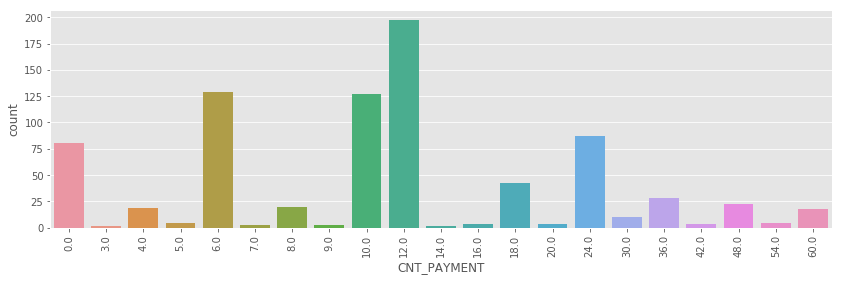

In [192]:
plt.figure(figsize=(14,4))
sns.countplot(previous_application['CNT_PAYMENT'])
plt.xticks(rotation=90);

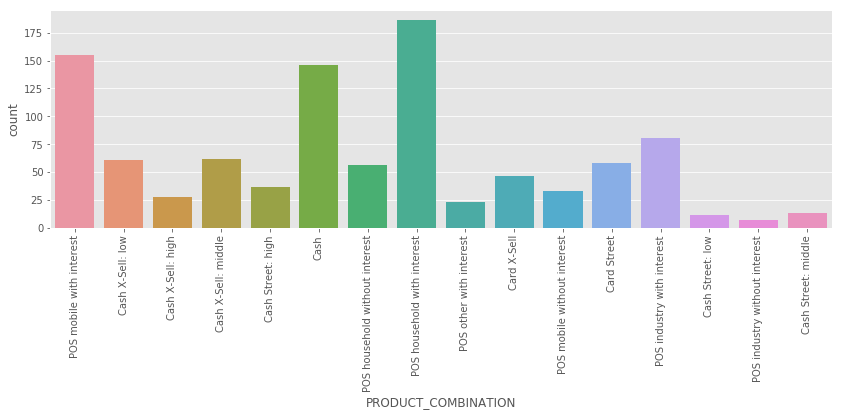

In [193]:
plt.figure(figsize=(14,4))
sns.countplot(previous_application['PRODUCT_COMBINATION'])
plt.xticks(rotation=90);

In [194]:
previous_application[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION']].describe()

DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  \
count          630.000000      630.000000                 630.000000   
mean        348401.500000    13434.547619               24833.461905   
std          76729.945912    71576.670707               93356.532272   
min          -2709.000000    -2886.000000               -2780.000000   
25%         365243.000000    -1569.000000               -1286.500000   
50%         365243.000000     -817.000000                -426.000000   
75%         365243.000000     -377.250000                  60.500000   
max         365243.000000   365243.000000              365243.000000   

       DAYS_LAST_DUE  DAYS_TERMINATION  
count     630.000000        630.000000  
mean    72817.384127      75149.976190  
std    147056.180687     148755.300279  
min     -2780.000000      -2724.000000  
25%     -1300.500000      -1274.250000  
50%      -561.500000       -551.000000  
75%       -89.250000        -57.250000  
max    365243.000000     365243.000000

In [195]:
## Fill missing value
previous_application['DAYS_FIRST_DRAWING'].replace({365243:np.nan},inplace=True)
previous_application['DAYS_FIRST_DUE'].replace({365243:np.nan},inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace({365243:np.nan},inplace=True)
previous_application['DAYS_LAST_DUE'].replace({365243:np.nan},inplace=True)
previous_application['DAYS_TERMINATION'].replace({365243:np.nan},inplace=True)


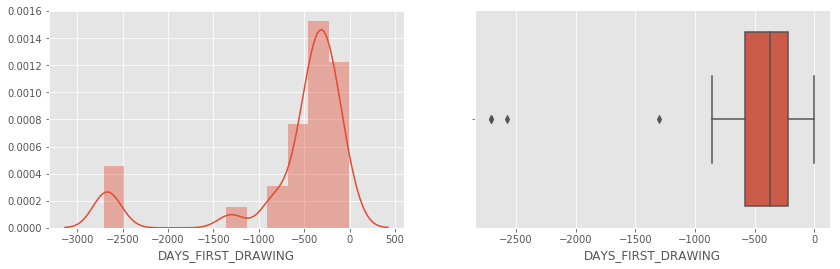

In [196]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(previous_application['DAYS_FIRST_DRAWING'].dropna(),ax=ax)

ax = f.add_subplot(122)
sns.boxplot(previous_application['DAYS_FIRST_DRAWING'],ax=ax)

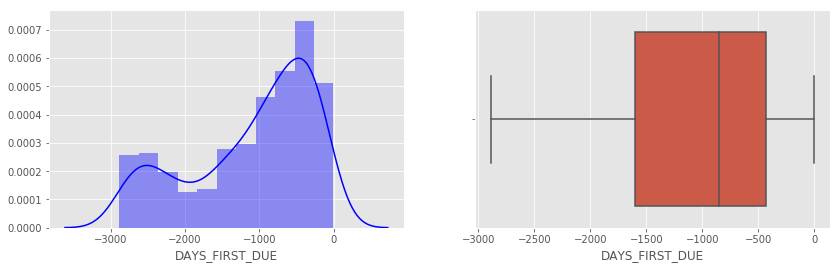

In [197]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(previous_application['DAYS_FIRST_DUE'].dropna(),ax=ax,color='blue')

ax = f.add_subplot(122)
sns.boxplot(previous_application['DAYS_FIRST_DUE'],ax=ax)

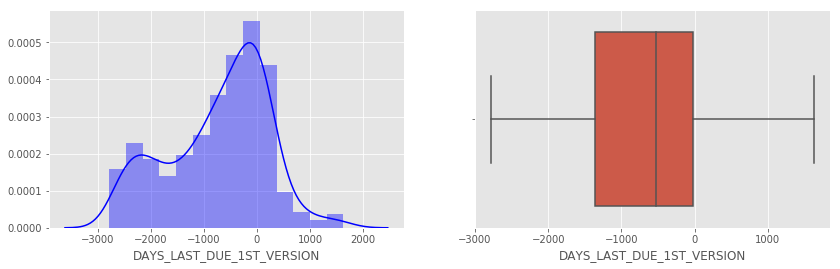

In [198]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(previous_application['DAYS_LAST_DUE_1ST_VERSION'].dropna(),ax=ax,color='blue')

ax = f.add_subplot(122)
sns.boxplot(previous_application['DAYS_LAST_DUE_1ST_VERSION'],ax=ax)

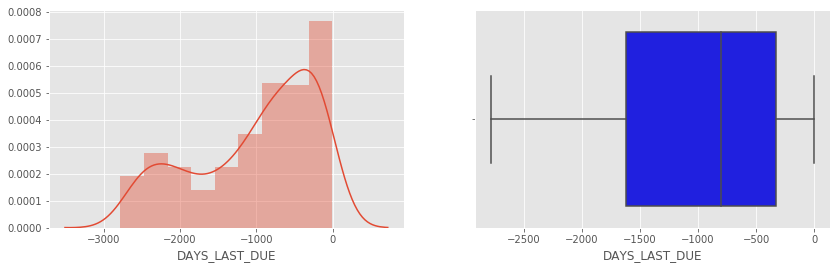

In [199]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(previous_application['DAYS_LAST_DUE'].dropna(),ax=ax)

ax = f.add_subplot(122)
sns.boxplot(previous_application['DAYS_LAST_DUE'],ax=ax,color='blue')

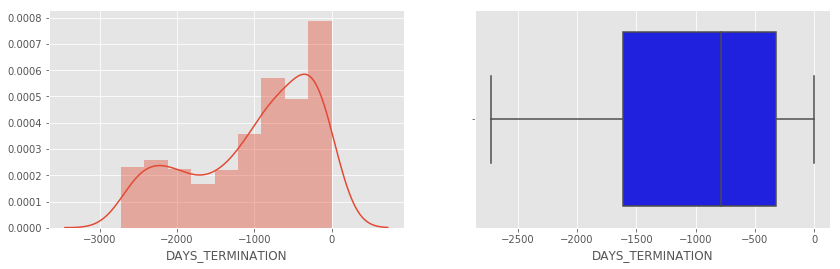

In [200]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(previous_application['DAYS_TERMINATION'].dropna(),ax=ax)

ax = f.add_subplot(122)
sns.boxplot(previous_application['DAYS_TERMINATION'],ax=ax,color='blue')

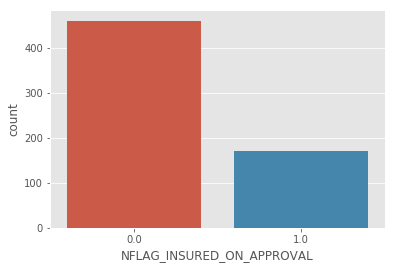

In [201]:
sns.countplot(previous_application['NFLAG_INSURED_ON_APPROVAL'])

### 8.30 Data preprocessing

In [202]:
# Replace XNA XAP
previous_application = replace_XNA_XAP(previous_application)

# Binary encoding
previous_application,prev_bin = binary_encoding(previous_application,prev_cat_col)

# One hot encoding
previous_application,prev_cat = one_hot_encoding(previous_application,columns= prev_cat_col,nan_as_category=True)

prev_aggregate = {
    'AMT_ANNUITY':['mean','sum','min'],
    'AMT_APPLICATION':['mean'],
    'AMT_CREDIT':['mean','min','max'],
    'AMT_DOWN_PAYMENT':['mean','min'],
    'AMT_GOODS_PRICE':['mean','sum','max'],
    'HOUR_APPR_PROCESS_START':['mean','min'],
     'NFLAG_LAST_APPL_IN_DAY': ['mean'],
     'RATE_DOWN_PAYMENT': ['mean'],
     'RATE_INTEREST_PRIMARY':['mean','min','max'],
     'RATE_INTEREST_PRIVILEGED':['mean','min'],
     'DAYS_DECISION':['mean'],
     'SELLERPLACE_AREA':['mean'],
     'CNT_PAYMENT':['mean','sum'],
     'DAYS_FIRST_DRAWING':['mean','min'],
     'DAYS_FIRST_DUE':['mean','min'],
     'DAYS_LAST_DUE_1ST_VERSION':['mean','min'],
     'DAYS_LAST_DUE':['mean','max'],
     'DAYS_TERMINATION':['mean','max'],
     'NFLAG_INSURED_ON_APPROVAL' : ['mean'],
}

for col in prev_cat+prev_bin:
    prev_aggregate[col] =['mean']
    prev_aggregate[col] = ['sum']

prev_agg = previous_application.groupby('SK_ID_CURR').agg(prev_aggregate)
prev_agg.columns = pd.Index(['PREV_'+e[0]+ '_'+ e[1].upper() for e in prev_agg.columns.tolist()])
del previous_application
prev_agg.head()

***** Binary encoding *****
Original shape: (1000, 37)
After: (1000, 137)
***** One hot encoding of categorical variable *****
Original shape (1000, 137)
After OHE (1000, 225)


PREV_AMT_ANNUITY_MEAN  PREV_AMT_ANNUITY_SUM  PREV_AMT_ANNUITY_MIN  \
SK_ID_CURR                                                                      
100077                        NaN                 0.000                   NaN   
100373                  10872.990             10872.990             10872.990   
101011                   6856.065              6856.065              6856.065   
101167                   5437.530              5437.530              5437.530   
101211                   4172.940              4172.940              4172.940   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                                    
100077                            0.0                   0.0   
100373                       115695.0              115119.0   
101011                        65866.5               66735.0   
101167                       120060.0              120060.0   
101211                        29205.0               21204.0   

            PREV_AMT_CREDIT_MIN  PREV_AMT_CREDIT_MAX  \
SK_ID_CURR                                             
100077                      0.0                  0.0   
100373                 115119.0             115119.0   
101011                  66735.0              66735.0   
101167                 120060.0             120060.0   
101211                  21204.0              21204.0   

            PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_DOWN_PAYMENT_MIN  \
SK_ID_CURR                                                          
100077                             NaN                        NaN   
100373                         11569.5                    11569.5   
101011                          6588.0                     6588.0   
101167                             0.0                        0.0   
101211                          9000.0                     9000.0   

            PREV_AMT_GOODS_PRICE_MEAN  \
SK_ID_CURR                              
100077                            NaN   
100373                       115695.0   
101011                        65866.5   
101167                       120060.0   
101211                        29205.0   

                                      ...                             \
SK_ID_CURR                            ...                              
100077                                ...                              
100373                                ...                              
101011                                ...                              
101167                                ...                              
101211                                ...                              

            PREV_BIN_PRODUCT_COMBINATION_Cash X-Sell: high_SUM  \
SK_ID_CURR                                                       
100077                                                      0    
100373                                                      0    
101011                                                      0    
101167                                                      0    
101211                                                      0    

            PREV_BIN_PRODUCT_COMBINATION_Cash X-Sell: low_SUM  \
SK_ID_CURR                                                      
100077                                                      0   
100373                                                      0   
101011                                                      0   
101167                                                      0   
101211                                                      0   

            PREV_BIN_PRODUCT_COMBINATION_Cash X-Sell: middle_SUM  \
SK_ID_CURR                                                         
100077                                                      0      
100373                                                      0      
101011                                                      0      
101167                                                      0      
10121

## 9.0 installments_payments

In [203]:
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [239]:
basic_details(installments_payments)

missing_value  %missing_value   dtypes  N unique
SK_ID_PREV                          0             0.0    int64       970
SK_ID_CURR                          0             0.0    int64       965
NUM_INSTALMENT_VERSION              0             0.0  float64        10
NUM_INSTALMENT_NUMBER               0             0.0    int64       109
DAYS_INSTALMENT                     0             0.0  float64       796
DAYS_ENTRY_PAYMENT                  0             0.0  float64       818
AMT_INSTALMENT                      0             0.0  float64       907
AMT_PAYMENT                         0             0.0  float64       902

The dataset does not contain missing value, all variables as interge or float type, so one hot encoding is not required.

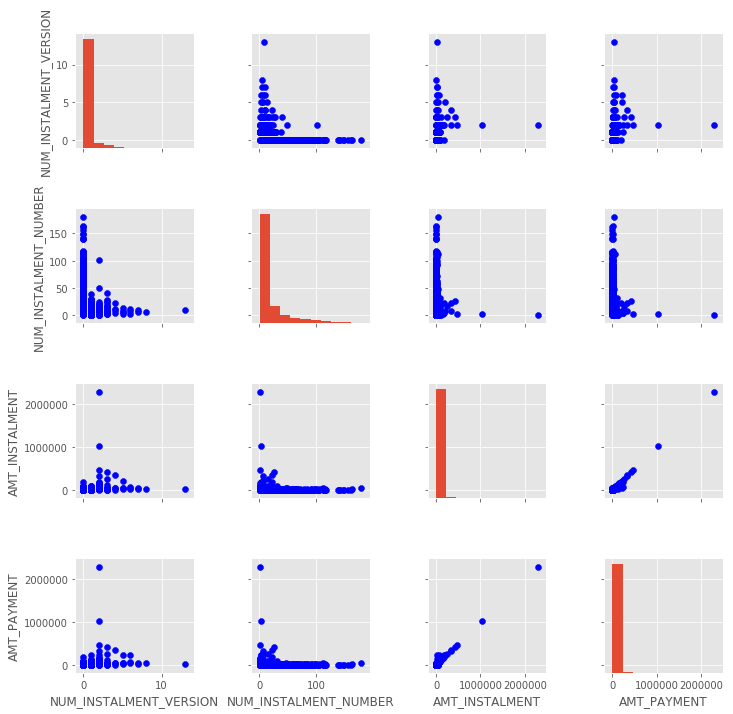

In [241]:
g = sns.pairplot(installments_payments,vars=['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER',
                                            'AMT_INSTALMENT', 'AMT_PAYMENT'],kind='hist')
g.map_offdiag(plt.scatter,color='blue')

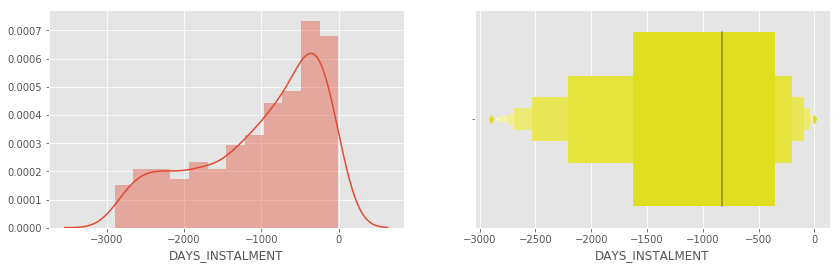

In [206]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(installments_payments['DAYS_INSTALMENT'].dropna(), ax=ax)
ax = f.add_subplot(122)
sns.boxenplot(installments_payments['DAYS_INSTALMENT'], ax =ax, color='yellow')

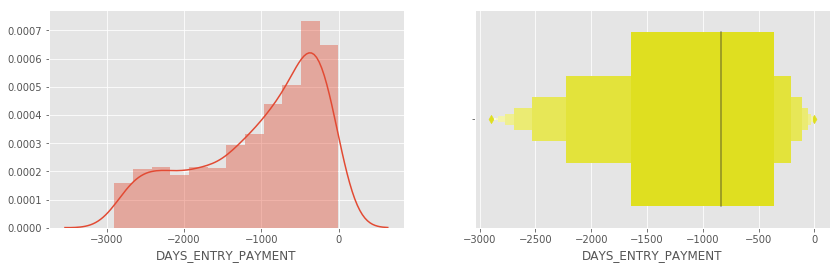

In [207]:
f = plt.figure(figsize= (14,4))
ax = f.add_subplot(121)
sns.distplot(installments_payments['DAYS_ENTRY_PAYMENT'].dropna(), ax=ax)
ax = f.add_subplot(122)
sns.boxenplot(installments_payments['DAYS_ENTRY_PAYMENT'], ax =ax, color='yellow')

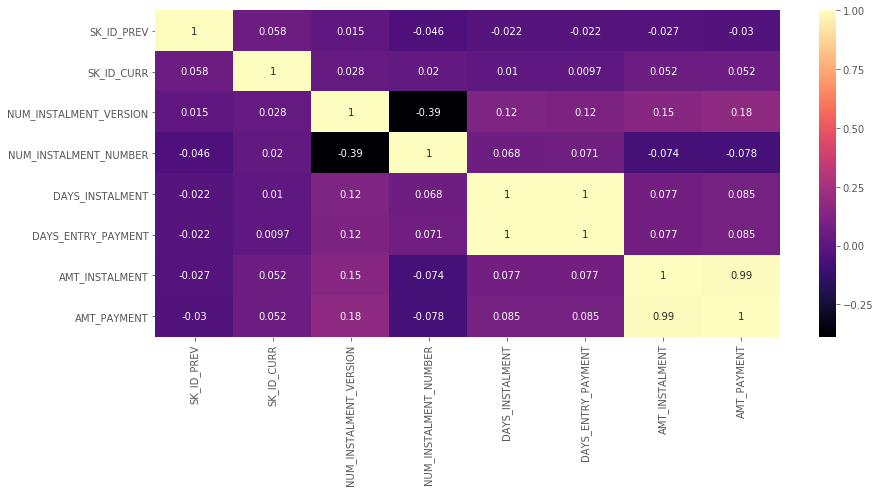

In [208]:
plt.figure(figsize= (14,6))
sns.heatmap(installments_payments.corr(), cmap = 'magma',annot=True)

In [209]:
inst_aggregator = {
    'NUM_INSTALMENT_VERSION':['mean'],
    'NUM_INSTALMENT_NUMBER':['mean','max'],
    'DAYS_INSTALMENT':['min','mean'],
    'DAYS_ENTRY_PAYMENT':['min','mean'],
    'AMT_INSTALMENT':['mean'],
    'AMT_PAYMENT':['mean']
}

inst_agg = installments_payments.groupby('SK_ID_CURR').agg(inst_aggregator)
inst_agg.columns = pd.Index(['INST_'+e[0]+ '_'+ e[1].upper() for e in inst_agg.columns.tolist()])
del installments_payments
inst_agg.head()

INST_NUM_INSTALMENT_VERSION_MEAN  INST_NUM_INSTALMENT_NUMBER_MEAN  \
SK_ID_CURR                                                                      
100012                                   3.0                              4.0   
100187                                   1.0                             24.0   
100193                                   0.0                             56.0   
100266                                   0.0                             42.0   
100299                                   1.0                              2.0   

            INST_NUM_INSTALMENT_NUMBER_MAX  INST_DAYS_INSTALMENT_MIN  \
SK_ID_CURR                                                             
100012                                   4                    -387.0   
100187                                  24                   -1070.0   
100193                                  56                   -1153.0   
100266                                  42                     -58.0   
100299                                   2                   -2323.0   

            INST_DAYS_INSTALMENT_MEAN  INST_DAYS_ENTRY_PAYMENT_MIN  \
SK_ID_CURR                                                           
100012                         -387.0                       -428.0   
100187                        -1070.0                      -1071.0   
100193                        -1153.0                      -1153.0   
100266                          -58.0                        -58.0   
100299                        -2323.0                      -2293.0   

            INST_DAYS_ENTRY_PAYMENT_MEAN  INST_AMT_INSTALMENT_MEAN  \
SK_ID_CURR                                                           
100012                            -428.0                  5242.860   
100187                           -1071.0                 10281.870   
100193                           -1153.0                   301.860   
100266                             -58.0                     3.825   
100299                           -2293.0                 15737.985   

            INST_AMT_PAYMENT_MEAN  
SK_ID_CURR                         
100012                   5242.860  
100187                  10281.870  
100193                    301.860  
100266                      3.825  
100299                      0.045

### Join

In [210]:
# Join all aggregated df with train_test
train_test = train_test.join(bureau_agg,how='left',on='SK_ID_CURR') # bureau
del bureau_agg
train_test = train_test.join(pos_agg, how='left',on='SK_ID_CURR') # POS_CASH
del pos_agg
train_test = train_test.join(inst_agg,how='left',on='SK_ID_CURR') # install
del inst_agg
train_test = train_test.join(credit_agg, how='left',on='SK_ID_CURR') # credit card
del credit_agg
train_test = train_test.join(prev_agg, how='left',on='SK_ID_CURR') # previous
del prev_agg
reduce_memory_usage(train_test)

Intial memory usage: 175.668746948 MB
Memory usage after complition:  112.479232788 MB


## Model selection

In [235]:
# Select columns whose variance > 0
col = train_test.columns
feat = train_test.columns[train_test.var() >0]
train_test = train_test[feat]
print('Number of columns generated:',len(col))
len(feat) - len(col)

Number of columns generated: 813


0

In [212]:
#from sklearn.model_selection import train_test_split
col_drop = ['TARGET','SK_ID_CURR']
X = train_test[train_test['TARGET'].notnull()].drop(col_drop, axis=1)
y = train_test[train_test['TARGET'].notnull()]['TARGET']
test_new = train_test[train_test['TARGET'].isnull()].drop(col_drop, axis=1)

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=seed)

## Model building

In [213]:
# Lightgbm

def model(X_train, X_valid, y_train, y_valid,test_new,random_seed):
    
    lg_param = {}
    lg_param['learning_rate'] = 0.02
    lg_param['n_estimators'] = 10000
    lg_param['max_depth'] = 8
    lg_param['num_leaves'] = 34
    lg_param['boosting_type'] = 'gbdt'
    lg_param['feature_fraction'] = 0.9
    lg_param['bagging_fraction'] = 0.9
    lg_param['min_child_samples'] = 30
    lg_param['lambda_l1'] = 0.04
    lg_param['lambda_l2'] = 0.08
    lg_param['silent'] = -1
    lg_param['verbose'] = -1
    lg_param['nthread'] = 4
    lg_param['seed'] = random_seed
    
    lgb_model = lgb.LGBMClassifier(**lg_param)
    print('-'*10,'*'*20,'-'*10)
    lgb_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid,y_valid)], 
                 eval_metric ='auc', verbose =100, early_stopping_rounds=200)
    y_pred = lgb_model.predict_proba(X_valid)[:,1]
    print('roc_auc_score',roc_auc_score(y_valid,y_pred),'-'*30,i+1)
    y_pred_new = lgb_model.predict_proba(test_new)[:,1]
    return y_pred,y_pred_new,lgb_model

In [214]:
# KFold cross validation
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

#y_pred = 0
y_pred_new = 0

for i,(train_index, valid_index) in enumerate(kf.split(X,y)):    
    X_train, X_valid = X.loc[train_index], X.loc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print('\n{} fold of {} KFold'.format(i+1,kf.n_splits))
    y_pred,y_pred2,lgb_model = model(X_train, X_valid, y_train, y_valid,test_new,random_seed = i)
    #y_pred += y_pred1
    y_pred_new += y_pred2



1 fold of 3 KFold
---------- ******************** ----------
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.995	valid_1's auc: 0.681369
[200]	training's auc: 0.999935	valid_1's auc: 0.68965
Early stopping, best iteration is:
[8]	training's auc: 0.912062	valid_1's auc: 0.715446
roc_auc_score 0.715445859873 ------------------------------ 1

2 fold of 3 KFold
---------- ******************** ----------
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.996569	valid_1's auc: 0.716559
[200]	training's auc: 1	valid_1's auc: 0.70712
Early stopping, best iteration is:
[42]	training's auc: 0.974445	valid_1's auc: 0.739617
roc_auc_score 0.739617044229 ------------------------------ 2

3 fold of 3 KFold
---------- ******************** ----------
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.998395	valid_1's auc: 0.746555
[200]	training's auc: 1	valid_1's auc: 0.7334
[300]	training'

### Feature Importance

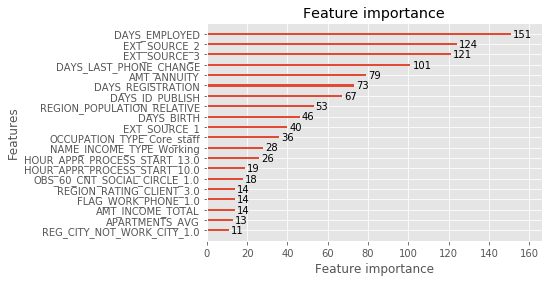

In [227]:
lgb.plot_importance(lgb_model,max_num_features=20)

In [233]:
feat_impo = pd.DataFrame({'Columns':X.columns,'Importance':lgb_model.feature_importances_})
feat_impo.sort_values('Importance',ascending=False).head()         

Columns  Importance
6            DAYS_EMPLOYED         151
10            EXT_SOURCE_2         124
11            EXT_SOURCE_3         121
55  DAYS_LAST_PHONE_CHANGE         101
2              AMT_ANNUITY          79

In [234]:
feat_impo.sort_values('Importance',ascending=True).head()         

Columns  Importance
405  AMT_REQ_CREDIT_BUREAU_YEAR_12.0           0
538         Q1DAYS_LAST_PHONE_CHANGE           0
540          POS_MONTHS_BALANCE_MEAN           0
541           POS_MONTHS_BALANCE_MAX           0
542          POS_CNT_INSTALMENT_MEAN           0

Text(0.5,1,'Reciver Operating Characteristics')

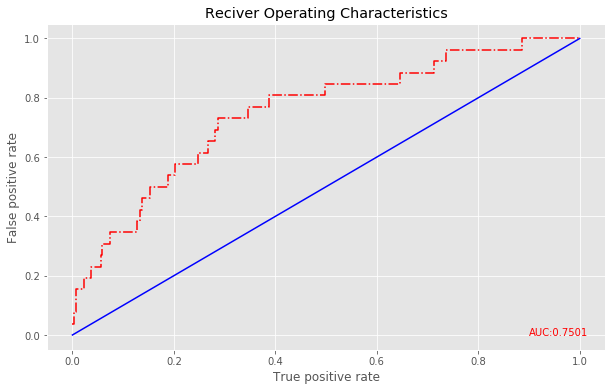

In [224]:
fpr,tpr,threshold =roc_curve(y_valid, y_pred)
plt.figure(figsize= (10,6))
auc_value = round(auc(fpr,tpr),4)
plt.text(0.9,0,'AUC:'+str(auc_value),color='r')
plt.plot(fpr,tpr, 'r-.',label='roc')
plt.plot([0,1],[0,1],'b-')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciver Operating Characteristics')

### Submision

In [225]:
submit  = pd.DataFrame({'SK_ID_CURR':test_index,'TARGET':y_pred_new/kf.n_splits})
submit.to_csv('home_credit.csv',index=False)
submit.head()

SK_ID_CURR    TARGET
0      100001  0.047050
1      100005  0.061234
2      100013  0.037833
3      100028  0.042534
4      100038  0.059259

# Thank you